> This script performs exploration of the data. <br>
> Sources:
  
> Master file `mapped-lcia-results.xlsx` containing:
>  * in Sheet1: LCIA results of interest mapped against the data from EI35APOS (volumes, prices, etc.)  
>  * in lcia_methods sheet: the names of the LCIA methods

Note:
> `mapped-lcia-results.xlsx` file was generated in `0.02-vt-map-lcia-results-to-sp910-and-ei35apos-processes.ipynb`

In [1]:
# %env
# %who_ls
# %who
# %who int
# %pinfo <var name>

### Import basic libraries and funtions

In [2]:
%config IPCompleter.use_jedi = False # disable jedi autocompleter (https://stackoverflow.com/a/65734178/14485040)

import project_path  # makes possible the access to `src` directory using relative path
from src.data import (
    create_glo_market,
    filter_dataframe,
    internal_funcs,
    outlier_detectors,
)
from src.utils import explore_dir, make_readme_info, progressbar
from src.utils import read_excel_to_pandas as r_excel
from src.utils import set_outputs_dir
from src.utils import write_pandas_to_excel as w_excel
from src.visualization import (
    calculate_stats,
    create_fig,
    fix_hist_cdf_drop_line_at_end,
    linear_regr,
    turn_to_scientific,
)

%run init_nb.ipynb

# Prepare data

## Read and pretreat extracted data

### Identify file(s) to read

In [3]:
# Explore the directory to find the file(s)

inputs_dir, files_list = explore_dir(
    path_to_dir=r"..\data\interim", file_extension="xlsx", print_files_list=True
)

from pathlib import Path; import os # temp

# Set output directory
outputs_dir = set_outputs_dir(
    use_default=False, rel_path_output=r"..\data\interim\figs"
)

# Sub-folders
pngFilesDir = outputs_dir/'png_files' # full path to folder w/png files
svgFilesDir = outputs_dir/'svg_files' # full path to folder w/svg files

# Generate required folders if needed
if not Path.exists(pngFilesDir):
    os.mkdir(pngFilesDir)
if not Path.exists(svgFilesDir):
    os.mkdir(svgFilesDir)

['CPC33to36_other_chemicals.xlsx',
 'df_chemproperties.xlsx',
 'lcia-results-from-sp910-combined.xlsx',
 'mapped-lcia-results.xlsx']


### - read master file to df (raw)

<div class="alert alert-block alert-danger">
    <h3> pending (possible) improvements: </h3>


1. FIND WITH A REGULAR EXPRESSION! # THE PATTERN IS THE TUPLE LIKE NAMING OF THE METHODS !!!


</div>

In [4]:
# Process raw data

# Master df with raw data
df_master_raw = r_excel(inputs_dir, "mapped-lcia-results.xlsx", sheets="Sheet1")
print(
    "df of the master data (raw) ".ljust(40, "."),
    f"{df_master_raw.shape}\n".rjust(13, "."),
)

# Get unique names of the LCIA methods
lcia_methods = r_excel(inputs_dir, "mapped-lcia-results.xlsx", sheets="lcia_methods")[
    "Method"
].values.tolist()

print("Unique names of LCIA methods ({} in total):".format(len(lcia_methods)))
print(
    "".join(map('\n\t"{}", '.format, lcia_methods))
)  # unique method names from all the workbooks

df of the master data (raw) ............ ...(946, 93)

Unique names of LCIA methods (7 in total):

	"PBs-LCIA (baseline) V0.72", 
	"PBs-LCIA V0.71 V0.71", 
	"IPCC 2013 GWP 100a V1.03", 
	"ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A", 
	"PBs - Alternative: EF - LANCA V0.70", 
	"Cumulative Energy Demand V1.11 / Cumulative energy demand", 
	"ReCiPe 2016 Midpoint (H) V1.03 / World (2010) H", 


### - drop redundant and unnecessary columns
<div class="alert alert-block alert-info">
created: <strong>df_analysis_prev</strong>
</div>

#### -- 1. identify columns w/ method labels and list "non-method" columns

In [5]:
# a. select all the methods, make a dictionary
"""creates a dictionary -> {'method': [method labels in df]}
        {'method1': ["('method1', 'category1', 'unit1')", "('method1', 'category2', 'unit2')", ...], 
         'method2': [...]
"""
dict_fullMethods = {}

for method in lcia_methods:
    lst = []
    for label in df_master_raw.columns:
        if method in label:
            lst.append(label)
    dict_fullMethods.setdefault(method, []).extend(
        lst
    )  # should be .extend() ! not .append()

# b. flat list of df's labels corresponding to a method
lst_all_method_labels = [
    value for key in dict_fullMethods.keys() for value in dict_fullMethods[key]
]
# (an alternative) [item for sublist in list(dict_fullMethods.values()) for item in sublist]
print(
    "df_master_raw (consisting of {} columns) contains a list of {} methods."
    "\n\nHere is a sample of 3 randomly shown methods:"
    "\n\t- {}\n\t- {}\n\t- {}"
    "\n\n*Check the full list of methods by printing 'lst_all_method_labels',\n"
    "or using 'dict_fullMethods' dictionary with keys in 'lcia_methods'.".format(
        len(df_master_raw.columns),
        len(lst_all_method_labels),
        *random.sample(lst_all_method_labels, 3)
    )
)
# c. rest of the columns in df_master_raw
rest_of_columns = [col for col in df_master_raw.columns if col not in lst_all_method_labels]
print(
    "\nThe rest of the {} columns, shown below, "
    "may contain redundant or unnecessary information,"
    "\nfill free to select only required columns.".format(
        len(rest_of_columns)
    )
)
print("".join(map('\n\t"{}", '.format, rest_of_columns)))

df_master_raw (consisting of 93 columns) contains a list of 62 methods.

Here is a sample of 3 randomly shown methods:
	- ('PBs-LCIA V0.71 V0.71', 'Biogeochemical flows - N', 'Tg N')
	- ('PBs-LCIA V0.71 V0.71', 'Stratospheric ozone depletion', 'DU')
	- ('PBs - Alternative: EF - LANCA V0.70', 'Cancer human health effects', 'CTUh')

*Check the full list of methods by printing 'lst_all_method_labels',
or using 'dict_fullMethods' dictionary with keys in 'lcia_methods'.

The rest of the 31 columns, shown below, may contain redundant or unnecessary information,
fill free to select only required columns.

	"wkbName", 
	"Activity", 
	"activity_comment", 
	"type", 
	"referenceProduct", 
	"shortName_geo", 
	"activityName_SP", 
	"fullName_SimaPro", 
	"unit", 
	"amount", 
	"allocation_percentage", 
	"wasteType", 
	"category", 
	"inline_comment", 
	"activityName_EI", 
	"geo", 
	"activity_ISICclass", 
	"activity_ecoSpold01class", 
	"technologyLevel", 
	"referenceProductName", 
	"referenceProductAmou

#### -- 2. select columns w/ non-method labels
<div class="alert alert-block alert-danger">
     <h5> ``lst_metadata`` has to be populated manually ❗ </h5>
</div>

In [6]:
# 2. Pick from the rest of the columns
print(df_master_raw[rest_of_columns].nunique())

# list of df's non-method labels (select manually from the list printed above)
lst_metadata = [
    "Activity",
    "activity_comment",
    "type",
    "referenceProduct",
    "category",
    "inline_comment",
    # 👆🏼 above columns are originally from _SP,
    # 👇🏼 below from _EI
    "geo",
    "activity_ISICclass",
    "activity_ecoSpold01class",
    "technologyLevel",
    "referenceProductAmount",
    "referenceProductUnit",
    "referenceProduct_prodVolume",
    "referenceProduct_prodVolumeComment",
    "referenceProduct_price",
    "referenceProduct_priceUnit",
    "referenceProduct_priceComment",
    "referenceProduct_casNumber",
    "referenceProduct_CPCclass",
    "activity_generalComment",
    "sourceFilename",
]
print(
    "\nTotal ºn of non-method columns (above) is {}, you selected {} of them.".format(
        len(rest_of_columns), len(lst_metadata)
    )
)

wkbName                                18
Activity                              946
activity_comment                      946
type                                    1
referenceProduct                      720
shortName_geo                           8
activityName_SP                       243
fullName_SimaPro                      946
unit                                    2
amount                                  1
allocation_percentage                   1
wasteType                              17
category                               48
inline_comment                        516
activityName_EI                       724
geo                                     8
activity_ISICclass                     40
activity_ecoSpold01class               37
technologyLevel                         2
referenceProductName                  720
referenceProductAmount                  1
referenceProductUnit                    2
referenceProduct_prodVolume           514
referenceProduct_prodVolumeComment

#### -- 3. select columns w/ method labels
<div class="alert alert-block alert-danger">
     <h5> ``lst_methods`` is generated here 👇🏼</h5>
     lst_methods will be used throughout the script for calculations and plotting
</div>

In [7]:
# lst_all_method_labels # here is the complete list of methods per category if needed
print("Here is the list of method names (again): ")
print("".join(map('\n\t"{}", '.format, lcia_methods)))

Here is the list of method names (again): 

	"PBs-LCIA (baseline) V0.72", 
	"PBs-LCIA V0.71 V0.71", 
	"IPCC 2013 GWP 100a V1.03", 
	"ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A", 
	"PBs - Alternative: EF - LANCA V0.70", 
	"Cumulative Energy Demand V1.11 / Cumulative energy demand", 
	"ReCiPe 2016 Midpoint (H) V1.03 / World (2010) H", 


In [8]:
# select from method names printed above
select_keys = [
    "IPCC 2013 GWP 100a V1.03",
    "PBs-LCIA (baseline) V0.72",
]  # change manually if needed

lst_methods = []
for key in select_keys:
    lst_methods += dict_fullMethods[key]
print("{} methods have been selected:".format(len(lst_methods)))
del select_keys
lst_methods

10 methods have been selected:


["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')",
 "('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')",
 "('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')",
 "('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')",
 "('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')",
 "('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')",
 "('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')",
 "('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')",
 "('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')",
 "('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"]

#### -- 4. Generate ``analysis_prev`` df (and delete ``df_master_raw`` ?)

In [9]:
df_master_raw.filter(items=lst_metadata + lst_methods, axis=1).sort_values(
    by="Activity", inplace=False
)

Activity  \
330  1,1-difluoroethane, HFC-152a {GLO}| market for...   
327              1-butanol {GLO}| market for | APOS, S   
328             1-pentanol {GLO}| market for | APOS, S   
329             1-propanol {GLO}| market for | APOS, S   
338  2,4-di-tert-butylphenol {GLO}| market for 2,4-...   
..                                                 ...   
324           Zinc sulfide {GLO}| market for | APOS, S   
325  Zircon, 50% zirconium {GLO}| market for | APOS, S   
326        Zirconium oxide {GLO}| market for | APOS, S   
723  [sulfonyl]urea-compound {GLO}| market for | AP...   
722  [thio]carbamate-compound {GLO}| market for | A...   

                                      activity_comment      type  \
330  Production volume: 7500000 kgIncluded activ...  Products   
327  Production volume: 2594880000 kgIncluded ac...  Products   
328  Production volume: 110400000 kgIncluded act...  Products   
329  Production volume: 347701149.425287 kgInclu...  Products   
338  This dataset represents the supply of 1 kg of ...  Products   
..                                                 ...       ...   
324  Production volume: 3477011494.25287 kgInclu...  Products   
325  Production volume: 1094000000 kgIncluded ac...  Products   
326  Production volume: 65640000 kgIncluded acti...  Products   
723  In this market, expert judgement was used to d...  Products   
722  In this market, expert judgement was used to d...  Products   

                 referenceProduct                     category  \
330  1,1-difluoroethane, HFC-152a     Chemicals\Organic\Market   
327                     1-butanol     Chemicals\Organic\Market   
328                    1-pentanol     Chemicals\Organic\Market   
329                    1-propanol     Chemicals\Organic\Market   
338       2,4-di-tert-butylphenol     Chemicals\Organic\Market   
..                            ...                          ...   
324                  Zinc sulfide   Chemicals\Inorganic\Market   
325         Zircon, 50% zirconium   Chemicals\Inorganic\Market   
326               Zirconium oxide   Chemicals\Inorganic\Market   
723       [sulfonyl]urea-compound  Chemicals\Pesticides\Market   
722      [thio]carbamate-compound  Chemicals\Pesticides\Market   

                                   inline_comment  geo  \
330           Production Volume Amount: 7500000  GLO   
327        Production Volume Amount: 2594880000  GLO   
328         Production Volume Amount: 110400000  GLO   
329  Production Volume Amount: 347701149.425287  GLO   
338          Production Volume Amount: 25000000  GLO   
..                                            ...  ...   
324  Production Volume Amount: 3477011494.25287  GLO   
325        Production Volume Amount: 1094000000  GLO   
326          Production Volume Amount: 65640000  GLO   
723  Production Volume Amount: 24811474.2905028  GLO   
722  Production Volume Amount: 265815009.944134  GLO   

                                    activity_ISICclass  \
330                2011:Manufacture of basic chemicals   
327                2011:Manufacture of basic chemicals   
328                2011:Manufacture of basic chemicals   
329                2011:Manufacture of basic chemicals   
338                2011:Manufacture of basic chemicals   
..                                                 ...   
324                2011:Manufacture of basic chemicals   
325        0729:Mining of other non-ferrous metal ores   
326                2011:Manufacture of basic chemicals   
723  2021:Manufacture of pesticides and other agroc...   
722  2021:Manufacture of pesticides and other agroc...   

                        activity_ecoSpold01class  technologyLevel  ...  \
330                           chemicals/organics              0.0  ...   
327                           chemicals/organics              0.0  ...   
328                           chemicals/organics              0.0  ...   
329                           chemicals/organics 

In [10]:
# 3. Combine steps 2 and 3

df_analysis_prev = df_master_raw.loc[:, list(lst_metadata + lst_methods)].copy()
df_analysis_prev.sort_values(by="Activity", inplace=True)

# del df_master_raw # delete to free memory
pd.options.display.max_columns = None

print("Created **df_analysis_prev** dataframe is of {} shape.".format(df_analysis_prev.shape))
df_analysis_prev.sample(5)

Created **df_analysis_prev** dataframe is of (946, 31) shape.


Activity  \
909  Nylon 6, glass-filled {RER}| market for nylon ...   
72   Green manure, organic, until February {CH}| ma...   
102  Nitrous dioxide {RoW}| market for nitrous diox...   
802                Kerosene {CH}| market for | APOS, S   
667  Coating powder {RoW}| market for coating powde...   

                                      activity_comment      type  \
909  This dataset represents the supply of 1 kg of ...  Products   
72   The product - green manure - is consumed in th...  Products   
102  In this market, expert judgement was used to d...  Products   
802  [This dataset was already contained in the eco...  Products   
667  In this market, expert judgement was used to d...  Products   

                          referenceProduct  \
909                  Nylon 6, glass-filled   
72   Green manure, organic, until February   
102                        Nitrous dioxide   
802                               Kerosene   
667                         Coating powder   

                                   category  \
909            Plastics\Thermoplasts\Market   
72   Chemicals\Fertilisers (organic)\Market   
102                  Chemicals\Gases\Market   
802               Fuels\Oil\Kerosene\Market   
667                 Chemicals\Others\Market   

                                        inline_comment  geo  \
909       Production Volume Amount: 1.32236940655721  RER   
72         Production Volume Amount: 0.0336675422387   CH   
102                Production Volume Amount: 6700000  RoW   
802  EcoSpold01Location=CHProduction Volume Amount...   CH   
667       Production Volume Amount: 2.67763059344279  RoW   

                                    activity_ISICclass  \
909  2013:Manufacture of plastics and synthetic rub...   
72         0161:Support activities for crop production   
102                2011:Manufacture of basic chemicals   
802     1920:Manufacture of refined petroleum products   
667  2022:Manufacture of paints, varnishes and simi...   

                     activity_ecoSpold01class  technologyLevel  \
909                                       NaN              NaN   
72   agricultural production/plant production              0.0   
102                                       NaN              0.0   
802                                 oil/fuels              0.0   
667                         metals/processing              0.0   

     referenceProductAmount referenceProductUnit  referenceProduct_prodVolume  \
909                       1                   kg                 1.322369e+00   
72                        1                   ha                 3.366754e-02   
102                       1                   kg                 6.700000e+06   
802                       1                   kg                 1.473652e+09   
667                       1                   kg                 2.677631e+00   

    referenceProduct_prodVolumeComment  referenceProduct_price  \
909                                NaN                   1.290   
72                                 NaN                  25.000   
102                                NaN                   0.685   
802                                NaN                   0.297   
667                                NaN                   2.800   

    referenceProduct_priceUnit  \
909                    EUR2005   
72                     EUR2005   
102                    EUR2005   
802                    EUR2005   
667                    EUR2005   

                         referenceProduct_priceComment  \
909  Temporary price data. Calculated as 90% of pur...   
72   Calculated based on inputs: The price of the p...   
102  Calculated based on inputs: The price of the p...   
802  Temporary price data. Calculated as 90% of pur...   
667  Calculated based on inputs: The price of the p...   

    referenceProduct_casNumber  \
909                        NaN   
72                         NaN   
102                        NaN   
802                        Na

### - add data with chemical properties (from PubChem)
<div class="alert alert-block alert-info">
    created: <strong>df_properties</strong> (based on unique items of <strong>df_analysis_prev</strong>) <br><br>
    created: <strong>df_analysis</strong>
</div>

<div class="alert alert-block alert-warning">
<h4 class="alert-heading">WARNING ❗</h4>
    This step is <strong>time consuming</strong> due to the API restriction of PubChem database. <br>
    The code below will be inactive by default, the extracted data can be also imported from an Excel file.
</div>

In [11]:
df_analysis_prev[df_analysis_prev.referenceProduct == "Nylon 6-6"]

# for "Nylon 6-6" to be found in PubChem, CAS number has to be included (as found in cirpy, below).
# add CAS number "52349-42-5" to reference product "Nylon 6-6"
df_analysis_prev.loc[df_analysis_prev.referenceProduct == "Nylon 6-6", "referenceProduct_casNumber"] = "52349-42-5"

df_analysis_prev[df_analysis_prev.referenceProduct == "Nylon 6-6"]

Activity  \
905  Nylon 6-6 {GLO}| market for | APOS, S   

                                      activity_comment      type  \
905  In this market, expert judgement was used to d...  Products   

    referenceProduct                      category  \
905        Nylon 6-6  Plastics\Thermoplasts\Market   

                    inline_comment  geo  \
905  Production Volume Amount: 4  GLO   

                                    activity_ISICclass  \
905  2013:Manufacture of plastics and synthetic rub...   

    activity_ecoSpold01class  technologyLevel  referenceProductAmount  \
905        plastics/polymers              0.0                       1   

    referenceProductUnit  referenceProduct_prodVolume  \
905                   kg                          4.0   

    referenceProduct_prodVolumeComment  referenceProduct_price  \
905                                NaN                    1.29   

    referenceProduct_priceUnit  \
905                    EUR2005   

                         referenceProduct_priceComment  \
905  Calculated from EU prices by use of exchange r...   

    referenceProduct_casNumber       referenceProduct_CPCclass  \
905                 52349-42-5  347: Plastics in primary forms   

                               activity_generalComment  \
905  In this market, expert judgement was used to d...   

                                        sourceFilename  \
905  22545_8be843fd-46ec-4a02-9adf-42e7a0610550_b16...   

     ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
905                                           8.336883            

     ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
905                                       1.827852e-10                            

     ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
905                                       2.461495e-12                            

     ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
905                                       1.043403e-13                      

     ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
905                                       5.585417e-13                      

     ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')  \
905                                       2.926218e-13                   

     ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')  \
905                                       1.640800e-10                   

     ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')  \
905                                       2.839772e-17                   

     ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')  \
905                                       3.586094e-13                 

     ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')  
905                                       1.797844e-12

#### --- query PubChem database (deactivated by default)

In [12]:
# %%time
# df_properties = get_properties_from_pubchem(
#     df=df_analysis_prev.drop_duplicates(subset=["referenceProduct", "referenceProduct_casNumber"]),
#     cas_column="referenceProduct_casNumber",
#     name_column="referenceProduct",
# )
# df_properties.reset_index(inplace=True)
# df_properties.rename(columns={"index":"referenceProduct"}, inplace=True)

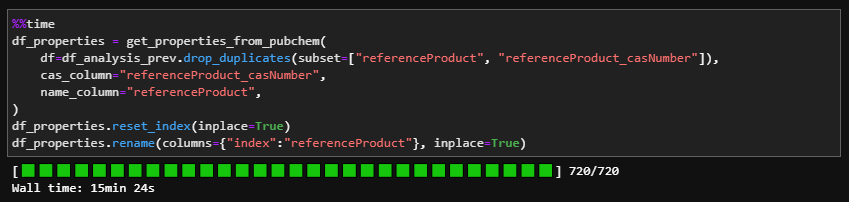

#### --- export to excel (activate if previous cell is active)

In [13]:
# ## Export dataframe to excel
# excelName = "df_chemproperties.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Dataframe with chemical properties for unique reference products from df_analysis_prev. \n"
#     "Chemical properties were retrieved from PubChem database.",
# ) 

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_properties}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

#### --- backup read from excel (deactivate if previous 2 cells are active)

In [14]:
# df with chemical properties
df_properties = r_excel(inputs_dir, "df_chemproperties.xlsx", sheets="Sheet1")
print(
    "df of chemical properties data (raw) ".ljust(40, "."),
    f"{df_properties.shape}\n".rjust(13, "."),
)

df of chemical properties data (raw) ... ....(720, 9)



In [15]:
df_properties.sort_values(by=["MW", "pubchem_match"], ascending=True, inplace=True)
df_properties.sample(3)

referenceProduct          cas  \
168                                       Cyclohexanol          NaN   
220  Ethanol, without water, in 99.7% solution stat...  000064-17-5   
192                                 Dimethyl sulfoxide      67-68-5   

    pubchem_match  num_matches      MF      MW                  iupac  \
168       by NAME            1  C6H12O  100.16           cyclohexanol   
220       by NAME            1   C2H6O   46.07                ethanol   
192        by CAS            1  C2H6OS   78.14  methylsulfinylmethane   

     complexity                                           synonyms  
168        46.1  ['CYCLOHEXANOL', '108-93-0', 'Cyclohexyl alcoh...  
220         2.8  ['ethanol', 'ethyl alcohol', 'alcohol', '64-17...  
192        29.0  ['dimethyl sulfoxide', 'DMSO', '67-68-5', 'Met...

In [16]:
percent_not_matched = (
    1
    - df_properties[df_properties.num_matches != 0].referenceProduct.count()
    / df_properties.referenceProduct.count()
) * 100
print("{}% of referenceProducts had no match...".format(percent_not_matched.round(2)))

29.86% of referenceProducts had no match...


#### --- **explore df_properties

In [17]:
# df_properties[df_properties.num_matches == 0]

In [18]:
df_properties[df_properties.num_matches == 0]

referenceProduct          cas  \
11                                      2-cyclopentone          NaN   
22            Acetamide-anillide-compound, unspecified          NaN   
35   Acrylic binder, without water, in 34% solution...          NaN   
36   Acrylic dispersion, without water, in 65% solu...          NaN   
37                                      Acrylic filler          NaN   
..                                                 ...          ...   
710                                             Xylene    1330-20-7   
713                                   Zinc monosulfate          NaN   
716                              Zircon, 50% zirconium  001490-68-2   
718                            [sulfonyl]urea-compound          NaN   
719                           [thio]carbamate-compound          NaN   

    pubchem_match  num_matches   MF  MW iupac  complexity synonyms  
11       No match            0  NaN NaN   NaN         NaN      NaN  
22       No match            0  NaN NaN   NaN         NaN      NaN  
35       No match            0  NaN NaN   NaN         NaN      NaN  
36       No match            0  NaN NaN   NaN         NaN      NaN  
37       No match            0  NaN NaN   NaN         NaN      NaN  
..            ...          ...  ...  ..   ...         ...      ...  
710      No match            0  NaN NaN   NaN         NaN      NaN  
713      No match            0  NaN NaN   NaN         NaN      NaN  
716      No match            0  NaN NaN   NaN         NaN      NaN  
718      No match            0  NaN NaN   NaN         NaN      NaN  
719      No match            0  NaN NaN   NaN         NaN      NaN  

[215 rows x 9 columns]

In [19]:
# Components not identified automatically by PubChem
# have to be added manually !
comp_added_manually = [
    # from Javier's list
    "Liquefied petroleum gas",
    "Petrol, low-sulfur",  # or 'Petrol, unleaded',
    "Diesel",
    "Diesel, low-sulfur",
    "Kerosene",
    # other
    "Xylene",  # o-, m- or p-
]
comp_added_manually

['Liquefied petroleum gas',
 'Petrol, low-sulfur',
 'Diesel',
 'Diesel, low-sulfur',
 'Kerosene',
 'Xylene']

In [20]:
# Properties added here, 
# if desired, specific MW and complexity and other can be added below

df_properties.loc[
    df_properties.referenceProduct == "Liquefied petroleum gas",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 44.097] # Propane MW used as proxy

df_properties.loc[
    df_properties.referenceProduct == "Petrol, low-sulfur",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 105] # MW taken as average...

df_properties.loc[
    df_properties.referenceProduct == "Diesel",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 200] # MW taken as average...

df_properties.loc[
    df_properties.referenceProduct == "Diesel, low-sulfur",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 200] # MW taken as average...

df_properties.loc[
    df_properties.referenceProduct == "Kerosene",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 170] # MW taken as average...

df_properties.loc[
    df_properties.referenceProduct == "Xylene",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 106]

for item in comp_added_manually:
    if df_properties.loc[df_properties.referenceProduct == item, ["pubchem_match"]].values[0] == "No match":
        df_properties.loc[
            df_properties.referenceProduct == item, ["pubchem_match", "num_matches", "MW"],
        ] = ["manual match", 1, 100] # dummy MW

In [21]:
filter_dataframe(
    df_in=df_properties,
    col_name="referenceProduct",
    filter_in=comp_added_manually,
    exact_match=True,
    print_unique=True,
)

List of unique items matching your request:
		 ['Liquefied petroleum gas', 'Kerosene', 'Diesel', 'Diesel, low-sulfur', 'Xylene', 'Petrol, low-sulfur'] 



referenceProduct        cas pubchem_match  num_matches   MF  \
334  Liquefied petroleum gas        NaN  manual match            1  NaN   
323                 Kerosene        NaN  manual match            1  NaN   
179                   Diesel        NaN  manual match            1  NaN   
180       Diesel, low-sulfur        NaN  manual match            1  NaN   
710                   Xylene  1330-20-7  manual match            1  NaN   
449       Petrol, low-sulfur        NaN  manual match            1  NaN   

          MW iupac  complexity synonyms  
334   44.097   NaN         NaN      NaN  
323  170.000   NaN         NaN      NaN  
179  200.000   NaN         NaN      NaN  
180  200.000   NaN         NaN      NaN  
710  106.000   NaN         NaN      NaN  
449  105.000   NaN         NaN      NaN

In [22]:
percent_not_matched = (
    1
    - df_properties[df_properties.num_matches != 0].referenceProduct.count()
    / df_properties.referenceProduct.count()
) * 100
print("{}% of referenceProducts had no match...".format(percent_not_matched.round(2)))

29.03% of referenceProducts had no match...


<div class="alert alert-block alert-warning"> 
❗❗❗ <br>
    the cas number of "Praseodymium oxide" is not found in the PubChem database, <br>
    but could be found in Sigma-Aldrich (which references to a compound name in PubChem -> "Praseodymium (III, IV) oxide"). <br>
    <strong>Change the name to make it searchable in PubChem...</strong> 
</div>

In [23]:
lst_casNotFound = list(df_properties[df_properties.num_matches == 0].referenceProduct)
e, *_ = lst_casNotFound[0].split(", ")
print("{} not matched reference products".format(len(lst_casNotFound)))
lst_casNotFound

209 not matched reference products


['2-cyclopentone',
 'Acetamide-anillide-compound, unspecified',
 'Acrylic binder, without water, in 34% solution state',
 'Acrylic dispersion, without water, in 65% solution state',
 'Acrylic filler',
 'Acrylic varnish, without water, in 87.5% solution state',
 'Activated bentonite',
 'Adhesive, for metal',
 'Alkyd paint, white, without solvent, in 60% solution state',
 'Alkyd paint, white, without water, in 60% solution state',
 'Alkyd resin, long oil, without solvent, in 70% white spirit solution state',
 'Alkyl sulphate (C12-14)',
 'Alkylketene dimer sizing agent, for paper production',
 'Aluminium fluoride',
 'Amine oxide',
 'Ammonium nitrite',
 'Anhydrite rock',
 'Anhydrite',
 'Anhydrite, burned',
 'Anionic resin',
 'Benzimidazole-compound',
 'Benzo[thia]diazole-compound',
 'Benzoic-compound',
 'Bipyridylium-compound',
 'Bisphenol A epoxy based vinyl ester resin',
 'Calcareous marl',
 'Calcium borates',
 'Calcium carbide, technical grade',
 'Cationic resin',
 'Cerium concentrate, 

In [24]:
crp.resolve("Anhydrite", "iupac_name")

'CALCIUM SULFATE'

In [25]:
crp.query("Krypton", "iupac_name")

[Result(input='Krypton', representation='iupac_name', resolver='name_by_opsin', input_format='IUPAC name (OPSIN)', notation='Krypton', value='KRYPTON'),
 Result(input='Krypton', representation='iupac_name', resolver='name_by_cir', input_format='chemical name (CIR)', notation='KRYPTON', value='KRYPTON')]

In [26]:
c = pcp.get_compounds("EINECS 222-037-3", namespace="name", searchtype=None, as_dataframe=False)
print(c[0].molecular_formula)
print(c[0].molecular_weight)

C12H26N2O4
262.35


In [27]:
from cirpy import Molecule

mol = Molecule("Nylon 6/6")
print(mol.cas)
print(mol.formula)
print(mol.mw)
print(mol.image_url)
print(mol.names)

['94289-34-6', '52349-42-5', '3323-53-3', '160886-56-6']
C12H26N2O4
262.3484
https://cactus.nci.nih.gov/chemical/structure/Nylon%206/6/image
['hexane-1,6-diamine; hexanedioic acid', 'adipic acid; hexane-1,6-diamine', 'adipic acid; 6-aminohexylamine', '94289-34-6', '52349-42-5', '3323-53-3', '160886-56-6', 'Hexanedioic acid, compd. with 1,6-hexanediamine (1:1)', 'Nylon 66 salt', '181129_ALDRICH', 'Nylon 6/6', "Poly(N,N'-hexamethyleneadipinediamide", 'Poly(hexamethylene adipamide)', 'hexanedioic acid - hexane-1,6-diamine (1:1)', 'Adipan hexamethylendiaminu [Czech]', 'Hexamethylenediammonium adipate', 'Hexanedioic acid, compd. with 1,6-hexanediamine (1:1), homopolymer', '429201_ALDRICH', '429236_ALDRICH', 'Adipic acid, compd. with 1,6-hexanediamine (1:1)', 'Adipic acid, compound with hexane-1,6-diamine (1:1)', 'Adipic aicd, compd. with 1,6-hexanediamine', 'EINECS 222-037-3', 'Hexamethylenediamine adipate (1:1)', 'Hexamethylenediamine monoadipate', '429171_ALDRICH']


In [28]:
c = pcp.get_compounds("52349-42-5", namespace="name", searchtype=None, as_dataframe=False)
print(c[0].molecular_formula)
print(c[0].molecular_weight)

C12H26N2O4
262.35


In [29]:
indices_casNotFound = [
    idx
    for idx in df_analysis_prev.index
    if df_analysis_prev.referenceProduct[idx] in lst_casNotFound
]
print("{} not matched reference products in df_analysis_prev".format(len(indices_casNotFound)))
# indices_casNotFound

268 not matched reference products in df_analysis_prev


In [30]:
df_analysis_prev.columns

Index(['Activity', 'activity_comment', 'type', 'referenceProduct', 'category',
       'inline_comment', 'geo', 'activity_ISICclass',
       'activity_ecoSpold01class', 'technologyLevel', 'referenceProductAmount',
       'referenceProductUnit', 'referenceProduct_prodVolume',
       'referenceProduct_prodVolumeComment', 'referenceProduct_price',
       'referenceProduct_priceUnit', 'referenceProduct_priceComment',
       'referenceProduct_casNumber', 'referenceProduct_CPCclass',
       'activity_generalComment', 'sourceFilename',
       '('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')',
       '('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')',
       '('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')',
       '('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')',
       '('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')',
       '('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg

In [31]:
df_to_explore = df_analysis_prev.loc[indices_casNotFound][
    lst_metadata
    #     [
    #         "Activity",
    #         "category",
    #         "referenceProduct_CPCclass",
    #         "referenceProduct",
    #         "referenceProduct_prodVolume",
    #         "wasteType",
    #         "geo",
    #         "referenceProductUnit",
    #         "referenceProduct_casNumber",
    #     ]
].sort_values(
    by=["referenceProduct_prodVolume", "category"]
)  # .category.unique()  # .sort_index()

# df_to_explore
# sorted(
#     filter_dataframe(
#         _filter_by_geo_and_FU(df_to_explore, geo="GLO", FU="kg"),
#         col_name="referenceProduct_CPCclass",
#         filter_in=["3"],
#     ).Activity,  # .referenceProduct_CPCclass
#     reverse=False,
# )


lst_temp = []

for idx in internal_funcs.filter_by_geo_and_fu(
    df_to_explore, geo="GLO", funit="kg"
).index:
    x = df_to_explore.referenceProduct_CPCclass[idx]
    if (
        str(x).startswith("33")
        or str(x).startswith("34")
        or str(x).startswith("35")
        or str(x).startswith("36")
    ):
        lst_temp.append(df_to_explore.Activity[idx])
sorted(lst_temp)

['2-cyclopentone {GLO}| market for | APOS, S',
 'Acetamide-anillide-compound, unspecified {GLO}| market for | APOS, S',
 'Alkyl sulphate (C12-14) {GLO}| market for alkyl sulphate (C12-14) | APOS, S',
 'Aluminium fluoride {GLO}| market for | APOS, S',
 'Amine oxide {GLO}| market for amine oxide | APOS, S',
 'Ammonium nitrite {GLO}| market for | APOS, S',
 'Benzimidazole-compound {GLO}| market for | APOS, S',
 'Benzo[thia]diazole-compound {GLO}| market for | APOS, S',
 'Benzoic-compound {GLO}| market for | APOS, S',
 'Bipyridylium-compound {GLO}| market for | APOS, S',
 'Bisphenol A epoxy based vinyl ester resin {GLO}| market for | APOS, S',
 'Calcium borates {GLO}| market for | APOS, S',
 'Cerium concentrate, 60% cerium oxide {GLO}| market for | APOS, S',
 'Chemical, inorganic {GLO}| market for chemicals, inorganic | APOS, S',
 'Chemical, organic {GLO}| market for | APOS, S',
 'Cocamide diethanolamine {GLO}| market for cocamide diethanolamine | APOS, S',
 'Cyclic N-compound {GLO}| marke

In [32]:
# find = 'Stone meal'
# find = "Horn meal"
find = "Polyvinylfluoride, dispersion"

print(list(df_analysis_prev[df_analysis_prev.referenceProduct==find].activity_comment),"\n")
print(list(df_analysis_prev[df_analysis_prev.referenceProduct==find].inline_comment),"\n")
print(list(df_analysis_prev[df_analysis_prev.referenceProduct==find].referenceProduct_prodVolumeComment),"\n")
print(list(df_analysis_prev[df_analysis_prev.referenceProduct==find].referenceProduct_priceComment),"\n")
print(list(df_analysis_prev[df_analysis_prev.referenceProduct==find].activity_generalComment),"\n")

df_analysis_prev[df_analysis_prev.referenceProduct==find]

['This product is generally considered to be used at the production site.  Therefore, the market does not contain any transport.\x7f\x7fProduction volume: 4.65661287307739E-10 kg\x7fIncluded activities start: \x7fIncluded activities end: \x7fEnergy values: \x7fGeography: The inventory is modelled for Global\x7fTechnology level: 0\x7fTechnology: \x7fStart date: 01/01/2011\x7fEnd date: 31/12/2018\x7fIs data valid for entire period: True\x7fTime period: \x7fMacro-economic scenario name: Business-as-Usual\x7f\x7fVersion: 3.0.3.0\x7fCreated: 8/2/2011 10:00:32 AM\x7fLast edited: 8/2/2011 10:00:32 AM\x7fSource: 22801_af5ee4fd-4673-4261-9ef2-67d192452fcd_09e83e96-9e71-422d-812b-631387b22a20.spold\x7fUUID: af5ee4fd-4673-4261-9ef2-67d192452fcd\x7f'] 

['\x7fProduction Volume Amount: 4.65661287307739E-10\x7f'] 

[nan] 

['Calculated based on inputs: The price of the product has been calculated as a sum of the values of the material and energy inputs for this product. This value is therefore a rou

Activity  \
577  Polyvinylfluoride, dispersion {GLO}| market fo...   

                                      activity_comment      type  \
577  This product is generally considered to be use...  Products   

                  referenceProduct                  category  \
577  Polyvinylfluoride, dispersion  Chemicals\Organic\Market   

                                       inline_comment  geo  \
577  Production Volume Amount: 4.65661287307739E-10  GLO   

                                    activity_ISICclass  \
577  2013:Manufacture of plastics and synthetic rub...   

    activity_ecoSpold01class  technologyLevel  referenceProductAmount  \
577       chemicals/organics              0.0                       1   

    referenceProductUnit  referenceProduct_prodVolume  \
577                   kg                 4.656613e-10   

    referenceProduct_prodVolumeComment  referenceProduct_price  \
577                                NaN                    4.56   

    referenceProduct_priceUnit  \
577                    EUR2005   

                         referenceProduct_priceComment  \
577  Calculated based on inputs: The price of the p...   

    referenceProduct_casNumber  \
577                 24981-14-4   

                             referenceProduct_CPCclass  \
577  34730: Polymers of vinyl chloride or other hal...   

                               activity_generalComment  \
577  This product is generally considered to be use...   

                                        sourceFilename  \
577  22801_af5ee4fd-4673-4261-9ef2-67d192452fcd_09e...   

     ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
577                                          16.701267            

     ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
577                                       3.008496e-10                            

     ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
577                                       4.093441e-12                            

     ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
577                                       5.919034e-14                      

     ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
577                                       9.193193e-13                      

     ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')  \
577                                       3.585304e-15                   

     ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')  \
577                                       9.244681e-13                   

     ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')  \
577                                       2.137696e-15                   

     ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')  \
577                                       3.796865e-11                 

     ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')  
577                                       3.950627e-12

#### --- created ``df_analysis``

In [33]:
df_analysis = df_analysis_prev.merge(df_properties, how="left", on="referenceProduct")


# (!) update the list of non-method column labels
prop_list = list(
    filter(
        lambda a: "referenceProduct" not in a and "cas" not in a, df_properties.columns
    )
)
lst_metadata = [i for i in lst_metadata if i not in prop_list]
lst_metadata = lst_metadata + prop_list
# # ---------------
df_analysis = df_analysis.loc[:, list(lst_metadata + lst_methods)]
print("Created **df_analysis** dataframe is of {} shape.\n".format(df_analysis.shape))
df_analysis.sample(3)

Created **df_analysis** dataframe is of (946, 38) shape.



Activity  \
413  Iron sulfate {RoW}| market for iron sulfate | ...   
793  Sodium perborate, monohydrate, powder {GLO}| m...   
431  Kerosene {Europe without Switzerland}| market ...   

                                      activity_comment      type  \
413  Production volume: 2.67763059344279 kgInclu...  Products   
793  In this market, expert judgement was used to d...  Products   
431  Inventory for the distribution of petroleum pr...  Products   

                          referenceProduct  \
413                           Iron sulfate   
793  Sodium perborate, monohydrate, powder   
431                               Kerosene   

                                     category  \
413                Chemicals\Inorganic\Market   
793  Chemicals\Washing agents\Bleaches\Market   
431                 Fuels\Oil\Kerosene\Market   

                                        inline_comment  \
413       Production Volume Amount: 2.67763059344279   
793                      Production Volume Amount: 4   
431  EcoSpold01Location=RERProduction Volume Amoun...   

                            geo  \
413                         RoW   
793                         GLO   
431  Europe without Switzerland   

                                    activity_ISICclass  \
413                2011:Manufacture of basic chemicals   
793  2023:Manufacture of soap and detergents, clean...   
431     1920:Manufacture of refined petroleum products   

    activity_ecoSpold01class  technologyLevel  referenceProductAmount  \
413        metals/extraction              0.0                       1   
793  washing agents/bleaches              0.0                       1   
431                oil/fuels              0.0                       1   

    referenceProductUnit  referenceProduct_prodVolume  \
413                   kg                 2.677631e+00   
793                   kg                 4.000000e+00   
431                   kg                 3.725347e+10   

    referenceProduct_prodVolumeComment  referenceProduct_price  \
413                                NaN                   0.071   
793                                NaN                   1.360   
431                                NaN                   0.297   

    referenceProduct_priceUnit  \
413                    EUR2005   
793                    EUR2005   
431                    EUR2005   

                         referenceProduct_priceComment  \
413  Estimated values. Consumer's price for 2015 is...   
793  Calculated based on inputs: The price of the p...   
431  Temporary price data. Calculated as 90% of pur...   

    referenceProduct_casNumber  \
413                  7720-78-7   
793                  7632-04-4   
431                        NaN   

                             referenceProduct_CPCclass  \
413  34240: Phosphates of triammonium; salts and pe...   
793  353: Soap, cleaning preparations, perfumes and...   
431                                    3334: Kerosenes   

                               activity_generalComment  \
413                                                NaN   
793  In this market, expert judgement was used to d...   
431  Inventory for the distribution of petroleum pr...   

                                        sourceFilename pubchem_match  \
413  25720_76f07318-6f0f-4e14-a5cf-edd6b372546e_c61...        by CAS   
793  23124_b4bb90a7-d1f1-4cfe-b2c6-73b98f041473_de9...        by CAS   
431  30137_c96e89b4-9519-4565-a39c-022aa328714a_399...  manual match   

     num_matches     MF      MW                       iupac  complexity  \
413            1  FeO4S  151.91            iron(2+);sulfate        62.2   
793            1  BNaO3   81.80  sodium;oxidooxy(oxo)borane        20.9   
431            1    NaN  170.00                         NaN         NaN   

                                              synonyms  \
413  ['ferrous salt', 'FERROUS SULFATE', 'Iron(II) ...   
793  ['Dexol', 'Sodium peroxoborate', 'UNII-Y52BK1W...   
431                        

#### -- export to excel (activate if required)

In [34]:
# ## Export dataframe to excel
# excelName = "df_to_analyze.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Dataframe with combined chemical markets, "
#     "their (selected) metadata and scores for multiple LCIA methods. Ready to be analyzed."
#     "(columns with chemical properties included)",
# ) 

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_analysis}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

### - Data filtering and regrouping
<div class="alert alert-block alert-info">
filter the df using CPC classification <strong>(only 3.3 to 3.6 categories)</strong>
</div>

Updated **df_analysis** dataframe is of (946, 39) shape.

category_regrouped
34: Basic chemicals                                                 719
35: Other chemical products; man-made fibres                         88
33: Coke oven products; refined petroleum products; nuclear fuel     71
Other product (not in CPC: 33-36 divisions)                          54
36: Rubber and plastics products                                     14
dtype: int64
Total:  946

Shares in % for  category_regrouped
33: Coke oven products; refined petroleum products; nuclear fuel     7.51
34: Basic chemicals                                                 76.00
35: Other chemical products; man-made fibres                         9.30
36: Rubber and plastics products                                     1.48
Other product (not in CPC: 33-36 divisions)                          5.71
dtype: float64


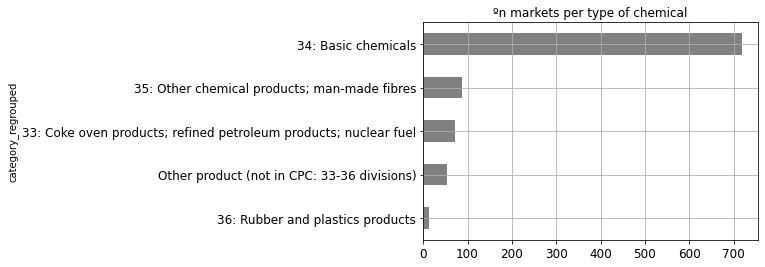

In [35]:
regrouped_cat = []
for item in df_analysis.index:
    if str(df_analysis.referenceProduct_CPCclass[item]).startswith("33"):
        regrouped_cat.append(
            "33: Coke oven products; refined petroleum products; nuclear fuel"
        )
    elif str(df_analysis.referenceProduct_CPCclass[item]).startswith("34"):
        regrouped_cat.append("34: Basic chemicals")
    elif str(df_analysis.referenceProduct_CPCclass[item]).startswith("35"):
        regrouped_cat.append("35: Other chemical products; man-made fibres")
    elif str(df_analysis.referenceProduct_CPCclass[item]).startswith("36"):
        regrouped_cat.append("36: Rubber and plastics products")
    else:
        regrouped_cat.append("Other product (not in CPC: 33-36 divisions)")

try:
    df_analysis.insert(1, "category_regrouped", regrouped_cat, allow_duplicates=False)
except:
    df_analysis.drop("category_regrouped", axis=1, inplace=True)
    df_analysis.insert(1, "category_regrouped", regrouped_cat)


# (!) update the list of non-method column labels
lst_metadata = list(filter(lambda a: a != "category_regrouped", lst_metadata))
lst_metadata.insert(1, "category_regrouped")
print("Updated **df_analysis** dataframe is of {} shape.\n".format(df_analysis.shape))
df_analysis.sample(2)

internal_funcs.plot_categories(
    df_in=df_analysis,
    groupby="category_regrouped",    
    color="gray", 
    fontsize=12,
    cutoff_value=8,
)

In [36]:
# df_analysis[
#     df_analysis.category_regrouped.isin(
#         [
# #             "36: Rubber and plastics products",
#             "Other product (not in CPC: 33-36 divisions)",
#         ]
#     )
# ]

Created **df_base_CPC33to36** dataframe is of (892, 39) shape.

category_regrouped
34: Basic chemicals                                                 719
35: Other chemical products; man-made fibres                         88
33: Coke oven products; refined petroleum products; nuclear fuel     71
36: Rubber and plastics products                                     14
dtype: int64
Total:  892

Shares in % for  category_regrouped
33: Coke oven products; refined petroleum products; nuclear fuel     7.96
34: Basic chemicals                                                 80.61
35: Other chemical products; man-made fibres                         9.87
36: Rubber and plastics products                                     1.57
dtype: float64


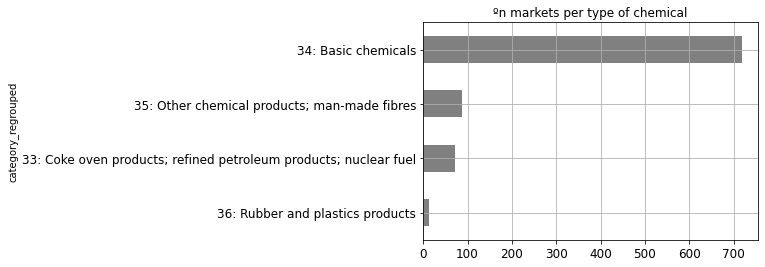

In [37]:
# drop all activities not from CPC 33-36
df_base_CPC33to36 = filter_dataframe(
    df_analysis,
    col_name="category_regrouped",
    filter_out=[
        "Other product (not in CPC: 33-36 divisions)",
#         "36: Rubber and plastics products",
    ],
)
print(
    "Created **df_base_CPC33to36** dataframe is of {} shape.\n".format(
        df_base_CPC33to36.shape
    )
)
# df_base_CPC33to36.sample(3)

internal_funcs.plot_categories(
    df_in=df_base_CPC33to36,
    groupby="category_regrouped",
    color="gray",
    fontsize=12,
    cutoff_value=8,
)

category_regrouped
34: Basic chemicals                                                 719
35: Other chemical products; man-made fibres                         88
33: Coke oven products; refined petroleum products; nuclear fuel     71
36: Rubber and plastics products                                     14
dtype: int64
Total:  892

Shares in % for  category_regrouped
33: Coke oven products; refined petroleum products; nuclear fuel     7.96
34: Basic chemicals                                                 80.61
35: Other chemical products; man-made fibres                         9.87
36: Rubber and plastics products                                     1.57
dtype: float64


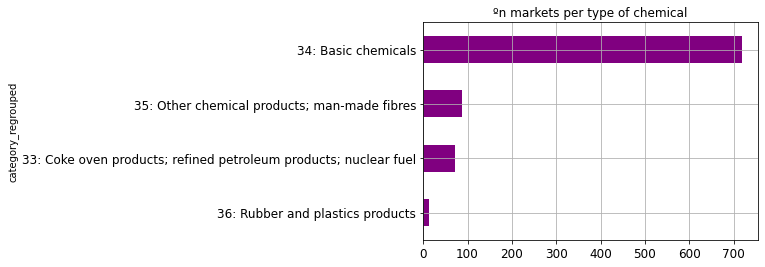

In [38]:
internal_funcs.plot_categories(
    df_base_CPC33to36,
    groupby="category_regrouped",
    cutoff_value=0,
    color="purple",
    fontsize=12,
)

category_regrouped
Organic chemical      441
Other chemical        235
Inorganic chemical    216
dtype: int64
Total:  892

Shares in % for  category_regrouped
Inorganic chemical    24.22
Organic chemical      49.44
Other chemical        26.35
dtype: float64


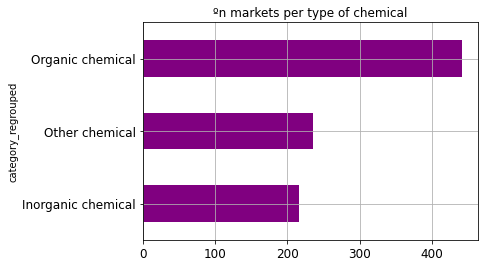

In [39]:
regrouped_cat = []
for item in df_base_CPC33to36.index:
    if str(df_base_CPC33to36.referenceProduct_CPCclass[item]).startswith(
        ("331", "332", "333", "334", "335", "341", "343", "347", "352", "36")
    ):
        regrouped_cat.append("Organic chemical")
    elif str(df_base_CPC33to36.referenceProduct_CPCclass[item]).startswith(("342", "344")):
        regrouped_cat.append("Inorganic chemical")
    else:
        regrouped_cat.append("Other chemical")


try:
    df_base_CPC33to36.insert(1, "category_regrouped", regrouped_cat, allow_duplicates=False)
except:
    df_base_CPC33to36.drop("category_regrouped", axis=1, inplace=True)
    df_base_CPC33to36.insert(1, "category_regrouped", regrouped_cat)


# (!) update the list of non-method column labels
lst_metadata = list(filter(lambda a: a != "category_regrouped", lst_metadata))
lst_metadata.insert(1, "category_regrouped")

df_base_CPC33to36.sample(2)

internal_funcs.plot_categories(
    df_base_CPC33to36,
    groupby="category_regrouped",
    cutoff_value=0,
    color="purple",
    fontsize=12,
)

In [40]:
print(
    "before creating new GLO markets, there are {} GLO markets with FU=1kg belonging to CPC 33-36 in the database.".format(
        df_base_CPC33to36[
            (df_base_CPC33to36.geo == "GLO")
            &
            (df_base_CPC33to36.referenceProductUnit == "kg")
        ].shape[0]
    )
)

before creating new GLO markets, there are 469 GLO markets with FU=1kg belonging to CPC 33-36 in the database.


In [41]:
prueba = list(df_base_CPC33to36[
            (df_base_CPC33to36.geo != "GLO")
            &
            (df_base_CPC33to36.referenceProductUnit == "kg")
        ].referenceProduct.unique())
prueba2 = list(df_base_CPC33to36[
            (df_base_CPC33to36.geo == "GLO")
            &
            (df_base_CPC33to36.referenceProductUnit == "kg")
        ].referenceProduct.unique())

In [42]:
# [i for i in prueba2 if i in prueba]

In [43]:
# df_base_CPC33to36[df_base_CPC33to36.referenceProduct.isin(["Diesel", "Diesel, low-sulfur"])]

In [44]:
df_base_CPC33to36.columns

Index(['Activity', 'category_regrouped', 'activity_comment', 'type',
       'referenceProduct', 'category', 'inline_comment', 'geo',
       'activity_ISICclass', 'activity_ecoSpold01class', 'technologyLevel',
       'referenceProductAmount', 'referenceProductUnit',
       'referenceProduct_prodVolume', 'referenceProduct_prodVolumeComment',
       'referenceProduct_price', 'referenceProduct_priceUnit',
       'referenceProduct_priceComment', 'referenceProduct_casNumber',
       'referenceProduct_CPCclass', 'activity_generalComment',
       'sourceFilename', 'pubchem_match', 'num_matches', 'MF', 'MW', 'iupac',
       'complexity', 'synonyms',
       '('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')',
       '('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')',
       '('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')',
       '('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')',
       '('PBs-LCIA (baseline) V0.

In [45]:
%%time
# WHAT ARE THE OTHER CHEMICALS? DO THEY BELONG TO ORGANIC OR INORGANIC???
# CHECK LATER!

df_toprint = df_base_CPC33to36[df_base_CPC33to36.category_regrouped == "Other chemical"][
    [
        "referenceProduct",
        "MF",
        "category_regrouped",
        "referenceProduct_CPCclass",
        "category",
        "Activity",
    ]
]

outdir = set_outputs_dir(use_default=True) # set to default "..\data\interim"
flname = "CPC33to36_other_chemicals.xlsx"
rdme = make_readme_info(flname, "Chemicals alternatively classifed as 'other'."
            "The chemicals have to be checked and probably moved to organic or inorganic...")
w_excel(
    path_to_file=outdir,
    filename=flname,
    dict_data_to_write={"sheet1": df_toprint},
    readme_info=('readme', rdme)
)
df_toprint.sample(3)

File: CPC33to36_other_chemicals.xlsx successfully created in 
C:\Users\ViteksPC\Documents\00-ETH_projects\17-LCIA_methods_analysis\data\interim
Wall time: 20.8 s


referenceProduct   MF  \
905  Uranium, enriched 4%, in fuel element for ligh...    U   
348                             Frit, for ceramic tile  NaN   
52                          Activated carbon, granular    C   

    category_regrouped                          referenceProduct_CPCclass  \
905     Other chemical  33620: Uranium enriched in U235 and its compou...   
348     Other chemical   35110: Paints and varnishes and related products   
52      Other chemical              35499: Other chemical products n.e.c.   

                          category  \
905  Fuels\Uranium\Enriched\Market   
348  Construction\Coverings\Market   
52        Chemicals\Organic\Market   

                                              Activity  
905  Uranium, enriched 4%, in fuel element for ligh...  
348  Frit, for ceramic tile {GLO}| market for | APO...  
52   Activated carbon, granular {GLO}| market for a...

In [46]:
# checking numbers

# df_base_CPC33to36[
#     (df_base_CPC33to36.geo != "GLO")
#     & 
#     (df_base_CPC33to36.referenceProductUnit == "kg")
# ].shape

# 414 NON GLO MARKETS WITH FU "KG" ARE COMBINED INTO 192 NEW GLO MARKETS BELOW!!!

#### -- export to excel (activate if required)

In [47]:
# ## Export dataframe to excel
# excelName = "df_base_CPC33to36.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Filtered dataframe includes only GLO chemical markets with FU = 1kg "
#     "which pertain to CPC divisions 33, 34 , 35 or 36. "
#     "[This df includes the outliers and the chemicals w/o identified chemical properties, "
#     "both of which are removed in df_clean]"
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_base_CPC33to35}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

### - Create mass allocated GLO markets from non-GLO markets
<div class="alert alert-block alert-info">
created: <strong>df_analysis_extended</strong>
</div>

Created **df_analysis_extended** dataframe is of (1088, 39) shape.
category_regrouped
Organic chemical      543
Other chemical        278
Inorganic chemical    267
dtype: int64
Total:  1088

Shares in % for  category_regrouped
Inorganic chemical    24.54
Organic chemical      49.91
Other chemical        25.55
dtype: float64


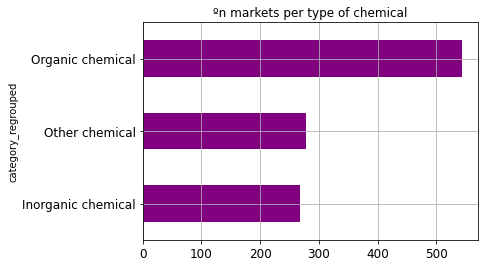

In [48]:
df_analysis_extended = create_glo_market(
    df_in=df_base_CPC33to36,
    columns_to_allocate=lst_methods,
    activity_column="Activity",
    refprod_column="referenceProduct",
    geo_column="geo",
    prodvol_column="referenceProduct_prodVolume",
    comment_column="activity_generalComment",
)

print("Created **df_analysis_extended** dataframe is of {} shape.".format(df_analysis_extended.shape))
df_analysis_extended.tail(2)

internal_funcs.plot_categories(
    df_analysis_extended,
    groupby="category_regrouped",
    cutoff_value=0,
    color="purple",
    fontsize=12,
)

#### Checks!

In [49]:
filter_dataframe(
    df_in=df_analysis_extended,
    col_name="referenceProduct",
    filter_in=comp_added_manually,
#     filter_in=["Diesel"],
    exact_match=True,
)

# list(df_analysis_extended[df_analysis_extended.Activity=="Diesel, combined to GLO market"].activity_generalComment)

Activity category_regrouped  \
846   Liquefied petroleum gas {CH}| market for | APO...   Organic chemical   
847   Liquefied petroleum gas {RoW}| market for | AP...   Organic chemical   
1076    Liquefied petroleum gas, combined to GLO market   Organic chemical   
840                 Kerosene {CH}| market for | APOS, S   Organic chemical   
841   Kerosene {Europe without Switzerland}| market ...   Organic chemical   
842                Kerosene {RoW}| market for | APOS, S   Organic chemical   
1074                   Kerosene, combined to GLO market   Organic chemical   
824                   Diesel {CH}| market for | APOS, S   Organic chemical   
825   Diesel {Europe without Switzerland}| market fo...   Organic chemical   
826                  Diesel {RoW}| market for | APOS, S   Organic chemical   
1069                     Diesel, combined to GLO market   Organic chemical   
827       Diesel, low-sulfur {CH}| market for | APOS, S   Organic chemical   
828   Diesel, low-sulfur {Europe without Switzerland...   Organic chemical   
829      Diesel, low-sulfur {RoW}| market for | APOS, S   Organic chemical   
1070         Diesel, low-sulfur, combined to GLO market   Organic chemical   
710           Xylene {RER}| market for xylene | APOS, S   Organic chemical   
711           Xylene {RoW}| market for xylene | APOS, S   Organic chemical   
1040                     Xylene, combined to GLO market   Organic chemical   
864       Petrol, low-sulfur {CH}| market for | APOS, S   Organic chemical   
865   Petrol, low-sulfur {Europe without Switzerland...   Organic chemical   
866      Petrol, low-sulfur {RoW}| market for | APOS, S   Organic chemical   
1079         Petrol, low-sulfur, combined to GLO market   Organic chemical   

                                       activity_comment      type  \
846   The LPG production mix represents the average ...  Products   
847   The LPG production mix represents the average ...  Products   
1076                                               None  Products   
840   [This dataset was already contained in the eco...  Products   
841   Inventory for the distribution of petroleum pr...  Products   
842   Inventory for the distribution of petroleum pr...  Products   
1074                                               None  Products   
824   Inventory for the distribution of petroleum pr...  Products   
825   [This dataset was already contained in the eco...  Products   
826   [This dataset was already contained in the eco...  Products   
1069                                               None  Products   
827   [This dataset was already contained in the eco...  Products   
828   Inventory for the distribution of petroleum pr...  Products   
829   Inventory for the distribution of petroleum pr...  Products   
1070                                               None  Products   
710   A regional market for Europe [RER] is motivate...  Products   
711   Production volume: 23718000000 kgIncluded a...  Products   
1040                                               None  Products   
864   [This dataset was already contained in the eco...  Products   
865   [This dataset was already contained in the eco...  Products   
866   [This dataset was already contained in the eco...  Products   
1079                                               None  Products   

             referenceProduct                         category  \
846   Liquefied petroleum gas  Fuels\Oil\Propane/butane\Market   
847   Liquefied petroleum gas  Fuels\Oil\Propane/butane\Market   
1076  Liquefied petroleum gas  Fuels\Oil\Propane/butane\Market   
840                  Kerosene        Fuels\Oil\Kerosene\Market   
841                  Kerosene        Fuels\Oil\Kerosene\Market   
842                  Kerosene        Fuels\Oil\Kerosene\Market   
1074                 Kerosene        Fuels\Oil\Kerosene\Market   
824                    Diesel          Fuels\Oil\Diesel\Market   
825                    Diesel          Fuels\Oil\Diesel\Market   
826 

#### -- export to excel (activate if required)

In [50]:
# ## Export dataframe to excel
# excelName = "df_to_analyze_extended_GLOmarkets.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Dataframe similar to df_to_analyze.xlsx [(selected) metadata of chemical markets and scores for multiple LCIA methods], but with additional GLO chemical markets, obtained from mass allocation of respective non-GLO markets.",
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_analysis_extended}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

#### Checks

In [51]:
# lst_all_method_labels

In [52]:
# Check if items in potentially duplicated columns are the same
any(
    ~(df_master_raw.shortName_geo == df_master_raw.geo)
)  # any not equal items in both columns?
any(
    ~(df_master_raw.fullName_SimaPro == df_master_raw.Activity)
)  # any not equal items in both columns?
any(
    ~(df_master_raw.unit == df_master_raw.referenceProductUnit)
)  # any not equal items in both columns?
any(
    ~(df_master_raw.amount == df_master_raw.referenceProductAmount)
)  # any not equal items in both columns?

False

In [53]:
# checks: are the column values identical? ---> redundant
all(df_master_raw.unit == df_master_raw.referenceProductUnit)

True

In [54]:
# filter_dataframe(df_master_raw, 'unit_intExchange', filter_out=['kg'])

## Created dfs to work with: `df_base_full` and `df_base_full_wCAS`

#### create df_base only with GLO markets and individual FU=kg

Created **df_base** dataframe is of (668, 39) shape.

category_regrouped
Organic chemical      320
Other chemical        183
Inorganic chemical    165
dtype: int64
Total:  668

Shares in % for  category_regrouped
Inorganic chemical    24.7
Organic chemical      47.9
Other chemical        27.4
dtype: float64


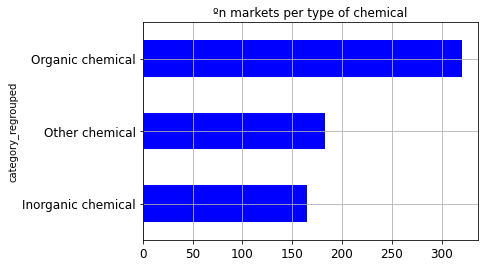

In [55]:
df_base = df_analysis_extended[
    (df_analysis_extended.geo == "GLO")
    & (df_analysis_extended.referenceProductUnit == "kg")
]# .shape


# # Group by shortName_geo_SP -> filter by GLO -> Filter "unit" by "kg"
# df_base = _filter_by_geo_and_FU(
# #     df=df_analysis,
#     df=df_analysis_extended,
#     geo="GLO", 
#     FU="kg"
# )
print("Created **df_base** dataframe is of {} shape.\n".format(df_base.shape))
# df_base

# Grouping by 'category' and ploting the size of each group on a barh plot (in one line)
internal_funcs.plot_categories(
    df_in=df_base,
    groupby="category_regrouped",   
    color="blue", 
    fontsize=12,
    cutoff_value=8,
)

In [56]:
# Products excluded from the analysis
internal_funcs.excluded_products(
    df_raw=df_analysis_extended, # or =df_analysis_extended, (both have the same nº of unique products)
    df_filtered=df_base
)

676 unique reference products in df_raw
668 unique reference products in df_filtered
-------------------------
8 not included products
(because they don't satisfy the filtering criteria): 



geo unit
product                                                     
Green manure, organic, until February                CH   ha
Green manure, Swiss integrated production, unti...  GLO   ha
Green manure, Swiss integrated production, unti...  GLO   ha
Green manure, Swiss integrated production, unti...  GLO   ha
Green manure, Swiss integrated production, unti...  GLO   ha
Green manure, organic, until April                  GLO   ha
Green manure, organic, until January                GLO   ha
Green manure, organic, until March                  GLO   ha

#### add transgression levels (TLs) to df_base
<div class="alert alert-block alert-warning">
created: <strong>df_base_full and df_base_full_wCAS</strong>  
</div> 

In [57]:
# correct methods name for TLs... add lst_methods_TLs
lst_methods_TLs = lst_methods_TLs = ["TL in " + sub for sub in lst_methods[1:]]
lst_methods_TLs

["TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"]

##### create `df_base_full` with ALL activities

In [58]:
df_base_full = pd.concat(
    [
        df_base,
        calculate_TL_PBs(
            df_base,
            method_labels=lst_methods[1:],
            price_column="referenceProduct_price",
            GVA_world = 7.38e13, # in 2018
            correctGVA=None,
#             correctGVA="sales",
#             correctGVA="purchases",
#             share_of_SOS=0.0689, # aggregated shares of 4 sectors (C19-22) using GGG method
#             share_of_SOS=0.0237, # only C20 sector using GGG method
#             share_of_SOS=0.0274, # aggregated shares of 4 sectors (C19-22) using WIOD with L inverse
#             share_of_SOS=0.0076, # only C20 sector using WIOD with L inverse
        ).add_prefix("TL in "),
    ],
    axis=1,
)
print("Created **df_base_full** dataframe is of {} shape.\n".format(df_base_full.shape))
df_base_full.tail(5)

Created **df_base_full** dataframe is of (668, 48) shape.



Activity  category_regrouped  \
1083       Uranium hexafluoride, combined to GLO market      Other chemical   
1084  Diethyl ether, without water, in 99.95% soluti...    Organic chemical   
1085      Silicon tetrachloride, combined to GLO market  Inorganic chemical   
1086             Sodium formate, combined to GLO market    Organic chemical   
1087           Trichloropropane, combined to GLO market    Organic chemical   

     activity_comment      type  \
1083             None  Products   
1084             None  Products   
1085             None  Products   
1086             None  Products   
1087             None  Products   

                                       referenceProduct  \
1083                               Uranium hexafluoride   
1084  Diethyl ether, without water, in 99.95% soluti...   
1085                              Silicon tetrachloride   
1086                                     Sodium formate   
1087                                   Trichloropropane   

                           category inline_comment  geo  \
1083  Fuels\Uranium\Enriched\Market           None  GLO   
1084       Chemicals\Organic\Market           None  GLO   
1085     Chemicals\Inorganic\Market           None  GLO   
1086       Chemicals\Organic\Market           None  GLO   
1087       Chemicals\Organic\Market           None  GLO   

                           activity_ISICclass activity_ecoSpold01class  \
1083  2420a: Smelting and refining of uranium                      NaN   
1084      2011:Manufacture of basic chemicals                      NaN   
1085      2011:Manufacture of basic chemicals                      NaN   
1086      2011:Manufacture of basic chemicals                      NaN   
1087      2011:Manufacture of basic chemicals                      NaN   

      technologyLevel  referenceProductAmount referenceProductUnit  \
1083              NaN                       1                   kg   
1084              NaN                       1                   kg   
1085              NaN                       1                   kg   
1086              0.0                       1                   kg   
1087              NaN                       1                   kg   

      referenceProduct_prodVolume referenceProduct_prodVolumeComment  \
1083                 5.880392e+07                               None   
1084                 1.889956e+07                               None   
1085                 3.764650e+08                               None   
1086                 3.572024e+09                               None   
1087                 2.060000e+07                               None   

      referenceProduct_price referenceProduct_priceUnit  \
1083                  22.900                    EUR2005   
1084                   1.120                    EUR2005   
1085                  13.800                    EUR2005   
1086                   0.466                    EUR2005   
1087                   0.954                    EUR2005   

     referenceProduct_priceComment referenceProduct_casNumber  \
1083                          None                        NaN   
1084                          None                    60-29-7   
1085                          None                 10026-04-7   
1086                          None                   141-53-7   
1087                          None                000096-18-4   

                              referenceProduct_CPCclass  \
1083  33620: Uranium enriched in U235 and its compou...   
1084  34170: Ethers, alcohol peroxides, ether peroxi...   
1085              342: Basic inorganic chemicals n.e.c.   
1086  34140: Carboxylic acids and their anhydrides, ...   
1087                       341: Basic organic chemicals   

                                activity_generalComment sourceFilename  \
1083  Combined activity, mass allocated from CN, RoW...           None   
1084  Combined activity, mass allocated from RoW loc...           None   
1085  Combined activity, mass

In [59]:
# convert prices from EUR2005 to USD2018
# using this unit the TLs were calculated !!!
PPI_2018 = 104.5 # Producer Price Index from Eurostat
PPI_2005 = 86.0  # Producer Price Index from Eurostat
USD_per_EUR_2018 = 1.1811 # average exchange rate EUR to USD in 2018

df_base_full.referenceProduct_price = (df_base_full.referenceProduct_price * PPI_2018 / PPI_2005) * USD_per_EUR_2018
df_base_full.referenceProduct_priceUnit = "USD2018"
df_base_full.sample(2)

Activity  category_regrouped  \
1039  Xenon, gaseous, combined to GLO market  Inorganic chemical   
293       Helium {GLO}| market for | APOS, S  Inorganic chemical   

                                       activity_comment      type  \
1039                                               None  Products   
293   Production volume: 29865000 kgIncluded acti...  Products   

     referenceProduct                category  \
1039   Xenon, gaseous  Chemicals\Gases\Market   
293            Helium  Chemicals\Gases\Market   

                            inline_comment  geo  \
1039                                  None  GLO   
293   Production Volume Amount: 29865000  GLO   

                       activity_ISICclass activity_ecoSpold01class  \
1039  2011:Manufacture of basic chemicals                      NaN   
293   2011:Manufacture of basic chemicals     chemicals/inorganics   

      technologyLevel  referenceProductAmount referenceProductUnit  \
1039              NaN                       1                   kg   
293               0.0                       1                   kg   

      referenceProduct_prodVolume referenceProduct_prodVolumeComment  \
1039                 1.187648e+03                               None   
293                  2.986500e+07                                NaN   

      referenceProduct_price referenceProduct_priceUnit  \
1039              116.392598                    USD2018   
293                11.954998                    USD2018   

                          referenceProduct_priceComment  \
1039                                               None   
293   Calculated based on inputs: The price of the p...   

     referenceProduct_casNumber  \
1039                007440-63-3   
293                   7440-59-7   

                              referenceProduct_CPCclass  \
1039  34231: Chemical elements n.e.c.; inorganic aci...   
293   34231: Chemical elements n.e.c.; inorganic aci...   

                                activity_generalComment  \
1039  Combined activity, mass allocated from RER, Ro...   
293                                                 NaN   

                                         sourceFilename pubchem_match  \
1039                                               None       by NAME   
293   22003_ae7c298c-0e3f-48f5-bdea-38d7cac891d5_afa...        by CAS   

      num_matches  MF        MW   iupac  complexity  \
1039            1  Xe  131.2900   xenon         0.0   
293             1  He    4.0026  helium         0.0   

                                               synonyms  \
1039  ['7440-63-3', 'Xe', 'Xenon', 'xenon(0)', 'UNII...   
293   ['7440-59-7', 'He', 'Helium', 'Atomic helium',...   

      ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
1039                                        1016.475210            
293                                            8.753025            

      ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
1039                                       2.500909e-08                            
293                                        1.751650e-10                            

      ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
1039                                       3.440091e-10                            
293                                        2.399709e-12                            

      ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
1039                                       5.244072e-12                      
293                                        4.822510e-14                      

      ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
1039                                       7.642142e-11                      
293                                        5.352541e-13                      

      ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')  \
1039                                       8

category_regrouped
Organic chemical      320
Other chemical        183
Inorganic chemical    165
dtype: int64
Total:  668

Shares in % for  category_regrouped
Inorganic chemical    24.7
Organic chemical      47.9
Other chemical        27.4
dtype: float64


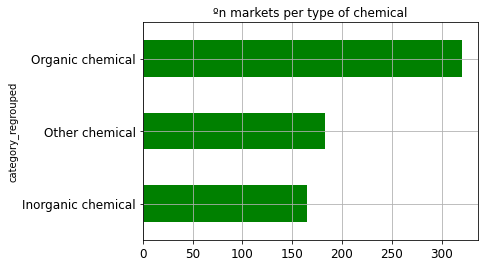

In [60]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)
internal_funcs.plot_categories(
    df_in=df_base_full,
    groupby="category_regrouped",
    color="green",
    fontsize=12,
)

In [61]:
df_base_full[df_base_full.referenceProduct == 'Cyclic N-compound']

Activity category_regrouped  \
181  Cyclic N-compound {GLO}| market for | APOS, S     Other chemical   

                                      activity_comment      type  \
181  In this market, expert judgement was used to d...  Products   

      referenceProduct                     category  \
181  Cyclic N-compound  Chemicals\Pesticides\Market   

                                  inline_comment  geo  \
181  Production Volume Amount: 7089427.6424581  GLO   

                                    activity_ISICclass  \
181  2021:Manufacture of pesticides and other agroc...   

                        activity_ecoSpold01class  technologyLevel  \
181  agricultural means of production/pesticides              0.0   

     referenceProductAmount referenceProductUnit  referenceProduct_prodVolume  \
181                       1                   kg                 7.089428e+06   

    referenceProduct_prodVolumeComment  referenceProduct_price  \
181                                NaN                8.223546   

    referenceProduct_priceUnit  \
181                    USD2018   

                         referenceProduct_priceComment  \
181  Calculated based on inputs: The price of the p...   

    referenceProduct_casNumber  \
181                        NaN   

                             referenceProduct_CPCclass  \
181  3466: Insecticides, fungicides, herbicides and...   

                               activity_generalComment  \
181  In this market, expert judgement was used to d...   

                                        sourceFilename pubchem_match  \
181  21056_7f9fbb48-a135-4010-849c-4ad695d3ad62_d00...      No match   

     num_matches   MF  MW iupac  complexity synonyms  \
181            0  NaN NaN   NaN         NaN      NaN   

     ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
181                                          15.364283            

     ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
181                                       3.584423e-10                            

     ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
181                                       4.939219e-12                            

     ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
181                                       4.429804e-13                      

     ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
181                                       1.095305e-12                      

     ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')  \
181                                       2.815296e-12                   

     ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')  \
181                                       4.051603e-12                   

     ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')  \
181                                       2.112249e-15                   

     ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')  \
181                                       2.706912e-11                 

     ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')  \
181                                       3.686014e-12                                         

     TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
181                                          44.677001                                  

     TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
181                                          44.325694                                  

     TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
181                                           0.274166                            

     TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
181                                          14.245685       

In [62]:
# ## Export dataframe to excel
# excelName = "df_base_full.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Dataframe df_base_full - all GLO markets with PBs and TLs.",
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_base_full}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

##### create `df_base_full_wCAS` ONLY with activities detected in PubChem

In [63]:
df_base_full_wCAS = df_base_full[df_base_full.num_matches != 0]

print("Created **df_base_full_wCAS** dataframe is of {} shape.\n".format(df_base_full_wCAS.shape))
df_base_full_wCAS.sample(2)

Created **df_base_full_wCAS** dataframe is of (492, 48) shape.



Activity  category_regrouped  \
45   Alkylbenzene sulfonate, linear, petrochemical ...    Organic chemical   
974           Nitrogen, liquid, combined to GLO market  Inorganic chemical   

                                      activity_comment      type  \
45   In this market, expert judgement was used to d...  Products   
974                                               None  Products   

                                  referenceProduct  \
45   Alkylbenzene sulfonate, linear, petrochemical   
974                               Nitrogen, liquid   

                                     category  \
45   Chemicals\Washing agents\Tensides\Market   
974          Chemicals\Gases\Liquified\Market   

                             inline_comment  geo  \
45   Production Volume Amount: 2600000000  GLO   
974                                    None  GLO   

                                    activity_ISICclass  \
45   2023:Manufacture of soap and detergents, clean...   
974                2011:Manufacture of basic chemicals   

    activity_ecoSpold01class  technologyLevel  referenceProductAmount  \
45   washing agents/tensides              0.0                       1   
974                      NaN              0.0                       1   

    referenceProductUnit  referenceProduct_prodVolume  \
45                    kg                 2.600000e+09   
974                   kg                 2.614719e+11   

    referenceProduct_prodVolumeComment  referenceProduct_price  \
45                                 NaN                1.155315   
974                               None                0.088263   

    referenceProduct_priceUnit  \
45                     USD2018   
974                    USD2018   

                         referenceProduct_priceComment  \
45   Calculated based on inputs: The price of the p...   
974                                               None   

    referenceProduct_casNumber  \
45                  42615-29-2   
974                007727-37-9   

                             referenceProduct_CPCclass  \
45                        341: Basic organic chemicals   
974  34210: Hydrogen, nitrogen, oxygen, carbon diox...   

                               activity_generalComment  \
45   In this market, expert judgement was used to d...   
974  Combined activity, mass allocated from RER, Ro...   

                                        sourceFilename pubchem_match  \
45   20655_81dbc6ca-3b24-46dc-8a44-1dc489a71cde_290...        by CAS   
974                                               None       by NAME   

     num_matches           MF       MW                                  iupac  \
45             1  C18H29NaO3S  348.500  sodium;4-dodecan-2-ylbenzenesulfonate   
974            1           N2   28.014                     molecular nitrogen   

     complexity                                           synonyms  \
45        370.0  ['Sodium (1-methylundecyl)benzenesulfonate', '...   
974         8.0  ['7727-37-9', 'N', 'Nitrogen', 'Nitrogen gas',...   

     ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
45                                            1.710051            
974                                           0.412275            

     ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
45                                        4.073507e-11                            
974                                       1.015007e-11                            

     ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
45                                        5.440720e-13                            
974                                       1.395625e-13                            

     ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
45                                        5.727820e-15                      
974                                       2.125030e-15                      

     ('PBs-LCIA (baseline) V0.72', 

category_regrouped
Organic chemical      262
Inorganic chemical    151
Other chemical         79
dtype: int64
Total:  492

Shares in % for  category_regrouped
Inorganic chemical    30.69
Organic chemical      53.25
Other chemical        16.06
dtype: float64


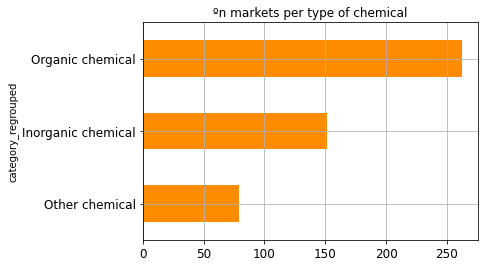

In [64]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)
internal_funcs.plot_categories(
    df_in=df_base_full_wCAS,
    groupby="category_regrouped",
    color="darkorange",
    fontsize=12,
)

## `highlighted_product` list

### research possible highlighted products

In [65]:
lst_known_chemicals = [
    "Toluene",
    "Xylene",
    # Javier's list below
    "Liquefied petroleum gas",  # ok
    "Petrol",  # "Gasoline", # ok
    "Diesel",  # ok
    "Kerosene",  # ok
    "Ethylene",  # ok
    "Propylene",  # ok
    "Benzene",  # ok
    "Synthetic gas",  # FU 1m3
    "Ammonia, liquid",  # ok
    "Methanol",  # ok
    "Sulfuric acid",  # ok
    "Chlorine",  # ok
    "Acetic acid",  # ok
    "Formaldehyde",  # ok
    "Urea",  # ok
    "Ethylene oxide",  # ok
    "Acrylonitrile",  # ok
    "Acetaldehyde",  # ok
    "Polyethylene",  # ok
    "Polypropylene",  # ok
    "Polyvinylchloride",  # ok
    "Hydrogen",  # ok
]

for item in lst_known_chemicals:
    print("Looking for " + item)
    filter_dataframe(
        df_analysis_extended,
        col_name="referenceProduct",
        filter_in=[item],
        print_unique=True,
    )

Looking for Toluene
List of unique items matching your request:
		 ['Toluene, liquid', 'Toluene diisocyanate'] 

Looking for Xylene
List of unique items matching your request:
		 ['Xylene'] 

Looking for Liquefied petroleum gas
List of unique items matching your request:
		 ['Liquefied petroleum gas'] 

Looking for Petrol
List of unique items matching your request:
		 ['Petrol, 4% ETBE additive by volume, with ethanol from biomass', 'Petrol, 5% ethanol by volume from biomass', 'Petroleum coke', 'Petrol, unleaded', 'Petrol, low-sulfur', 'Petrol, two-stroke blend', 'Petrol, 15% ETBE additive by volume, with ethanol from biomass'] 

Looking for Diesel
List of unique items matching your request:
		 ['Diesel', 'Diesel, low-sulfur'] 

Looking for Kerosene
List of unique items matching your request:
		 ['Kerosene'] 

Looking for Ethylene
List of unique items matching your request:
		 ['Ethylene glycol monoethyl ether', 'Ethylene bromide', 'Ethylene, pipeline system', 'Ethylene, average', 'Eth

### selected products

In [66]:
# Exact names only!

highlighted_product = [
    "Sulfuric acid",
    "Kerosene",
    "Diesel, low-sulfur", # or "Diesel",
    "Liquefied petroleum gas",
    "Methanol",
    "Petrol, low-sulfur",
    "Formaldehyde",
    "Chlorine, liquid",
    "Ethylene, average",
    "Propylene",
    "Toluene, liquid",
    "Acetic acid, without water, in 98% solution state",
    "Acetaldehyde",
    "Polyethylene, high density, granulate",
    "Benzene",
    "Ammonia, liquid",
    "Polypropylene, granulate",
    "Ethylene oxide",
    "Polyvinylchloride, bulk polymerised",
    "Hydrogen, liquid",
    "Acrylonitrile",
    "Urea, as N",
    "1-propanol",
    "Acetylene",
    "Chlorotoluron",
    "Methylene diphenyl diisocyanate",
    "Ammonium nitrate, as N",
    "Pyridine",
    "Nylon 6-6",
    "Glyphosate",
    "Para-phenylene diamine",
    "Fluorine, liquid",
    "Adipic acid",
    "Xylene"
]

selected = internal_funcs.find_chemicals(
    df_base_full,
#     df_base_full_wCAS,
    highlighted_product,
    colname="referenceProduct",
)[
    ["Activity"]
    + ["referenceProduct"]
    + ["geo"]
    #     + ["category"]
        + ["category_regrouped"]
    + ["referenceProduct_CPCclass"]
    #     + ["referenceProduct_prodVolume"]
    + ["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"]
    #     + ["complexity"]
        + ["MF"]
    #     lst_metadata
    #     + lst_methods
]

selected[selected.geo == "GLO"].sort_values(
    by="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"
)

Activity  \
1027              Sulfuric acid, combined to GLO market   
1074                   Kerosene, combined to GLO market   
1070         Diesel, low-sulfur, combined to GLO market   
1076    Liquefied petroleum gas, combined to GLO market   
367                Methanol {GLO}| market for | APOS, S   
1079         Petrol, low-sulfur, combined to GLO market   
946                Formaldehyde, combined to GLO market   
919            Chlorine, liquid, combined to GLO market   
1071          Ethylene, average, combined to GLO market   
1081                  Propylene, combined to GLO market   
1031            Toluene, liquid, combined to GLO market   
26    Acetic acid, without water, in 98% solution st...   
1040                     Xylene, combined to GLO market   
23             Acetaldehyde {GLO}| market for | APOS, S   
495   Polyethylene, high density, granulate {GLO}| m...   
821                 Benzene {GLO}| market for | APOS, S   
896             Ammonia, liquid, combined to GLO market   
507   Polypropylene, granulate {GLO}| market for | A...   
942              Ethylene oxide, combined to GLO market   
518   Polyvinylchloride, bulk polymerised {GLO}| mar...   
957            Hydrogen, liquid, combined to GLO market   
41            Acrylonitrile {GLO}| market for | APOS, S   
693              Urea, as N {GLO}| market for | APOS, S   
3                1-propanol {GLO}| market for | APOS, S   
890                   Acetylene, combined to GLO market   
169           Chlorotoluron {GLO}| market for | APOS, S   
970   Methylene diphenyl diisocyanate, combined to G...   
68    Ammonium nitrate, as N {GLO}| market for | APO...   
783                Pyridine {GLO}| market for | APOS, S   
417               Nylon 6-6 {GLO}| market for | APOS, S   
281              Glyphosate {GLO}| market for | APOS, S   
444   Para-phenylene diamine {GLO}| market for | APO...   
945            Fluorine, liquid, combined to GLO market   
44              Adipic acid {GLO}| market for | APOS, S   

                                       referenceProduct  geo  \
1027                                      Sulfuric acid  GLO   
1074                                           Kerosene  GLO   
1070                                 Diesel, low-sulfur  GLO   
1076                            Liquefied petroleum gas  GLO   
367                                            Methanol  GLO   
1079                                 Petrol, low-sulfur  GLO   
946                                        Formaldehyde  GLO   
919                                    Chlorine, liquid  GLO   
1071                                  Ethylene, average  GLO   
1081                                          Propylene  GLO   
1031                                    Toluene, liquid  GLO   
26    Acetic acid, without water, in 98% solution state  GLO   
1040                                             Xylene  GLO   
23                                         Acetaldehyde  GLO   
495               Polyethylene, high density, granulate  GLO   
821                                             Benzene  GLO   
896                                     Ammonia, liquid  GLO   
507                            Polypropylene, granulate  GLO   
942                                      Ethylene oxide  GLO   
518                 Polyvinylchloride, bulk polymerised  GLO   
957                                    Hydrogen, liquid  GLO   
41                                        Acrylonitrile  GLO   
693                                          Urea, as N  GLO   
3                                            1-propanol  GLO   
890                                           Acetylene  GLO   
169                                       Chlorotoluron  GLO   
970                     Methylene diphenyl diisocyanate  GLO   
68                               Ammonium nitrate, as N  GLO   
783                                            Pyridine  GLO   
417                                           Nylon 6-6  GLO 

### -- export to excel (activate if required)

In [67]:
# ## Export dataframe to excel
# excelName = "df_GLO_markets.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Filtered dataframe includes only GLO chemical markets with FU = 1kg",
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_base}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

## Filtering outliers
<div class="alert alert-block alert-info">
use previously created:  <br>
    <strong>df_base_full</strong> - only GLO, kg markets from CPC 33-36  <br>
    <strong>ddf_base_full_wCAS</strong> - only GLO, kg markets from CPC 33-36 with identified chemical properties (could be refined!)
</div>

### apply Mahalanobis Distance method to detect outliers

In [68]:
# df_to_detect_MDm = df_base_full
df_to_detect_MDm = df_base_full_wCAS

(
    df_clean_metNtlNpr_MDm,
    df_outliers_metNtlNpr_MDm,
    more_metNtlNpr_MDm,
) = outlier_detectors.mahalanobis_method(
    df_raw=df_to_detect_MDm[
        lst_methods[0:1]
        + lst_methods[1:]
        + lst_methods_TLs
        + ["referenceProduct_price"]
    ],
    alpha=(1 - 0.95),
)
print("out of", df_to_detect_MDm.shape[0], "items")
print(len(more_metNtlNpr_MDm[0]), "outliers detected")

outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_MDm, df_outliers_metNtlNpr_MDm
)[
    ["referenceProduct"]
    + [lst_methods[0]]
    + [lst_methods_TLs[0]]
    + ["referenceProduct_price"]
]

out of 492 items
44 outliers detected


referenceProduct  \
44                                          Adipic acid   
68                               Ammonium nitrate, as N   
148                                            Charcoal   
171                                         Citric acid   
216                              Dimethyldichlorosilane   
226                                           Dodecanol   
275                        Gallium, semiconductor-grade   
292                                         Heavy water   
317                                              Indium   
343                             Lithium brine, 6.7 % Li   
347                         Lithium hexafluorophosphate   
375                                       Methyl iodide   
457                                           Phosphane   
460          Phosphate rock, as P2O5, beneficiated, wet   
468                           Phosphorus, white, liquid   
573                            Sodium aluminate, powder   
597                                      Sodium nitrate   
652                   Tantalum, powder, capacitor-grade   
659                  Tetrafluoroethylene film, on glass   
660                                 Tetrafluoroethylene   
664                              Titanium tetrachloride   
683                                    Trifluoromethane   
684                                  Trimesoyl chloride   
745   Ethanol, without water, in 95% solution state,...   
746   Ethanol, without water, in 99.7% solution stat...   
764                                           Magnetite   
782                                            Pyrazole   
879   Uranium, enriched 3.0%, in fuel element for li...   
880   Uranium, enriched 3.8%, in fuel element for li...   
881   Uranium, enriched 3.9%, in fuel element for li...   
882   Uranium, enriched 4%, in fuel element for ligh...   
883   Uranium, enriched 4.2%, in fuel element for li...   
921                               Chlorodifluoromethane   
948                                           Glycerine   
965                              Methanol, from biomass   
967                                 Methyl methacrylate   
988                                 Phosphoryl chloride   
1004  Silicon, single crystal, czochralski process, ...   
1025                        Sulfur hexafluoride, liquid   
1033                                   Trichloromethane   
1039                                     Xenon, gaseous   
1052  Ethanol, without water, in 99.7% solution stat...   
1083                               Uranium hexafluoride   
1086                                     Sodium formate   

      ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
44                                            13.733554            
68                                             7.993117            
148                                            1.430764            
171                                            6.148700            
216                                            6.145469            
226                                            4.203904            
275                                          145.732450            
292                                         1616.912100            
317                                          215.666280            
343                                            0.049004            
347                                           19.358377            
375                                            6.502977            
457                                           19.915886            
460                                            0.326933            
468                                           12.060422            
573                                            3.195460            
597                                            4.735512            
652                                          296.491450            
659                                          128.156740            
660                    

In [80]:
# df_base_full_wCAS[
#     df_base_full_wCAS["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"]
#     > 1000
# ]

category_regrouped
Organic chemical      248
Inorganic chemical    137
Other chemical         63
dtype: int64
Total:  448

Shares in % for  category_regrouped
Inorganic chemical    30.58
Organic chemical      55.36
Other chemical        14.06
dtype: float64


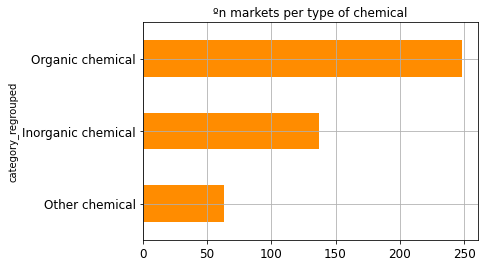

In [69]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)

df_base_full_wCAS_woOutliersMDk20a5 = outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_MDm, df_clean_metNtlNpr_MDm
)

internal_funcs.plot_categories(
    df_in=df_base_full_wCAS_woOutliersMDk20a5,
    groupby="category_regrouped",
    color="darkorange",
    fontsize=12,
)

### apply Robust Mahalanobis Distance method to detect outliers

In [70]:
# df_to_detect_RMDm = df_base_full
df_to_detect_RMDm = df_base_full_wCAS

(
    df_clean_metNtlNpr_RMDm,
    df_outliers_metNtlNpr_RMDm,
    more_metNtlNpr_RMDm,
) = outlier_detectors.robust_mahalanobis_method(
    df_to_detect_RMDm[
        #         lst_methods
        #         +
        lst_methods_TLs
        #         + ["referenceProduct_price"]
    ],
    alpha=(1 - 0.95),
    support_fraction=None,
)
print("out of", df_to_detect_RMDm.shape[0], "items")
print(len(more_metNtlNpr_RMDm[0]), "outliers detected")

outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_RMDm, df_outliers_metNtlNpr_RMDm
)[
    ["referenceProduct"]
    + [lst_methods[0]]
    + [lst_methods_TLs[0]]
    + ["referenceProduct_price"]
]

out of 492 items
26 outliers detected


referenceProduct  \
44                                          Adipic acid   
68                               Ammonium nitrate, as N   
148                                            Charcoal   
171                                         Citric acid   
216                              Dimethyldichlorosilane   
265   Fluorescent whitening agent, distyrylbiphenyl ...   
292                                         Heavy water   
343                             Lithium brine, 6.7 % Li   
457                                           Phosphane   
460          Phosphate rock, as P2O5, beneficiated, wet   
573                            Sodium aluminate, powder   
597                                      Sodium nitrate   
664                              Titanium tetrachloride   
745   Ethanol, without water, in 95% solution state,...   
746   Ethanol, without water, in 99.7% solution stat...   
764                                           Magnetite   
898                                  Ammonium carbonate   
921                               Chlorodifluoromethane   
948                                           Glycerine   
965                              Methanol, from biomass   
967                                 Methyl methacrylate   
988                                 Phosphoryl chloride   
1025                        Sulfur hexafluoride, liquid   
1033                                   Trichloromethane   
1052  Ethanol, without water, in 99.7% solution stat...   
1086                                     Sodium formate   

      ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
44                                            13.733554            
68                                             7.993117            
148                                            1.430764            
171                                            6.148700            
216                                            6.145469            
265                                           22.586475            
292                                         1616.912100            
343                                            0.049004            
457                                           19.915886            
460                                            0.326933            
573                                            3.195460            
597                                            4.735512            
664                                            2.488499            
745                                            0.882455            
746                                            1.708591            
764                                            0.982376            
898                                            1.605233            
921                                           65.805615            
948                                            3.237595            
965                                            0.631377            
967                                            6.936918            
988                                            4.190658            
1025                                         127.060714            
1033                                           3.498619            
1052                                           1.735400            
1086                                           1.183581            

      TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
44                                            77.620220                                  
68                                           133.582556                                  
148                                           48.939385                                  
171                                          133.706019                                  
216                                           53.629595                                  
265                                          259.926233             

category_regrouped
Organic chemical      253
Inorganic chemical    144
Other chemical         69
dtype: int64
Total:  466

Shares in % for  category_regrouped
Inorganic chemical    30.90
Organic chemical      54.29
Other chemical        14.81
dtype: float64


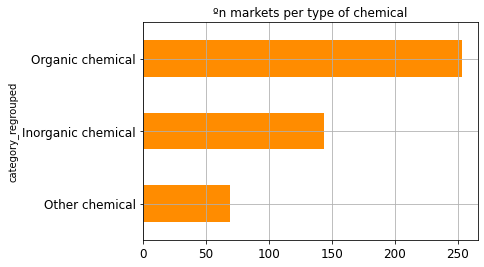

In [71]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)
df_base_full_wCAS_woOutliersRMDk9a5 = outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_RMDm, df_clean_metNtlNpr_RMDm
)
internal_funcs.plot_categories(
    df_in=df_base_full_wCAS_woOutliersRMDk9a5,
    groupby="category_regrouped",
    color="darkorange",
    fontsize=12,
)

activity_ISICclass
2011:Manufacture of basic chemicals                                                 524
2013:Manufacture of plastics and synthetic rubber in primary forms                   81
1920:Manufacture of refined petroleum products                                       59
2021:Manufacture of pesticides and other agrochemical products                       51
2023:Manufacture of soap and detergents, cleaning and polishing preparations, pe     30
2022:Manufacture of paints, varnishes and similar coatings, printing ink and mas     24
2029:Manufacture of other chemical products n.e.c.                                   20
2012:Manufacture of fertilizers and nitrogen compounds                               18
0161:Support activities for crop production                                          13
2011a: Manufacture of nuclear fuels                                                  13
2220:Manufacture of plastics products                                                11
3830:Material

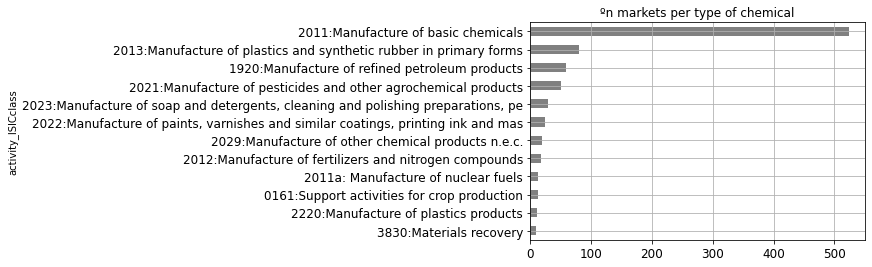

In [72]:
internal_funcs.plot_categories(
#     df_in=df_base_full_wCAS_woOutliersRMDk9a5,
#     df_in=df_analysis,
#         df_in=df_base_full, 
#     df_in=df_base_full_wCAS,
    df_in=df_base_CPC33to36, 
    groupby="activity_ISICclass",
    cutoff_value=10,
    color="gray",
    fontsize=12,
)

In [85]:
# df_base_CPC33to36[df_base_CPC33to36.activity_ISICclass=="1920:Manufacture of refined petroleum products"]

In [73]:
# sorted(df_base_full_wCAS_woOutliersRMDk9a5.activity_ISICclass.unique())
# sorted(df_base_full_wCAS.activity_ISICclass.unique())
# sorted(df_analysis.activity_ISICclass.unique())
sorted(df_base_full.activity_ISICclass.unique())

['0161:Support activities for crop production',
 '0220:Logging',
 '0729:Mining of other non-ferrous metal ores',
 '0891:Mining of chemical and fertilizer minerals',
 '1312:Weaving of textiles',
 '1920:Manufacture of refined petroleum products',
 '19a: Liquid and gaseous fuels from biomass',
 '2011:Manufacture of basic chemicals',
 '2011a: Manufacture of nuclear fuels',
 '2012:Manufacture of fertilizers and nitrogen compounds',
 '2013:Manufacture of plastics and synthetic rubber in primary forms',
 '2021:Manufacture of pesticides and other agrochemical products',
 '2022:Manufacture of paints, varnishes and similar coatings, printing ink and mas',
 '2023:Manufacture of soap and detergents, cleaning and polishing preparations, pe',
 '2029:Manufacture of other chemical products n.e.c.',
 '2030:Manufacture of man-made fibres',
 '20:Manufacture of chemicals and chemical products',
 '2100:Manufacture of pharmaceuticals, medicinal chemical and botanical products',
 '2219:Manufacture of other r

In [74]:
# df_base_full_wCAS_woOutliersRMDk9a5.shape
df_base_full_wCAS.shape

(492, 48)

In [75]:
# df_base_full_wCAS_woOutliersRMDk9a5[
#     df_base_full_wCAS_woOutliersRMDk9a5.activity_ISICclass.isin(
# df_base_full_wCAS[
#     df_base_full_wCAS.activity_ISICclass.isin(
df_base_full[
    df_base_full.activity_ISICclass.isin(
        [
            '0891:Mining of chemical and fertilizer minerals',
#             "2011:Manufacture of basic chemicals", # 361
#             "2011a: Manufacture of nuclear fuels", # 5
#             "2012:Manufacture of fertilizers and nitrogen compounds", # 11
#             "2013:Manufacture of plastics and synthetic rubber in primary forms", # 37
#             "2021:Manufacture of pesticides and other agrochemical products", # 20
#             "2023:Manufacture of soap and detergents, cleaning and polishing preparations, pe", # 7
#             "2029:Manufacture of other chemical products n.e.c.", # 4
#             "20:Manufacture of chemicals and chemical products", # 2
        ]
    )
]#.shape

Activity category_regrouped  \
105  Boric acid, anhydrous, powder {GLO}| market fo...     Other chemical   
127        Calcium borates {GLO}| market for | APOS, S     Other chemical   
459  Phosphate rock, as P2O5, beneficiated, dry {GL...     Other chemical   
460  Phosphate rock, as P2O5, beneficiated, wet {GL...     Other chemical   
624  Soil pH raising agent, as CaCO3 {GLO}| market ...     Other chemical   
630             Stone meal {GLO}| market for | APOS, S     Other chemical   

                                      activity_comment      type  \
105  Production volume: 750000000 kgIncluded act...  Products   
127  Production volume: 16660000000 kgIncluded a...  Products   
459  Production volume: 26705000000 kgIncluded a...  Products   
460  Production volume: 26705000000 kgIncluded a...  Products   
624  Production volume: 158774121530.547 kgInclu...  Products   
630  This product is generally considered to be use...  Products   

                               referenceProduct  \
105               Boric acid, anhydrous, powder   
127                             Calcium borates   
459  Phosphate rock, as P2O5, beneficiated, dry   
460  Phosphate rock, as P2O5, beneficiated, wet   
624             Soil pH raising agent, as CaCO3   
630                                  Stone meal   

                                     category  \
105        Chemicals\Acids (inorganic)\Market   
127                Chemicals\Inorganic\Market   
459                Chemicals\Inorganic\Market   
460                Chemicals\Inorganic\Market   
624  Chemicals\Fertilisers (inorganic)\Market   
630  Chemicals\Fertilisers (inorganic)\Market   

                                   inline_comment  geo  \
105         Production Volume Amount: 750000000  GLO   
127       Production Volume Amount: 16660000000  GLO   
459       Production Volume Amount: 26705000000  GLO   
460       Production Volume Amount: 26705000000  GLO   
624  Production Volume Amount: 158774121530.547  GLO   
630                 Production Volume Amount: 4  GLO   

                                  activity_ISICclass  \
105  0891:Mining of chemical and fertilizer minerals   
127  0891:Mining of chemical and fertilizer minerals   
459  0891:Mining of chemical and fertilizer minerals   
460  0891:Mining of chemical and fertilizer minerals   
624  0891:Mining of chemical and fertilizer minerals   
630  0891:Mining of chemical and fertilizer minerals   

                              activity_ecoSpold01class  technologyLevel  \
105                               chemicals/inorganics              0.0   
127                               chemicals/inorganics              0.0   
459                               chemicals/inorganics              0.0   
460                               chemicals/inorganics              0.0   
624                                 chemicals/organics              0.0   
630  agricultural means of production/mineral ferti...              0.0   

     referenceProductAmount referenceProductUnit  referenceProduct_prodVolume  \
105                       1                   kg                 7.500000e+08   
127                       1                   kg                 1.666000e+10   
459                       1                   kg                 2.670500e+10   
460                       1                   kg                 2.670500e+10   
624                       1                   kg                 1.587741e+11   
630                       1                   kg                 4.000000e+00   

    referenceProduct_prodVolumeComment  referenceProduct_price  \
105                                NaN                1.679153   
127                                NaN                0.631476   
459                                NaN                0.070324   
460                                NaN                0.070324   
624                                NaN                0.167915   
630                                Na

### apply Tukey method to detect outliers (univariate)

In [76]:
# df_to_detect_Tm = df_base_full
df_to_detect_Tm = df_base_full_wCAS

df_clean_tukey, df_outliers_tukey = outlier_detectors.tukey_method_bulk(
    df_to_detect_Tm[lst_methods + lst_methods_TLs + ["referenceProduct_price"]],
    outlier_detection_fence="tight",
)
print("out of", df_to_detect_Tm.shape[0], "items")
print("Tukey univariate method detected:")
for i in df_outliers_tukey.columns:
    print("in ", i, ">>>>> ", df_outliers_tukey[i].count(), "outliers.")

out of 492 items
Tukey univariate method detected:
in  ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq') >>>>>  52 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm') >>>>>  48 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2') >>>>>  52 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU') >>>>>  89 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon') >>>>>  48 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P') >>>>>  86 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N') >>>>>  89 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%') >>>>>  50 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3') >>>>>  65 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss') >>>>>  55 outliers.
in  TL in ('

### apply Mahalanobis Distance method to detect outliers depending on CATEGORY

In [77]:
# chemical_cat = "Organic chemical"
chemical_cat = "Inorganic chemical"
# chemical_cat = "Other chemical"
# df_to_detect_MDmCAT = df_base_full[df_base_full.category_regrouped==chemical_cat]
df_to_detect_MDmCAT = df_base_full_wCAS[
    df_base_full_wCAS.category_regrouped == chemical_cat
]

(
    df_clean_metNtlNpr_MDmCAT,
    df_outliers_metNtlNpr_MDmCAT,
    more_metNtlNpr_MDmCAT,
) = outlier_detectors.mahalanobis_method(
    df_to_detect_MDmCAT[lst_methods + lst_methods_TLs + ["referenceProduct_price"]],
    alpha=(1 - 0.95),
)
print("out of", df_to_detect_MDmCAT.shape[0], "items")
print(len(more_metNtlNpr_MDmCAT[0]), "outliers detected")

outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_MDmCAT, df_outliers_metNtlNpr_MDmCAT
)[
    ["referenceProduct"]
    + [lst_methods[0]]
    + [lst_methods_TLs[0]]
    + ["referenceProduct_price"]
]

# df_clean_metNtlNpr_MDmCAT.sort_values(by="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')").tail(5)

out of 151 items
25 outliers detected


referenceProduct  \
134                                     Calcium nitrate   
275                        Gallium, semiconductor-grade   
292                                         Heavy water   
293                                              Helium   
294                           Helium, crude stockpiling   
317                                              Indium   
350                                             Lithium   
399                                     Neodymium oxide   
468                           Phosphorus, white, liquid   
535                                  Praseodymium oxide   
559                          Silicon, electronics grade   
572          Soda ash, light, crystalline, heptahydrate   
573                            Sodium aluminate, powder   
597                                      Sodium nitrate   
652                   Tantalum, powder, capacitor-grade   
664                              Titanium tetrachloride   
684                                  Trimesoyl chloride   
898                                  Ammonium carbonate   
912                                    Calcium chloride   
913                              Carbon dioxide, liquid   
972   Nitric acid, without water, in 50% solution state   
988                                 Phosphoryl chloride   
1004  Silicon, single crystal, czochralski process, ...   
1025                        Sulfur hexafluoride, liquid   
1039                                     Xenon, gaseous   

      ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
134                                            3.132682            
275                                          145.732450            
292                                         1616.912100            
293                                            8.753025            
294                                            1.952384            
317                                          215.666280            
350                                           48.094069            
399                                           25.676907            
468                                           12.060422            
535                                           24.103360            
559                                           94.666286            
572                                            0.472444            
573                                            3.195460            
597                                            4.735512            
652                                          296.491450            
664                                            2.488499            
684                                            8.283052            
898                                            1.605233            
912                                            0.714434            
913                                            0.880880            
972                                            2.925314            
988                                            4.190658            
1004                                         296.856570            
1025                                         127.060714            
1039                                        1016.475210            

      TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
134                                           54.344039                                  
275                                            8.076758                                  
292                                           46.942157                                  
293                                           15.018336                                  
294                                           68.282645                                  
317                                            4.375517                                  
350                                           17.656293                                  
399            

In [78]:
df_base_full_wCAS.loc[162:163]

Empty DataFrame
Columns: [Activity, category_regrouped, activity_comment, type, referenceProduct, category, inline_comment, geo, activity_ISICclass, activity_ecoSpold01class, technologyLevel, referenceProductAmount, referenceProductUnit, referenceProduct_prodVolume, referenceProduct_prodVolumeComment, referenceProduct_price, referenceProduct_priceUnit, referenceProduct_priceComment, referenceProduct_casNumber, referenceProduct_CPCclass, activity_generalComment, sourceFilename, pubchem_match, num_matches, MF, MW, iupac, complexity, synonyms, ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq'), ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm'), ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2'), ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU'), ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon'), ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P'), ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N'), ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%'), ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3'), ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss'), TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm'), TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2'), TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU'), TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon'), TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P'), TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N'), TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%'), TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3'), TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')]
Index: []

# Insight from the data

In [79]:
df_for_insights = df_base_full_wCAS_woOutliersRMDk9a5

In [80]:
lst_methods_TLs

["TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"]

In [81]:
num_chemicals_tot = df_for_insights.shape[0]
num_chemicals_tot

466

#### * functions

In [82]:
def ecdf(ar):
    """Create df with empirical CDF data.
    
    eCDF - empirical Cumulative Distribution Function
    
    Parameters
    ----------
    ar: 1-D array-like
        Input array, should be 1-D pandas series
    
    Returns
    -------
    df_out: DataFrame
        Dataframe containing the original index of the input data with
        - column, named as passed data, containing ordered input items, 
        - column, named "counts", containing the number of times each unique item appears
        - column, named "cumsum", containing the cumulate sum of counts
        - column, named "Probability", containing the cumulative probability of occurance of each item
    """
    x, indices, counts = np.unique(ar, return_index=True, return_counts=True)
    cusum = np.cumsum(counts)
    prob = cusum / cusum[-1] 
    df_out = pd.DataFrame({ar.name: x, "counts": counts, "cumsum": cusum, "Probability": prob}, index=indices)
    
    return df_out

In [83]:
import functools
def conjunction(*conditions):
    """All conditions met at the same time"""
    return functools.reduce(np.logical_and, conditions)

def disjunction(*conditions):
    """Any condition met"""
    return functools.reduce(np.logical_or, conditions)

## % of chemicals transgressing at least one PB?

In [84]:
c1 = df_for_insights[lst_methods_TLs[0]] > 1
c2 = df_for_insights[lst_methods_TLs[1]] > 1
c3 = df_for_insights[lst_methods_TLs[2]] > 1
c4 = df_for_insights[lst_methods_TLs[3]] > 1
c5 = df_for_insights[lst_methods_TLs[4]] > 1
c6 = df_for_insights[lst_methods_TLs[5]] > 1
c7 = df_for_insights[lst_methods_TLs[6]] > 1
c8 = df_for_insights[lst_methods_TLs[7]] > 1
c9 = df_for_insights[lst_methods_TLs[8]] > 1

num_chemicals_trans_at_least_onePB = df_for_insights[
    disjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)
].shape[0]
print(
    "{} of the chemicals transgress at least one PB, i.e., {}% of the dataset.".format(
        num_chemicals_trans_at_least_onePB,
        round(num_chemicals_trans_at_least_onePB/num_chemicals_tot*100, 2)
    )
)

# df_for_insights[disjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)]

463 of the chemicals transgress at least one PB, i.e., 99.36% of the dataset.


## % of chemicals absolute sustainable?

In [85]:
c1 = df_for_insights[lst_methods_TLs[0]] <= 1
c2 = df_for_insights[lst_methods_TLs[1]] <= 1
c3 = df_for_insights[lst_methods_TLs[2]] <= 1
c4 = df_for_insights[lst_methods_TLs[3]] <= 1
c5 = df_for_insights[lst_methods_TLs[4]] <= 1
c6 = df_for_insights[lst_methods_TLs[5]] <= 1
c7 = df_for_insights[lst_methods_TLs[6]] <= 1
c8 = df_for_insights[lst_methods_TLs[7]] <= 1
c9 = df_for_insights[lst_methods_TLs[8]] <= 1

num_chemicals_abs_sustainable = df_for_insights[
    conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)
].shape[0]
print(
    "{} of the chemicals are absolute sustainable ({}% of the dataset),"
    " i.e., they don't transgress any of the PBs.".format(
        num_chemicals_abs_sustainable,
        round(num_chemicals_abs_sustainable / num_chemicals_tot * 100, 2),
    )
)

df_for_insights[conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)]

3 of the chemicals are absolute sustainable (0.64% of the dataset), i.e., they don't transgress any of the PBs.


Activity  category_regrouped  \
297  Hexamethyldisilazane {GLO}| market for | APOS, S    Organic chemical   
556              Selenium {GLO}| market for | APOS, S  Inorganic chemical   
684    Trimesoyl chloride {GLO}| market for | APOS, S  Inorganic chemical   

                                      activity_comment      type  \
297  Production volume: 1800000 kgIncluded activ...  Products   
556  Production volume: 2200000 kgIncluded activ...  Products   
684  Production volume: 4 kgIncluded activities ...  Products   

         referenceProduct                    category  \
297  Hexamethyldisilazane    Chemicals\Organic\Market   
556              Selenium  Chemicals\Inorganic\Market   
684    Trimesoyl chloride    Chemicals\Organic\Market   

                          inline_comment  geo  \
297  Production Volume Amount: 1800000  GLO   
556  Production Volume Amount: 2200000  GLO   
684        Production Volume Amount: 4  GLO   

                      activity_ISICclass activity_ecoSpold01class  \
297  2011:Manufacture of basic chemicals     chemicals/inorganics   
556  2011:Manufacture of basic chemicals     chemicals/inorganics   
684  2011:Manufacture of basic chemicals       chemicals/organics   

     technologyLevel  referenceProductAmount referenceProductUnit  \
297              0.0                       1                   kg   
556              0.0                       1                   kg   
684              0.0                       1                   kg   

     referenceProduct_prodVolume referenceProduct_prodVolumeComment  \
297                    1800000.0                                NaN   
556                    2200000.0                                NaN   
684                          4.0                                NaN   

     referenceProduct_price referenceProduct_priceUnit  \
297              153.563601                    USD2018   
556               76.064213                    USD2018   
684             1420.822099                    USD2018   

                         referenceProduct_priceComment  \
297  Temporary price data. Calculated as 90% of pur...   
556  Calculated value based on data from United Nat...   
684  Estimated based on purchaser prices available ...   

    referenceProduct_casNumber  \
297                   999-97-3   
556                  7782-49-2   
684                  4422-95-1   

                             referenceProduct_CPCclass  \
297  34150: Amine-function compounds; oxygen-functi...   
556  34231: Chemical elements n.e.c.; inorganic aci...   
684              342: Basic inorganic chemicals n.e.c.   

    activity_generalComment  \
297                     NaN   
556                     NaN   
684                     NaN   

                                        sourceFilename pubchem_match  \
297  22005_4169779b-ba3e-4895-bed0-0206f6b3e619_1a7...        by CAS   
556  23057_f5827b41-37f6-4125-a2cf-fd587a4c694f_f77...        by CAS   
684  23442_5a2c7eef-c5cb-4f96-b3ca-95abd11a17b2_4c4...        by CAS   

     num_matches         MF      MW  \
297            1  C6H19NSi2  161.39   
556            1         Se   78.97   
684            1  C9H3Cl3O3  265.50   

                                            iupac  complexity  \
297  [dimethyl-(trimethylsilylamino)silyl]methane        76.2   
556                                      selenium         0.0   
684            benzene-1,3,5-tricarbonyl chloride       243.0   

                                              synonyms  \
297  ['Hexamethyldisilazane', '999-97-3', 'Bis(trim...   
556  ['7782-49-2', 'Se', 'Selenium', 'SELENIUM ATOM...   
684  ['Trimesoyl chloride', '4422-95-1', '1,3,5-Ben...   

     ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
297                                           5.768447            
556                                           2.626958            
684                                           8.283052            

     ('PBs-LCIA (baseline) V

## % of chemicals transgressing all the PBs at the same time?

In [86]:
c1 = df_for_insights[lst_methods_TLs[0]] > 1
c2 = df_for_insights[lst_methods_TLs[1]] > 1
c3 = df_for_insights[lst_methods_TLs[2]] > 1
c4 = df_for_insights[lst_methods_TLs[3]] > 1
c5 = df_for_insights[lst_methods_TLs[4]] > 1
c6 = df_for_insights[lst_methods_TLs[5]] > 1
c7 = df_for_insights[lst_methods_TLs[6]] > 1
c8 = df_for_insights[lst_methods_TLs[7]] > 1
c9 = df_for_insights[lst_methods_TLs[8]] > 1

num_chemicals_bad_in_allPBs = df_for_insights[
    conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)
].shape[0]
print(
    "{} of the chemicals trasnsgress all the PBs simultaneously ({}% of the dataset)".format(
        num_chemicals_bad_in_allPBs,
        round(num_chemicals_bad_in_allPBs / num_chemicals_tot * 100, 2),
    )
)

df_for_insights[conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)]

0 of the chemicals trasnsgress all the PBs simultaneously (0.0% of the dataset)


Empty DataFrame
Columns: [Activity, category_regrouped, activity_comment, type, referenceProduct, category, inline_comment, geo, activity_ISICclass, activity_ecoSpold01class, technologyLevel, referenceProductAmount, referenceProductUnit, referenceProduct_prodVolume, referenceProduct_prodVolumeComment, referenceProduct_price, referenceProduct_priceUnit, referenceProduct_priceComment, referenceProduct_casNumber, referenceProduct_CPCclass, activity_generalComment, sourceFilename, pubchem_match, num_matches, MF, MW, iupac, complexity, synonyms, ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq'), ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm'), ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2'), ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU'), ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon'), ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P'), ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N'), ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%'), ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3'), ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss'), TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm'), TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2'), TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU'), TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon'), TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P'), TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N'), TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%'), TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3'), TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss'), p_value]
Index: []

## % of chemicals transgressing each PB? (or above/below any value of TL)

In [87]:
cat_of_interest = lst_methods_TLs[5]
df = df_for_insights[cat_of_interest]

df_out = ecdf(df)

stored_indices = []  # they are indices of df_out, not df
indices_duplicated_scores = []  # they are indices of df_out, not df

for ix in df_out.index:
    if df_out[df.name][ix] <= 1:
        print_prob = df_out.Probability[ix]
        print_item = df_out[df.name][ix]
        stored_indices.append(ix)
    if df_out.counts[ix] != 1:
        indices_duplicated_scores.append(ix)

# find the chemicals in the original df (translate indices from df_out to df)
# for stored_indices:
df_from_stored_indices = df_for_insights[
    df_for_insights[cat_of_interest].isin(df_out[cat_of_interest][stored_indices])
]

# for indices_duplicated_scores:
df_from_duplicated_scores = df_for_insights[
    df_for_insights[cat_of_interest].isin(
        df_out[cat_of_interest][indices_duplicated_scores]
    )
]

print(
    "set of chemicals not transgressing the PB: {} of {}".format(
        df_from_stored_indices.shape[0], df_for_insights.shape[0]
    )
)
print("Probability of the set:", np.round(print_prob, 3))
print("Max value of TL included in set, max(TL)=", print_item)

print(
    "{} % of chemicals are transgesssed in {}".format(
        np.round((1 - print_prob) * 100, 2), df.name
    )
)

# visualize the data (uncomment)
# df_from_duplicated_scores
df_from_stored_indices

set of chemicals not transgressing the PB: 340 of 466
Probability of the set: 0.73
Max value of TL included in set, max(TL)= 0.9961510931083362
27.04 % of chemicals are transgesssed in TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')


Activity  category_regrouped  \
0     1,1-difluoroethane, HFC-152a {GLO}| market for...    Organic chemical   
1                 1-butanol {GLO}| market for | APOS, S    Organic chemical   
2                1-pentanol {GLO}| market for | APOS, S    Organic chemical   
3                1-propanol {GLO}| market for | APOS, S    Organic chemical   
4     2,4-di-tert-butylphenol {GLO}| market for 2,4-...    Organic chemical   
...                                                 ...                 ...   
1079         Petrol, low-sulfur, combined to GLO market    Organic chemical   
1081                  Propylene, combined to GLO market    Organic chemical   
1082  Propylene, pipeline system, combined to GLO ma...    Organic chemical   
1085      Silicon tetrachloride, combined to GLO market  Inorganic chemical   
1087           Trichloropropane, combined to GLO market    Organic chemical   

                                       activity_comment      type  \
0     Production volume: 7500000 kgIncluded activ...  Products   
1     Production volume: 2594880000 kgIncluded ac...  Products   
2     Production volume: 110400000 kgIncluded act...  Products   
3     Production volume: 347701149.425287 kgInclu...  Products   
4     This dataset represents the supply of 1 kg of ...  Products   
...                                                 ...       ...   
1079                                               None  Products   
1081                                               None  Products   
1082                                               None  Products   
1085                                               None  Products   
1087                                               None  Products   

                  referenceProduct                    category  \
0     1,1-difluoroethane, HFC-152a    Chemicals\Organic\Market   
1                        1-butanol    Chemicals\Organic\Market   
2                       1-pentanol    Chemicals\Organic\Market   
3                       1-propanol    Chemicals\Organic\Market   
4          2,4-di-tert-butylphenol    Chemicals\Organic\Market   
...                            ...                         ...   
1079            Petrol, low-sulfur     Fuels\Oil\Petrol\Market   
1081                     Propylene    Chemicals\Organic\Market   
1082    Propylene, pipeline system    Chemicals\Organic\Market   
1085         Silicon tetrachloride  Chemicals\Inorganic\Market   
1087              Trichloropropane    Chemicals\Organic\Market   

                                    inline_comment  geo  \
0              Production Volume Amount: 7500000  GLO   
1           Production Volume Amount: 2594880000  GLO   
2            Production Volume Amount: 110400000  GLO   
3     Production Volume Amount: 347701149.425287  GLO   
4             Production Volume Amount: 25000000  GLO   
...                                            ...  ...   
1079                                          None  GLO   
1081                                          None  GLO   
1082                                          None  GLO   
1085                                          None  GLO   
1087                                          None  GLO   

                                  activity_ISICclass activity_ecoSpold01class  \
0                2011:Manufacture of basic chemicals       chemicals/organics   
1                2011:Manufacture of basic chemicals       chemicals/organics   
2                2011:Manufacture of basic chemicals       chemicals/organics   
3                2011:Manufacture of basic chemicals       chemicals/organics   
4                2011:Manufacture of basic chemicals                      NaN   
...                                              ...                      ...   
1079  1920:Manufacture of refined petroleum products                oil/fuels   
1081  1920:Manufacture of refined petroleum products                      NaN   
1082  1920:Manufacture of refined petr

## maximum/minimum TL for each PB

In [88]:
df_for_insights[lst_methods_TLs].max()

TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')                 239.153849
TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')                 231.220508
TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')                        11.876769
TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')                        76.256610
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')                           14.159472
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')                          128.928553
TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')                            0.019685
TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')                              2.270167
TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')     18.485771
dtype: float64

In [89]:
df_for_insights[lst_methods_TLs].min()

TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')                 0.124769
TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')                 0.127107
TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')                       0.000071
TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')                       0.039784
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')                          0.000073
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')                          0.001786
TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')                         -0.003735
TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')                            0.000117
TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')    0.009829
dtype: float64

In [90]:
df_for_insights[lst_methods_TLs].max()/df_for_insights[lst_methods_TLs].min()

TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')                   1916.770584
TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')                   1819.095095
TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')                       168388.642889
TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')                         1916.774259
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')                          193466.719879
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')                           72203.001877
TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')                              -5.270002
TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')                             19385.528634
TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')      1880.664346
d

In [91]:
df_for_insights[df_for_insights.referenceProduct.isin(highlighted_product)][lst_methods_TLs].min()

TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')                 13.151478
TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')                 12.794606
TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')                        0.000128
TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')                        4.193442
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')                           0.000370
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')                           0.012972
TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')                          -0.000001
TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')                             0.002115
TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')     0.934112
dtype: float64

## sort by specific TL for each PB

In [92]:
df_for_insights.sort_values(by=lst_methods_TLs[4]).tail(24)

Activity  category_regrouped  \
251   Ethylene glycol diethyl ether {GLO}| market fo...    Organic chemical   
912            Calcium chloride, combined to GLO market  Inorganic chemical   
28         Acetoacetic acid {GLO}| market for | APOS, S    Organic chemical   
577   Sodium bicarbonate {GLO}| market for sodium bi...  Inorganic chemical   
572   Soda ash, light, crystalline, heptahydrate {GL...  Inorganic chemical   
795   Sodium tripolyphosphate {GLO}| market for | AP...      Other chemical   
468   Phosphorus, white, liquid {GLO}| market for | ...  Inorganic chemical   
268   Fluosilicic acid, without water, in 22% soluti...      Other chemical   
461   Phosphoric acid, fertiliser grade, without wat...      Other chemical   
941   Ethylene glycol monoethyl ether, combined to G...    Organic chemical   
417               Nylon 6-6 {GLO}| market for | APOS, S    Organic chemical   
503   Polymethyl methacrylate, beads {GLO}| market f...    Organic chemical   
242           Ethyl acetate {GLO}| market for | APOS, S    Organic chemical   
587         Sodium ethoxide {GLO}| market for | APOS, S    Organic chemical   
264   Fluorescent whitening agent, DAS1, triazinylam...    Organic chemical   
274              Fosetyl-Al {GLO}| market for | APOS, S      Other chemical   
245              Ethylamine {GLO}| market for | APOS, S    Organic chemical   
1065  Sodium percarbonate, powder, combined to GLO m...      Other chemical   
678          Triethyl amine {GLO}| market for | APOS, S    Organic chemical   
1084  Diethyl ether, without water, in 99.95% soluti...    Organic chemical   
459   Phosphate rock, as P2O5, beneficiated, dry {GL...      Other chemical   
937   Ethanol, without water, in 99.7% solution stat...      Other chemical   
281              Glyphosate {GLO}| market for | APOS, S      Other chemical   
375           Methyl iodide {GLO}| market for | APOS, S    Organic chemical   

                                       activity_comment      type  \
251   Production volume: 4 kgIncluded activities ...  Products   
912                                                None  Products   
28    Production volume: 10000000 kgIncluded acti...  Products   
577   This activity represents the market for 1 kg o...  Products   
572   This dataset represents the supply of 1 kg of ...  Products   
795   In this market, expert judgement was used to d...  Products   
468   Production volume: 4 kgIncluded activities ...  Products   
268   This is a constrained market. The justificatio...  Products   
461   Only production of dihydrate process considere...  Products   
941                                                None  Products   
417   In this market, expert judgement was used to d...  Products   
503   In this market, expert judgement was used to d...  Products   
242   Production volume: 1287747311.82796 kgInclu...  Products   
587   Production volume: 10000000 kgIncluded acti...  Products   
264   Production volume: 4 kgIncluded activities ...  Products   
274   In this market, expert judgement was used to d...  Products   
245   Production volume: 10000000 kgIncluded acti...  Products   
1065                                               None  Products   
678   Production volume: 10000000 kgIncluded acti...  Products   
1084                                               None  Products   
459   Production volume: 26705000000 kgIncluded a...  Products   
937                                                None  Products   
281   In this market, expert judgement was used to d...  Products   
375   Production volume: 10000000 kgIncluded acti...  Products   

                                       referenceProduct  \
251                       Ethylene glycol diethyl ether   
912                                    Calcium chloride   
28                                     Acetoacetic acid   
577                                  Sodium bicarbonate   
572          Soda ash, light, crystalline, heptahy

## For any PB: which chemicals transgress? to which category they belong?

In [106]:
# df_for_insights[df_for_insights.referenceProduct.isin(highlighted_product)]

TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N') 

category_regrouped
Organic chemical      50
Inorganic chemical    44
Other chemical        32
dtype: int64
Total:  126

Shares in % for  category_regrouped
Inorganic chemical    34.92
Organic chemical      39.68
Other chemical        25.40
dtype: float64
38.1 % fixate N directly


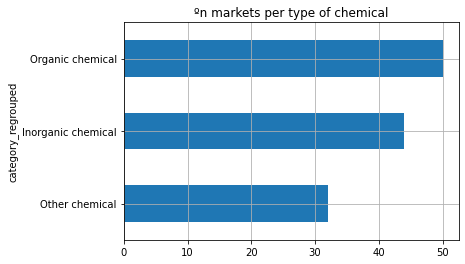

In [94]:
# ctg = lst_methods_TLs[6] # Land-system change - Global !!!! NO TRANSGRESSED CHEMICALS
# ctg = lst_methods_TLs[7] # Freshwater use - Global !!!! 7 transgressed
# ctg = lst_methods_TLs[2] # Stratospheric ozone depletion !!!! 33 transgressed
# ctg = lst_methods_TLs[4] # Biogeochemical flows - P !!!! 23 transgressed
ctg = lst_methods_TLs[5] # Biogeochemical flows - N !!!! 126 transgressed




print(ctg, "\n")
df_for_insights[df_for_insights[ctg] > 1].category_regrouped.unique()
df_for_insights[df_for_insights[ctg] > 1].activity_ISICclass.unique()
# sorted(df_for_insights[df_for_insights[lst_methods_TLs[5]]>1].referenceProduct_CPCclass.unique())

internal_funcs.plot_categories(
    df_for_insights[df_for_insights[ctg] > 1], # .between(1, 73.8, inclusive=True)
#     groupby="referenceProduct_CPCclass",
    groupby="category_regrouped",
    cutoff_value=0,
)

# df_for_insights[df_for_insights[ctg].between(1, 73.8, inclusive=True)].sort_values(by=ctg) # .tail(10)

# how many fixate N in their formula?
N_regex = re.compile(
    r"(.*N[A-Z0-9].*)|(.*N$)"
)  # compiled regular expression for formulas with N

formulas_with_N = []
for i in df_for_insights[df_for_insights[ctg] > 1].sort_values(by=ctg).MF:
    mo = N_regex.match(str(i))  # match object
    if mo:
        formulas_with_N.append(i) #mo.group())
#         print(mo.group())
print(round(
    len(formulas_with_N)
    / len(df_for_insights[df_for_insights[ctg] > 1].sort_values(by=ctg).MF)
    * 100, 2
),"% fixate N directly")

In [95]:
# 38.1 % fixate N directly (48 chemicals in total)
df_trnNflow = df_for_insights[df_for_insights[ctg] > 1]
# to which classification they belong?
df_trnNflow_fixateNdirectly = df_trnNflow[df_trnNflow.MF.isin(formulas_with_N)]
df_trnNflow_fixateNdirectly
# df_trnNflow_fixateNdirectly.referenceProduct_CPCclass.unique()
# # how many of them belong to Fertilisers and pesticides (CPC: 346)?
# df_trnNflow_fixateNdirectly[
#     df_trnNflow_fixateNdirectly.referenceProduct_CPCclass.isin(
#        [ "34663: Herbicides, anti-sprouting products and plant-growth regulators", 
#         '34653: Ammonium chloride; nitrites',
#         '34662: Fungicides',]
#     )
# ]

Activity  category_regrouped  \
15           2-nitroaniline {GLO}| market for | APOS, S    Organic chemical   
16              2-pyridinol {GLO}| market for | APOS, S    Organic chemical   
25              Acetanilide {GLO}| market for | APOS, S    Organic chemical   
37                Aclonifen {GLO}| market for | APOS, S      Other chemical   
67        Ammonium chloride {GLO}| market for | APOS, S      Other chemical   
76         Anthranilic acid {GLO}| market for | APOS, S    Organic chemical   
83    Azodicarbonamide {GLO}| market for azodicarbon...    Organic chemical   
164      Chloronitrobenzene {GLO}| market for | APOS, S    Organic chemical   
169           Chlorotoluron {GLO}| market for | APOS, S      Other chemical   
179       Cyanogen chloride {GLO}| market for | APOS, S  Inorganic chemical   
180       Cyanuric chloride {GLO}| market for | APOS, S    Organic chemical   
197          Diethanolamine {GLO}| market for | APOS, S    Organic chemical   
229   EDTA, ethylenediaminetetraacetic acid {GLO}| m...      Other chemical   
264   Fluorescent whitening agent, DAS1, triazinylam...    Organic chemical   
337             Isoproturon {GLO}| market for | APOS, S      Other chemical   
352                Mancozeb {GLO}| market for | APOS, S      Other chemical   
362   Meta-phenylene diamine {GLO}| market for | APO...    Organic chemical   
364              Metamitron {GLO}| market for | APOS, S      Other chemical   
387             Metolachlor {GLO}| market for | APOS, S      Other chemical   
392        Monoethanolamine {GLO}| market for | APOS, S    Organic chemical   
398             Napropamide {GLO}| market for | APOS, S      Other chemical   
414                 Nylon 6 {GLO}| market for | APOS, S    Organic chemical   
417               Nylon 6-6 {GLO}| market for | APOS, S    Organic chemical   
420           O-aminophenol {GLO}| market for | APOS, S    Organic chemical   
431               Orbencarb {GLO}| market for | APOS, S      Other chemical   
433   Ortho-phenylene diamine {GLO}| market for | AP...    Organic chemical   
442           P-nitrophenol {GLO}| market for | APOS, S      Other chemical   
443          P-nitrotoluene {GLO}| market for | APOS, S    Organic chemical   
444   Para-phenylene diamine {GLO}| market for | APO...    Organic chemical   
445           Pendimethalin {GLO}| market for | APOS, S      Other chemical   
454       Phenyl isocyanate {GLO}| market for | APOS, S    Organic chemical   
677         Triethanolamine {GLO}| market for | APOS, S    Organic chemical   
782                Pyrazole {GLO}| market for | APOS, S    Organic chemical   
897        Ammonium bicarbonate, combined to GLO market  Inorganic chemical   
899                     Aniline, combined to GLO market    Organic chemical   
934   Dtpa, diethylenetriaminepentaacetic acid, comb...      Other chemical   
944             Ethylenediamine, combined to GLO market    Organic chemical   
951                   Hydrazine, combined to GLO market    Organic chemical   
958               Hydroxylamine, combined to GLO market    Organic chemical   
970   Methylene diphenyl diisocyanate, combined to G...    Organic chemical   
976       Nylon 6, glass-filled, combined to GLO market    Organic chemical   
980               O-nitrophenol, combined to GLO market    Organic chemical   
996   Polyurethane, flexible foam, combined to GLO m...    Organic chemical   
997    Polyurethane, rigid foam, combined to GLO market    Organic chemical   
1007               Sodium amide, combined to GLO market  Inorganic chemical   
1012             Sodium nitrite, combined to GLO market  Inorganic chemical   
1030       Toluene diisocyanate, combined to GLO market    Organic chemical   
1036             Trimethylamine, combined to GLO market    Organic chemical   

                                       activity_comment      type  \
15    Production volume: 22000000 kgIncluded acti...  Products   
16    Production volume: 10000000 k

In [96]:
df_for_insights[df_for_insights[ctg] < 0].sort_values(by=ctg)

Empty DataFrame
Columns: [Activity, category_regrouped, activity_comment, type, referenceProduct, category, inline_comment, geo, activity_ISICclass, activity_ecoSpold01class, technologyLevel, referenceProductAmount, referenceProductUnit, referenceProduct_prodVolume, referenceProduct_prodVolumeComment, referenceProduct_price, referenceProduct_priceUnit, referenceProduct_priceComment, referenceProduct_casNumber, referenceProduct_CPCclass, activity_generalComment, sourceFilename, pubchem_match, num_matches, MF, MW, iupac, complexity, synonyms, ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq'), ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm'), ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2'), ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU'), ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon'), ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P'), ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N'), ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%'), ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3'), ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss'), TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm'), TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2'), TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU'), TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon'), TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P'), TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N'), TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%'), TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3'), TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss'), p_value]
Index: []

In [97]:
df_for_insights[df_for_insights[ctg].between(1, 73.8, inclusive=True)].sort_values(by="category_regrouped").tail(31)

Activity category_regrouped  \
431               Orbencarb {GLO}| market for | APOS, S     Other chemical   
882   Uranium, enriched 4%, in fuel element for ligh...     Other chemical   
881   Uranium, enriched 3.9%, in fuel element for li...     Other chemical   
172        Copper carbonate {GLO}| market for | APOS, S     Other chemical   
169           Chlorotoluron {GLO}| market for | APOS, S     Other chemical   
880   Uranium, enriched 3.8%, in fuel element for li...     Other chemical   
1022                    Sulfite, combined to GLO market     Other chemical   
37                Aclonifen {GLO}| market for | APOS, S     Other chemical   
879   Uranium, enriched 3.0%, in fuel element for li...     Other chemical   
804         Zeolite, powder {GLO}| market for | APOS, S     Other chemical   
795   Sodium tripolyphosphate {GLO}| market for | AP...     Other chemical   
1065  Sodium percarbonate, powder, combined to GLO m...     Other chemical   
1067  Zeolite, slurry, without water, in 50% solutio...     Other chemical   
67        Ammonium chloride {GLO}| market for | APOS, S     Other chemical   
883   Uranium, enriched 4.2%, in fuel element for li...     Other chemical   
532   Potassium sulfate, as K2O {GLO}| market for | ...     Other chemical   
229   EDTA, ethylenediaminetetraacetic acid {GLO}| m...     Other chemical   
461   Phosphoric acid, fertiliser grade, without wat...     Other chemical   
268   Fluosilicic acid, without water, in 22% soluti...     Other chemical   
274              Fosetyl-Al {GLO}| market for | APOS, S     Other chemical   
337             Isoproturon {GLO}| market for | APOS, S     Other chemical   
349   Lithium manganese oxide {GLO}| market for | AP...     Other chemical   
352                Mancozeb {GLO}| market for | APOS, S     Other chemical   
459   Phosphate rock, as P2O5, beneficiated, dry {GL...     Other chemical   
387             Metolachlor {GLO}| market for | APOS, S     Other chemical   
445           Pendimethalin {GLO}| market for | APOS, S     Other chemical   
398             Napropamide {GLO}| market for | APOS, S     Other chemical   
934   Dtpa, diethylenetriaminepentaacetic acid, comb...     Other chemical   
952   Hydrochloric acid, without water, in 30% solut...     Other chemical   
1083       Uranium hexafluoride, combined to GLO market     Other chemical   
364              Metamitron {GLO}| market for | APOS, S     Other chemical   

                                       activity_comment      type  \
431   In this market, expert judgement was used to d...  Products   
882   Production volume: 1888111.88811189 kgInclu...  Products   
881   Production volume: 1956521.73913044 kgInclu...  Products   
172   Production volume: 4 kgIncluded activities ...  Products   
169   In this market, expert judgement was used to d...  Products   
880   Production volume: 2033898.30508475 kgInclu...  Products   
1022                                               None  Products   
37    In this market, expert judgement was used to d...  Products   
879   Production volume: 2895442.35924933 kgInclu...  Products   
804   In this market, expert judgement was used to d...  Products   
795   In this market, expert judgement was used to d...  Products   
1065                                               None  Products   
1067                                               None  Products   
67    Production volume: 284985365.853659 kgInclu...  Products   
883   Production volume: 1764705.88235294 kgInclu...  Products   
532   Production volume: 5265940829.09887 kgInclu...  Products   
229   Production volume: 309770114.942529 kgInclu...  Products   
461   Only production of dihydrate process considere...  Products   
268   This is a constrained market. The justificatio...  Products   
274   In this market, expert judgement was used to d...  Products   
337   In this market, expert judgement was used to d...  Products   
349   This product is generally 

In [98]:
# list of Fertilizers and pesticides, directly related to agriculture and their TLs in BGC flows
ddd = {}
for i in df_for_insights.index:
    if df_for_insights.referenceProduct_CPCclass[i].startswith(
        "346"
    ):  # Group 346 of CPC: Fertilizers and pesticides
        ddd[i] = (
            df_for_insights.referenceProduct_CPCclass[i],
            df_for_insights.referenceProduct[i],
            df_for_insights.MF[i],
            df_for_insights[lst_methods_TLs[5]][i],
            df_for_insights[lst_methods_TLs[4]][i],
        )
pd.DataFrame.from_dict(
    ddd,
    orient="index",
    columns=["CPC", "refProduct", "MF", "TL in N flow", "TL in P flow"],
).sort_values(by="TL in N flow")

CPC  \
135                                  34662: Fungicides   
363  3466: Insecticides, fungicides, herbicides and...   
896                            3465: Other fertilizers   
269                                  34662: Fungicides   
529                           34646: Potassium nitrate   
693                                        34611: Urea   
526      34631: Potassium chloride (muriate of potash)   
544  34663: Herbicides, anti-sprouting products and...   
70                            34612: Ammonium sulphate   
168                                  34662: Fungicides   
281  34663: Herbicides, anti-sprouting products and...   
359  34663: Herbicides, anti-sprouting products and...   
200  34663: Herbicides, anti-sprouting products and...   
82   34663: Herbicides, anti-sprouting products and...   
364  34663: Herbicides, anti-sprouting products and...   
461                    346: Fertilizers and pesticides   
532     34632: Potassium sulphate (sulphate of potash)   
459        34629: Other phosphatic fertilizers, n.e.c.   
398  34663: Herbicides, anti-sprouting products and...   
67                  34653: Ammonium chloride; nitrites   
274                                  34662: Fungicides   
169  34663: Herbicides, anti-sprouting products and...   
387  34663: Herbicides, anti-sprouting products and...   
431  34663: Herbicides, anti-sprouting products and...   
352                                  34662: Fungicides   
37   34663: Herbicides, anti-sprouting products and...   
337  34663: Herbicides, anti-sprouting products and...   
445  34663: Herbicides, anti-sprouting products and...   

                                            refProduct             MF  \
135                                             Captan    C9H8Cl3NO2S   
363                                        Metaldehyde        C8H16O4   
896                                    Ammonia, liquid            H3N   
269                                             Folpet    C9H4Cl3NO2S   
529                                  Potassium nitrate           KNO3   
693                                         Urea, as N         CH4N2O   
526                         Potassium chloride, as K2O            ClK   
544                                       Prosulfocarb      C14H21NOS   
70                              Ammonium sulfate, as N        H8N2O4S   
168                                     Chlorothalonil        C8Cl4N2   
281                                         Glyphosate       C3H8NO5P   
359                                           Mecoprop     C10H11ClO3   
200                                      Dimethenamide   C12H18ClNO2S   
82                                            Atrazine      C8H14ClN5   
364                                         Metamitron      C10H10N4O   
461  Phosphoric acid, fertiliser grade, without wat...          H3O4P   
532                          Potassium sulfate, as K2O          K2O4S   
459         Phosphate rock, as P2O5, beneficiated, dry      Ca5FO12P3   
398                                        Napropamide      C17H21NO2   
67                                   Ammonium chloride          ClH4N   
274                                         Fosetyl-Al  C6H15AlO9P3+3   
169                                      Chlorotoluron    C10H13ClN2O   
387                                        Metolachlor    C15H22ClNO2   
431                                          Orbencarb    C12H16ClNOS   
352                                           Mancozeb  C8H12MnN4S8Zn   
37                                           Aclonifen    C12H9ClN2O3   
337                                        Isoproturon      C12H18N2O   
445                                      Pendimethalin     C13H19N3O4   

     TL in N flow  TL in P flow  
135      0.123409      0.003036  
363      0.124104      0.003873  
896      0.152267      0.005770  
269      0.181835      0.004382  
529      0.350089      0.013296  
693      0.369168      0.013486  
526      0.4

## probability TL(EPC) > TL(GF) ?

In [99]:
TL_GF = {
    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')": 15.069444444444445,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')": 14.8,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')": 0.4827586206896552,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')": 4.811594202898551,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')": 2.1111111111111107,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')": 2.4193548387096775,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')": 1.52,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')": 0.65,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')": 2.68,
}

In [100]:
cat_of_interest = lst_methods_TLs[8]
df = df_for_insights[cat_of_interest]

df_out = ecdf(df)

stored_indices = []  # they are indices of df_out, not df
indices_duplicated_scores = []  # they are indices of df_out, not df

for ix in df_out.index:
    if df_out[df.name][ix] <= TL_GF[cat_of_interest]:
        print_prob = df_out.Probability[ix]
        print_item = df_out[df.name][ix]
        stored_indices.append(ix)
    if df_out.counts[ix] != 1:
        indices_duplicated_scores.append(ix)

# find the chemicals in the original df (translate indices from df_out to df)
# for stored_indices:
df_from_stored_indices = df_for_insights[
    df_for_insights[cat_of_interest].isin(df_out[cat_of_interest][stored_indices])
]

# for indices_duplicated_scores:
df_from_duplicated_scores = df_for_insights[
    df_for_insights[cat_of_interest].isin(
        df_out[cat_of_interest][indices_duplicated_scores]
    )
]

print(
    "set of chemicals with TL_EPC lower than TL_GF ({}): {} of {}".format(
        TL_GF[cat_of_interest],
        df_from_stored_indices.shape[0], 
        df_for_insights.shape[0]
    )
)
print("Probability of the set:", np.round(print_prob, 3))
print("Max value of TL_EPC included in set, max(TL_EPC)=", print_item)

print(
    "{}% of chemicals with TL_EPC > TL_GF in {}".format(
        np.round((1 - print_prob) * 100, 2), 
        df.name
    )
)

# visualize the data (uncomment)
# df_from_duplicated_scores
# df_from_stored_indices

set of chemicals with TL_EPC lower than TL_GF (2.68): 125 of 466
Probability of the set: 0.268
Max value of TL_EPC included in set, max(TL_EPC)= 2.6628728496200504
73.18% of chemicals with TL_EPC > TL_GF in TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')


## d

In [101]:
df_for_insights[df_for_insights.referenceProduct.isin(highlighted_product)]

Activity  category_regrouped  \
3                1-propanol {GLO}| market for | APOS, S    Organic chemical   
23             Acetaldehyde {GLO}| market for | APOS, S    Organic chemical   
26    Acetic acid, without water, in 98% solution st...    Organic chemical   
41            Acrylonitrile {GLO}| market for | APOS, S    Organic chemical   
169           Chlorotoluron {GLO}| market for | APOS, S      Other chemical   
281              Glyphosate {GLO}| market for | APOS, S      Other chemical   
367                Methanol {GLO}| market for | APOS, S    Organic chemical   
417               Nylon 6-6 {GLO}| market for | APOS, S    Organic chemical   
444   Para-phenylene diamine {GLO}| market for | APO...    Organic chemical   
495   Polyethylene, high density, granulate {GLO}| m...    Organic chemical   
507   Polypropylene, granulate {GLO}| market for | A...    Organic chemical   
518   Polyvinylchloride, bulk polymerised {GLO}| mar...    Organic chemical   
693              Urea, as N {GLO}| market for | APOS, S      Other chemical   
783                Pyridine {GLO}| market for | APOS, S    Organic chemical   
821                 Benzene {GLO}| market for | APOS, S    Organic chemical   
890                   Acetylene, combined to GLO market    Organic chemical   
896             Ammonia, liquid, combined to GLO market      Other chemical   
919            Chlorine, liquid, combined to GLO market  Inorganic chemical   
942              Ethylene oxide, combined to GLO market    Organic chemical   
945            Fluorine, liquid, combined to GLO market  Inorganic chemical   
946                Formaldehyde, combined to GLO market    Organic chemical   
957            Hydrogen, liquid, combined to GLO market  Inorganic chemical   
970   Methylene diphenyl diisocyanate, combined to G...    Organic chemical   
1027              Sulfuric acid, combined to GLO market  Inorganic chemical   
1031            Toluene, liquid, combined to GLO market    Organic chemical   
1040                     Xylene, combined to GLO market    Organic chemical   
1070         Diesel, low-sulfur, combined to GLO market    Organic chemical   
1071          Ethylene, average, combined to GLO market    Organic chemical   
1074                   Kerosene, combined to GLO market    Organic chemical   
1076    Liquefied petroleum gas, combined to GLO market    Organic chemical   
1079         Petrol, low-sulfur, combined to GLO market    Organic chemical   
1081                  Propylene, combined to GLO market    Organic chemical   

                                       activity_comment      type  \
3     Production volume: 347701149.425287 kgInclu...  Products   
23    Production volume: 766000000 kgIncluded act...  Products   
26    Production volume: 4500264105.64226 kgInclu...  Products   
41    Production volume: 5200000000 kgIncluded ac...  Products   
169   In this market, expert judgement was used to d...  Products   
281   In this market, expert judgement was used to d...  Products   
367   This dataset represents the supply of 1 kg of ...  Products   
417   In this market, expert judgement was used to d...  Products   
444   Production volume: 12014200 kgIncluded acti...  Products   
495   In this market, expert judgement was used to d...  Products   
507   In this market, expert judgement was used to d...  Products   
518   In this market, expert judgement was used to d...  Products   
693   Production volume: 61999644128.1362 kgInclu...  Products   
783   Production volume: 10000000 kgIncluded acti...  Products   
821   Production volume: 35477215189.8734 kgInclu...  Products   
890                                                None  Products   
896                                                None  Products   
919                                                None  Products   
942                                                None  Products   
945                                                None  Pr

In [103]:
len(highlighted_product)

34

# PLOTS

#### General

In [104]:
dict_pbs ={}
for pattern in dict_fullMethods['PBs-LCIA (baseline) V0.72']:
    methodRegex = re.compile(r"\'(.*?)\'")
    mo = methodRegex.findall(pattern)
    lcia_cat = mo[1]
    lcia_cat_unit = mo[2]
    dict_pbs[pattern] = [lcia_cat, lcia_cat_unit]

# X-axis labels for the plot with units:
# labels_xaxis = ['Climate change - Energy imbalance',
#                 'Climate change - $CO_2$ concentration',
#                 'Stratospheric ozone depletion',
#                 'Ocean acidification',
#                 'Biogeochemical flows - Nitrogen',
#                 'Biogeochemical flows - Phosphorus',
#                 'Land-system change',
#                 'Freshwater use',
#                 'Biosphere integrity',
#                ]
labels_xaxis = ['CC - Energy imb.',
                'CC - $CO_2$ conc.',
                'SOD',
                'OA',
                'BGC flows - N',
                'BGC flows - P',
                'LSC',
                'FWU',
                'CBI - BII loss',
               ]
labels_xaxis_units = [r'$W\ m^{-2} kg^{-1}$',
                      r'$ppm\ kg^{-1}$',
                      r'$DU\ kg^{-1}$',
                      r'$mol\ kg^{-1}$',
                      r'$TgN\ yr^{-1} kg^{-1}$', 
                      r'$TgP\ yr^{-1} kg^{-1}$', 
                      r'$\%\ kg^{-1}$',
                      r'$km^3 yr^{-1} kg^{-1}$',
                      r'$\%\ kg^{-1}$',
                     ]

for key in dict_pbs.keys():
    if "imbalance" in key:
        dict_pbs[key] = [labels_xaxis[0], labels_xaxis_units[0]]
    elif "concentration" in key:
        dict_pbs[key] = [labels_xaxis[1], labels_xaxis_units[1]]
    elif "ozone" in key:
        dict_pbs[key] = [labels_xaxis[2], labels_xaxis_units[2]]
    elif "acidification" in key:
        dict_pbs[key] = [labels_xaxis[3], labels_xaxis_units[3]]
    elif "flows - N" in key:
        dict_pbs[key] = [labels_xaxis[4], labels_xaxis_units[4]]
    elif "flows - P" in key:
        dict_pbs[key] = [labels_xaxis[5], labels_xaxis_units[5]]
    elif "Land-system" in key:
        dict_pbs[key] = [labels_xaxis[6], labels_xaxis_units[6]] 
    elif "Freshwater" in key:
        dict_pbs[key] = [labels_xaxis[7], labels_xaxis_units[7]]
    elif "integrity" in key:
        dict_pbs[key] = [labels_xaxis[8], labels_xaxis_units[8]]

In [105]:
plot_colors = {
    "Organic chemical": "#91bfdb",  #
    "Inorganic chemical": "#fc8d59",  #
    "Other chemical": "#ADC9A6",
}

   <span style="color:#91bfdb">"Organic chemical"</span>  
   <span style="color:#fc8d59">"Inorganic chemical"</span>  
    <span style="color:#ADC9A6">"Other chemical"</span> 

### Other

#### statistical ...
<div class="alert alert-block alert-info">
created: <strong>???</strong>  
    (based on df_clean ???)
</div>

In [84]:
df_toplot = df_clean

fig = create_fig((210, 110), 300)
ax = fig.subplots(2, 5)
fig.subplots_adjust(
    wspace=0.2, hspace=0.3,
)

ax = ax.flatten()

print("printing Kolmogorov-Smirnov test results: \n")

for i in range(10):
#     data_raw = df_base[lst_methods[i]]
    data_raw = df_toplot[lst_methods[i]] # using the data without outliers
    mask = ~np.isnan(data_raw)
    data = data_raw[mask]
    _, name, *_ = data.name.split("', '")

    # Kolmogorov-Smirnov test
    # https://www.wikiwand.com/en/Kolmogorov%E2%80%93Smirnov_test
    (st, pval) = stats.kstest(data, cdf="norm")
    print("{} \nD-statistic={:.3f}, p-value={:.3e}\n".format(name, st, pval))

    if i == 9:
        print("visualizing Probability plots:")
    (_, _), (_, _, r) = stats.probplot(
        data,
        dist=stats.norm,
        #                dist=stats.lognorm, sparams = (0.954),
        plot=ax[i],
        rvalue=True,
    )

    # modifications below based on https://stackoverflow.com/a/37463899/14485040
    ax[i].get_lines()[0].set_markersize(1)
    ax[i].set_title(name, fontsize=6)
    if i in range(5):
        ax[i].set_xlabel("")
    else:
        ax[i].set_xlabel("Quantiles", fontsize=8, fontweight="normal")
    if i not in [0, 5]:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Ordered values", fontsize=8, fontweight="normal")
        
    ax[i].get_children()[2].set_fontsize(6)  # change font size of "R2=..."
    ypos_r2 = ax[i].get_children()[2].get_position()[1]
    ax[i].get_children()[2].set_position((0, ypos_r2))  # change xpos of R2
#     print("{}: R^2 ={}".format(lst_methods[i], r**2))

#### https://www.wikiwand.com/en/Normal_probability_plot

NameError: name 'df_clean' is not defined

<div class="alert alert-block alert-info">
uniform distribution -  looks like <strong>S-shape</strong> of blue dots  <br>
right-skewed distribution - looks like inverted <strong>C-shape</strong> of blue dots    <br>
normal distribution - looks like <strong>straight line</strong> of blue dots  
</div>

In [ ]:
df_clean.complexity.describe()

In [ ]:
df_clean.query("62<complexity<63")

#### ***other?

In [ ]:
# df_clean[df_clean.referenceProduct==highlighted_product[0]]

#### simple figs ...
<div class="alert alert-block alert-info">
 simple figures
</div>

In [ ]:
# fig = create_fig((90, 90), 150)
# ax = fig.add_subplot()

# ax.scatter(x=df_clean.MW, #MW,
#           y=df_clean[lst_methods[0]], #.amount_price, 
#           s=5)
# # ax.set_ylim(-2, 20)
# # ax.set_xlim(-4, 400)

In [ ]:
# Normalize between 1 and 10
start = 1
end = 10
width = end - start

df_clean["MW_norm"] = (df_clean.MW - df_clean.MW.min()) / (
    df_clean.MW.max() - df_clean.MW.min()
) * width + start

df_clean["complexity_norm"] = (df_clean.complexity - df_clean.complexity.min()) / (
    df_clean.complexity.max() - df_clean.complexity.min()
) * width + start
df_clean.sample(3)

In [ ]:
# number of nan values in column
msk = pd.isna(df_clean.MW)
print("{} nan values in column".format(msk.sum()))
# [i for i in lst_casNotFound if i not in list(df_clean[msk].referenceProduct)]

In [ ]:
# #### DEAL WITH NAN VALUES!!!!
# df_clean.MW_norm.fillna(0.00001, inplace=True) 
# df_clean.complexity_norm.fillna(0.00001, inplace=True) 

In [ ]:
highlighted_product

In [ ]:
# df_clean[
#     df_clean.referenceProduct.isin(
#         ["Liquefied petroleum gas", "Petrol, low-sulfur","Diesel", "Kerosene",]
#     )
# ]

aaa = df_clean[
    df_clean.referenceProduct.isin(
        highlighted_product
        + ["Fluorescent whitening agent, DAS1, triazinylaminostilben type"]
    )
][["referenceProduct"] + lst_methods].sort_values(
#     by="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"
    by="('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"
)

aaa

# # write to excel
# excelName = "df_scoresJavierListChemicals.xlsx"

# df_readme = readme_data(
#     excelName,
#     " ",
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": aaa},
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

In [ ]:
# plot category
cat = lst_methods[1]
# df_toplot = df_TLs
df_toplot = df_clean

fig = create_fig((90, 90), 150)
ax = fig.add_subplot()

annotations = []
grouped = dict(list(df_toplot.groupby("category_regrouped")))
tot_keys = len(grouped)
for i, (key, group) in enumerate(grouped.items()):
    #     if i == 1:

    x_group_raw = group[cat]  # "complexity"]
    y_group_raw = group[lst_methods[0]]
    s_group_raw = group["MW"] * 0.1  #
    #     s_group_raw = group["MW_norm"]*10 #
    #     s_group_raw = group["complexity_norm"]*10

    #     # Not plot highlighted_products
    #     for prod in highlighted_product:
    #         print(prod)
    #         i_prod = [i for i in group.index if prod in group.referenceProduct[i]]
    #         print(i_prod)
    #         try:
    #             print(group.loc[i_prod].referenceProduct)
    #         except:
    #             pass
    #     mask_highlighted =

    # Remove Nan values
    mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
    x_group = x_group_raw[mask_group]
    y_group = y_group_raw[mask_group]
    s_group = s_group_raw[mask_group]

    #     print()
    # ---------- scatter plot ---------------
    ax.scatter(
        x=x_group,
        y=y_group,
        c=plot_colors[key],
        #             label=key,
        alpha=0.5,
        s=s_group,  # 6,
        linewidths=0.2,
        ec="k",
    )

    ax.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=0.2)

    xlabelname = "\n".join(
        textwrap.wrap(dict_pbs[cat][0] + " (" + dict_pbs[cat][1] + ")", 50)
    )
    ax.set_xlabel(xlabel=xlabelname, labelpad=0.2)

    xlim_ax = ax.get_xlim()
    xaxis_size = xlim_ax[1] - xlim_ax[0]
    xoffset = 0.1 * xaxis_size
    ylim_ax = ax.get_ylim()
    yaxis_size = ylim_ax[1] - ylim_ax[0]
    yoffset = 0.05 * yaxis_size
    #     print(xoffset, yoffset)

    #     ax.set_xlim(left=-5, right=100)
    for prod in highlighted_product:
        #         if i == 1:
        i_prod = [n for n in group.index if prod == group.referenceProduct[n]]
        #             ax.annotate(prod, xy=(x_group[i_prod], y_group[i_prod]), fontsize=6)
        try:
            if i_prod:
#                 xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)

                annotation = ax.text(
                    x_group[i_prod],
                    y_group[i_prod],
                    prod,
                    #                     xy=(x_group[i_prod], y_group[i_prod]),
                    #                     xycoords="data",
                    #                     xytext=xy_coor,
                    #                     arrowprops=dict(
                    #                         arrowstyle="-|>, head_length=0.3, head_width=0.15",
                    #                         color="k",
                    #                         linewidth=0.3,
                    #                     ),
                    fontsize=6,
                )
                annotations.append(annotation)

        except:
            pass

adjust_text(
    annotations,
    xycoords="data",
    arrowprops=dict(
        arrowstyle="-|>, head_length=0.3, head_width=0.15", color="k", linewidth=0.3,
    ),
    text_from_points=False,
    autoalign="xy",
    force_points=(0.2, 0.5),
)

In [ ]:
# df_clean[df_clean.referenceProduct == "Hydrochloric acid, without water, in 30% solution state"]

In [ ]:
_plot_categories(df_clean, groupby="category", cutoff_value=10)

In [ ]:
_plot_categories(df_clean, groupby="category_regrouped")

In [ ]:
# dict(list(df_clean.groupby(by="category"))).keys()

In [ ]:
# print(calculate_stats(df_clean["('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"]))

# for key in dict(list(df_clean.groupby(by="category"))):
#     df = dict(list(df_clean.groupby(by="category")))[key]
#     try:
#         print(key, "-->\n", calculate_stats(df["('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"]))
#     except:
#         pass

### fig 2 (fig 1 will be a schematic)
<div class="alert alert-block alert-info">
  Transgression level of PBs <br>
    - histograms <br>
    - cumulative distribution functions <br>
</div>

In [106]:
# non-egalitarian (status-quo) sharing principle

SOS_tot = {
    72.0: ["Climate change - CO2 concentration"],  # 'ppm'
    1.00: ["Climate change - Energy imbalance"],  # 'Wm-2
    14.5: ["Stratospheric ozone depletion"],  # 'DU'
    0.69: ["Ocean acidification"],  # 'Omega Aragon'
    9.90: ["Biogeochemical flows - P"],  # 'Tg P'
    62.0: ["Biogeochemical flows - N"],  # 'Tg N'
    25.0: ["Land-system change - Global"],  # '%'
    4000: ["Freshwater use - Global"],  # 'km3'
    10.0: ["Change in biosphere integrity - BII loss"],  # '% BII loss'
}


current_totPBs = {
    1085: ["Climate change - CO2 concentration"],  # 'ppm'
    14.8: ["Climate change - Energy imbalance"],  # 'Wm-2
    7.00: ["Stratospheric ozone depletion"],  # 'DU'
    3.32: ["Ocean acidification"],  # 'Omega Aragon'
    20.9: ["Biogeochemical flows - P"],  # 'Tg P'
    150.0: ["Biogeochemical flows - N"],  # 'Tg N'
    38.0: ["Land-system change - Global"],  # '%'
    2600: ["Freshwater use - Global"],  # 'km3'
    26.8: ["Change in biosphere integrity - BII loss"],  # '% BII loss'
}

dict_SOS_tot = {v:k for k in SOS_tot.keys() for v in SOS_tot[k]}
dict_current_totPBs = {v:k for k in current_totPBs.keys() for v in current_totPBs[k]}

In [107]:
pd.DataFrame.from_dict([dict_SOS_tot, dict_current_totPBs])

Climate change - CO2 concentration  Climate change - Energy imbalance  \
0                                72.0                                1.0   
1                              1085.0                               14.8   

   Stratospheric ozone depletion  Ocean acidification  \
0                           14.5                 0.69   
1                            7.0                 3.32   

   Biogeochemical flows - P  Biogeochemical flows - N  \
0                       9.9                      62.0   
1                      20.9                     150.0   

   Land-system change - Global  Freshwater use - Global  \
0                         25.0                     4000   
1                         38.0                     2600   

   Change in biosphere integrity - BII loss  
0                                      10.0  
1                                      26.8

In [108]:
TL_statusquo = {k: float(dict_current_totPBs[k])/dict_SOS_tot[k] for k in dict_SOS_tot}
TL_statusquo

{'Climate change - CO2 concentration': 15.069444444444445,
 'Climate change - Energy imbalance': 14.8,
 'Stratospheric ozone depletion': 0.4827586206896552,
 'Ocean acidification': 4.811594202898551,
 'Biogeochemical flows - P': 2.1111111111111107,
 'Biogeochemical flows - N': 2.4193548387096775,
 'Land-system change - Global': 1.52,
 'Freshwater use - Global': 0.65,
 'Change in biosphere integrity - BII loss': 2.68}

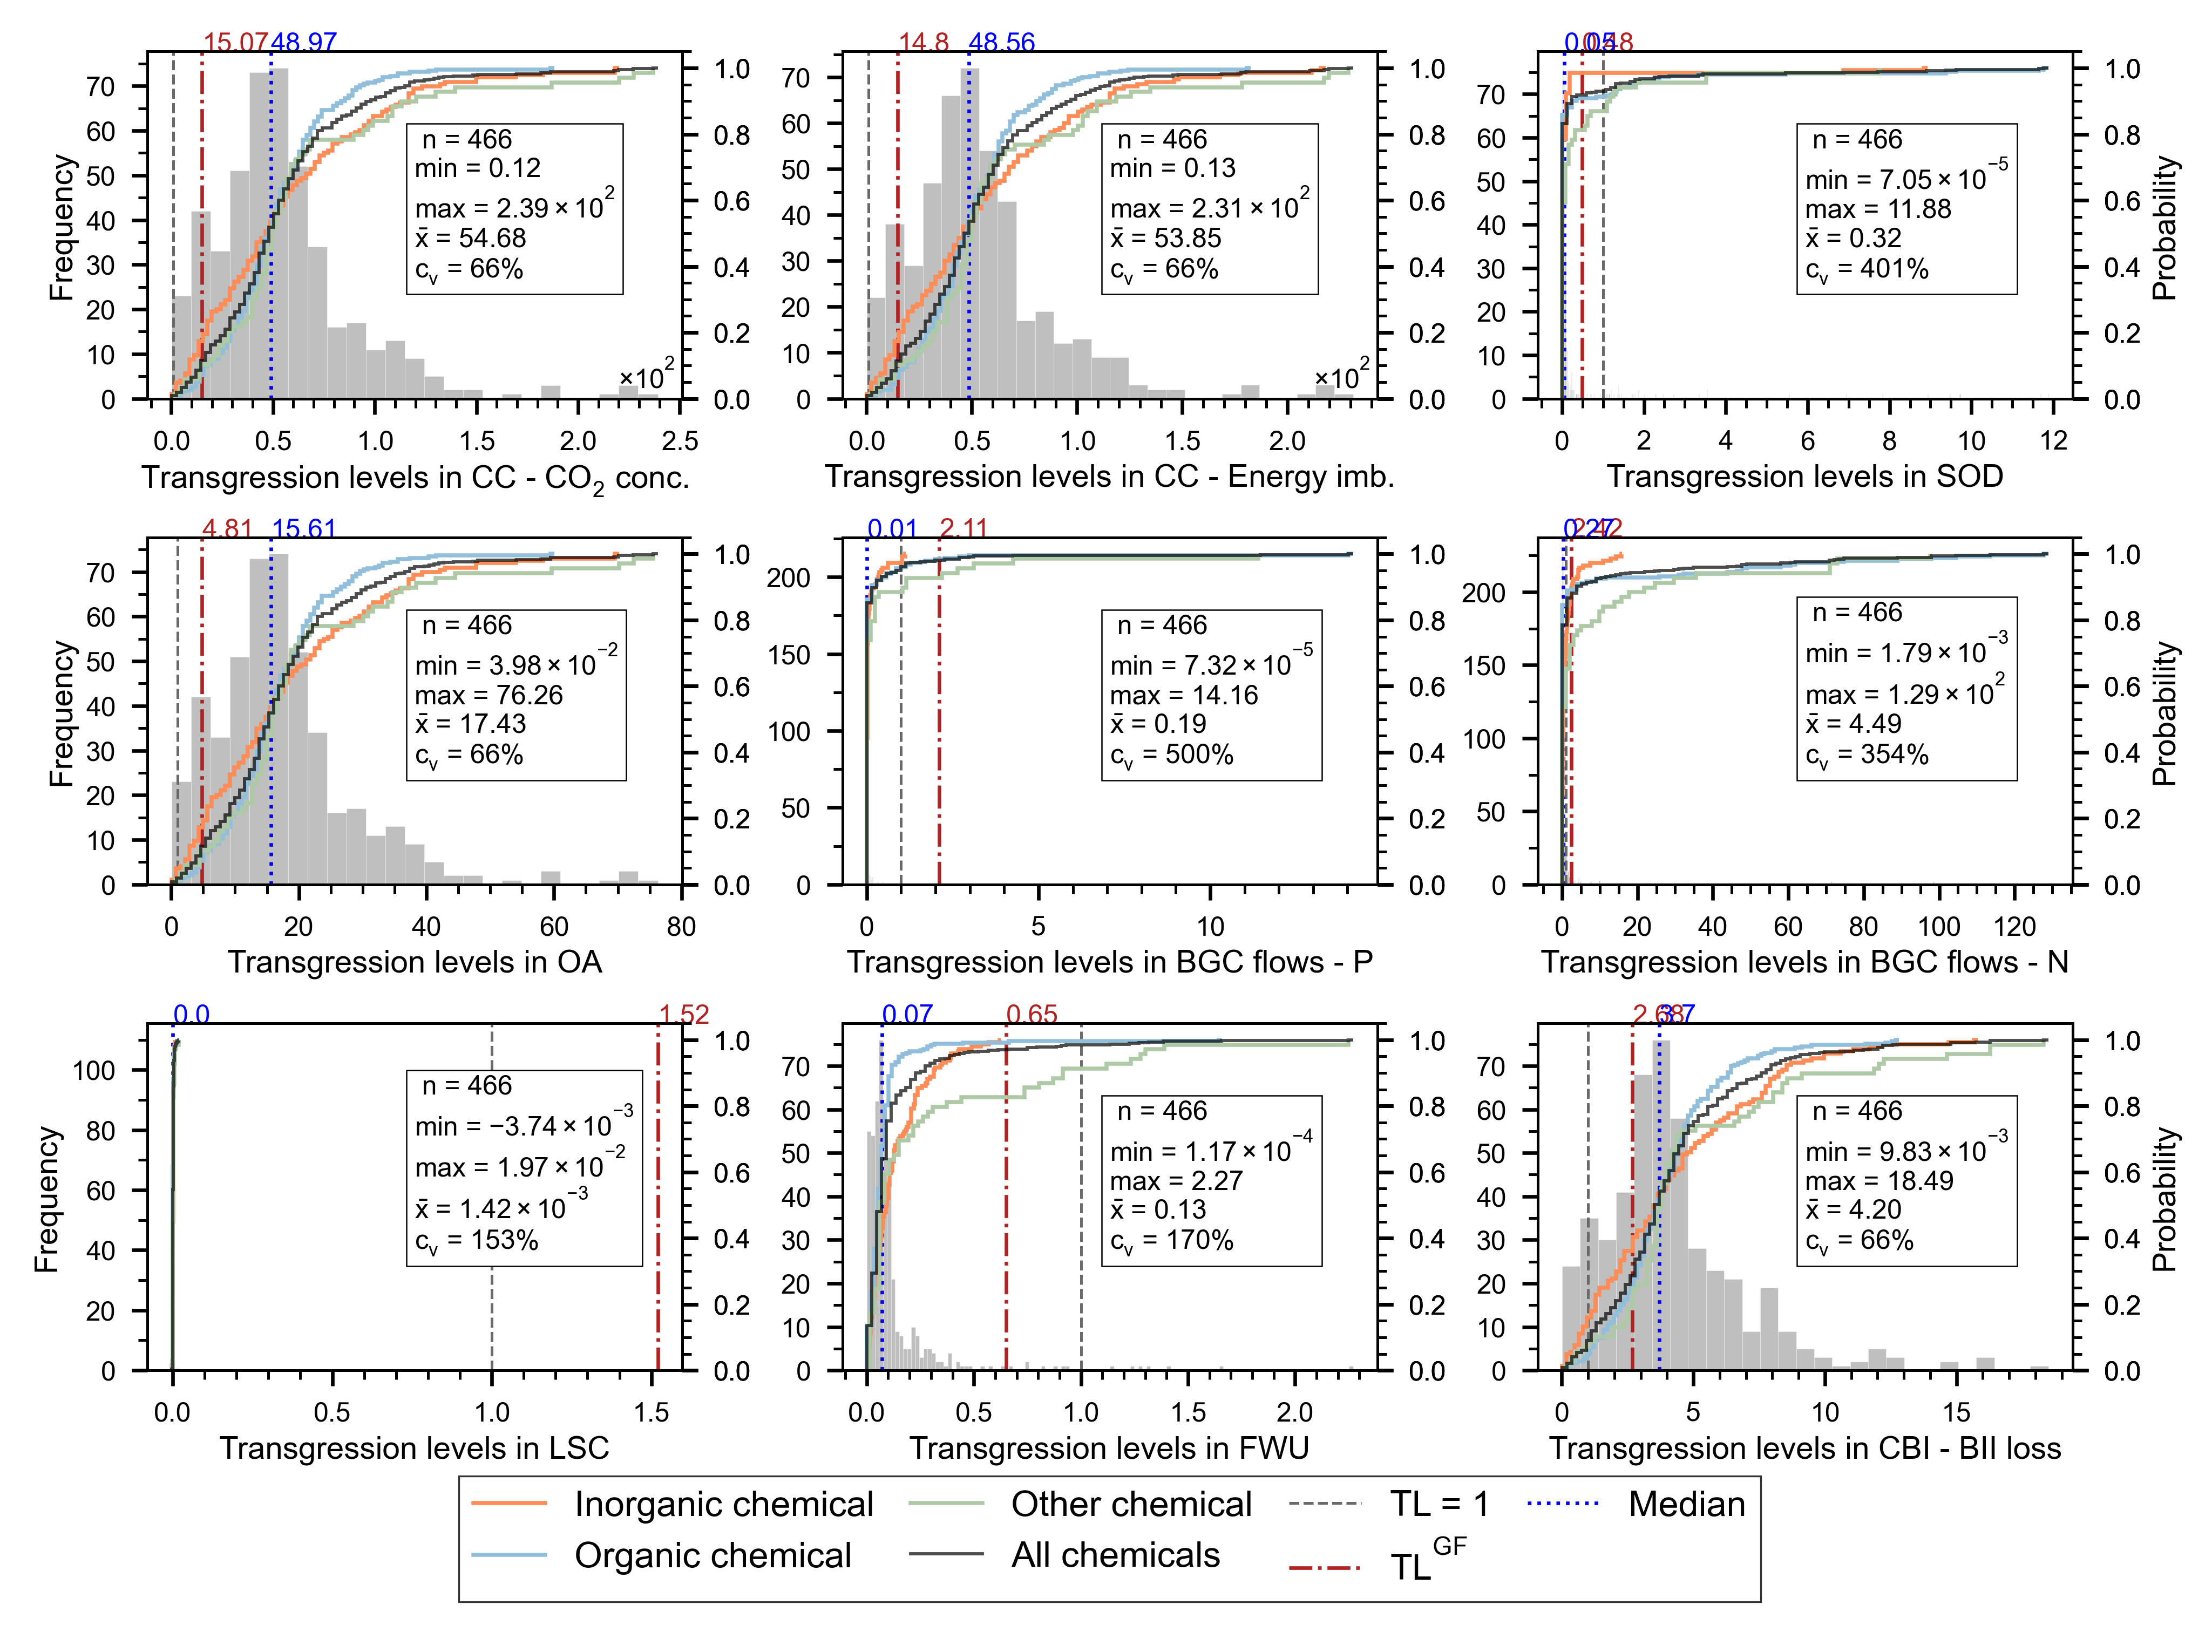

In [111]:
namedf = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS"
loop_methods = lst_methods_TLs

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

# df_toplot = df_clean_mahalanobis_fig2 # df_cleanxx_prueba2# df_cleanxx_prueba# df_TLs
##################

size_legend_font = 8

fig_width, fig_height = 171, 130
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 10  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 10  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 5  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.86, 0.16],
    #     wspace=0.15,
    hspace=0.005,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)

# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=3,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.3,
    hspace=0.4,
)

annotations = []
for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]

    # Remove Nan values
    x_raw = x_raw.astype(np.float64)
    mask = ~np.isnan(x_raw)
    x = x_raw[mask]

    # Subplots ....
    ax = fig.add_subplot(gs[gsx])

    # ---------- histogram ---------------    
    # calculate number of bins
    # credit: https://stats.stackexchange.com/a/862
    # based on Freedman–Diaconis rule (https://www.wikiwand.com/en/Freedman%E2%80%93Diaconis_rule)
    vxmax = max(x)
    vxmin = min(x)
    nsamples = len(x)
    IQR = x.quantile(0.75) - x.quantile(0.25)
    binwidth = 2*IQR/nsamples**(1/3)
    numbins = int((vxmax-vxmin)/binwidth)
    if numbins >= nsamples:
        numbins = "auto"

    ax.hist(
        x,
        bins=numbins,
        cumulative=False,
        histtype="bar",
        color="gray",
        ec="w",
        lw=0.1,
        density=False,
        alpha=0.5,
    )
    xlabelname = "\n".join(
        textwrap.wrap("Transgression levels in " + dict_pbs_plot[cat][0], 50)
    )
    ax.set_xlabel(xlabel=xlabelname, labelpad=2)

    ax.set_ylabel(ylabel="Frequency", labelpad=2)
    if gsx in [1, 2, 4, 5, 7, 8]:
        ax.set_ylabel(None)

    grouped = dict(list(df_toplot.groupby("category_regrouped")))
    tot_keys = len(grouped)
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]

        # Remove Nan values
        x_group_raw = x_group_raw.astype(np.float64)
        mask_group = ~np.isnan(x_group_raw)
        x_group = x_group_raw[mask_group]

        # ---------- cumulative histogram ---------------
        ax2 = ax.twinx()
        ax2.hist(
            x_group,
            bins=100,
            cumulative=True,
            histtype="step",
            color=plot_colors[key],
            lw=0.9,
            density=True,
        )
        fix_hist_cdf_drop_line_at_end(ax2)
    ax2.set_ylabel(ylabel="Probability", labelpad=2)
    if gsx in [0, 1, 3, 4, 6, 7]:
        ax2.set_ylabel(None)

    ax2.yaxis.set_major_locator(MultipleLocator(0.2))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(4))

    ax2.hist(
        x,
        bins=100,
        cumulative=True,
        histtype="step",
        color="k",
        lw=0.7,
        alpha=0.7,
        density=True,
    )
    fix_hist_cdf_drop_line_at_end(ax2)

    ax.axvline(
        1, color="dimgray", linestyle="--", linewidth=0.6,
    )
    for k, v in TL_statusquo.items():
        if k in str(cat):
            ax.axvline(
                v,
                color="firebrick",
                linestyle="-.",  # (0, (3, 4, 1, 4, 1, 4)), # loosely dashdotdotted
                linewidth=0.8,
            )

    # --- Format the scale of y axis ---
    if max(ax.get_yticks()) > 150:
        ax.yaxis.set_major_locator(MultipleLocator(50))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    elif max(ax.get_yticks()) > 100:
        ax.yaxis.set_major_locator(MultipleLocator(20))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    elif max(ax.get_yticks()) > 35:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    else:
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    # --- Format the scale of x axis ---
    dict_major_multiplelocators_minorlocators = {0.2: 2, 0.5: 5, 1: 5, 2: 4, 5: 5, 10: 5, 20: 4}
    list_of_major_multiplelocators = list(dict_major_multiplelocators_minorlocators.keys())
    axis_range = abs(max(ax.get_xticks())- min(ax.get_xticks()))
    divs = []
    for i in range(4,11): # roughtly the number of majorlocators should be between 4 and 10
        division = axis_range/i
        divs.append(division)

    closest = {}
    for i_n, n in enumerate(divs):
        for i_m, m in enumerate(list_of_major_multiplelocators):
            close = abs(m - n)
            coordinate = (i_n, i_m)
            closest[coordinate] = close
    coord = [k for k,v in closest.items() if min(closest.values()) == v]
    maj_multlocator = list_of_major_multiplelocators[coord[0][1]]
    min_autominlocator = dict_major_multiplelocators_minorlocators[maj_multlocator]
    
    if max(ax.get_xticks()) > 150:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))

        # ~~~~ move the formatter inside the axes box
        ## from https://stackoverflow.com/a/59018067/14485040
        ax.get_xaxis().get_offset_text().set_visible(False)
        ax_max = max(ax.get_xticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        ax.annotate(
            r"$\times$10$^{%i}$" % (exponent_axis),
            xy=(0.88, 0.03),
            xycoords="axes fraction",
            fontsize=6,
        )
#     elif max(ax.get_xticks()) > 20:
#         ax.xaxis.set_major_locator(MultipleLocator(10))
#         ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#     elif max(ax.get_xticks()) > 17:
#         ax.xaxis.set_major_locator(MultipleLocator(5))
#         ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#     elif max(ax.get_xticks()) > 2:
#         ax.xaxis.set_major_locator(MultipleLocator(1))
#         ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    else:
        ax.xaxis.set_major_locator(MultipleLocator(maj_multlocator))
        ax.xaxis.set_minor_locator(AutoMinorLocator(min_autominlocator))         
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

    # Activate grid HAY QUE CUADRARLO!
    #     ax.grid(True)
    #     ax.xaxis.grid(True, ls=":", lw=0.3)
    #     ax.yaxis.grid(True, which="major", ls=":", lw=0.3)
    #     ax.set_axisbelow(True)

    # ---------- annotation ----------
    stat_text, dict_stats = calculate_stats(x, excl_power_range=(-1, 2))
    #     print("median:", dict_stats["median_val"])

    #     at = AnchoredText(
    #         stat_text,
    #         prop=dict(size=6),
    #         frameon=True,
    #         loc="upper right",
    #     )
    #     at.patch.set_linewidth(0.5)
    #     at.patch.set_edgecolor("dimgray")
    #     at.patch.set_facecolor("white")
    #     ax.add_artist(at)

    ax.text(
        0.5,
        0.35,
        stat_text,
        fontsize=6,
        bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
        transform=ax.transAxes,
    )
    # ----------- vertial line for median ---------------
    ax.axvline(
        dict_stats["median_val"], color="blue", linestyle="dotted", linewidth=0.8,
    )

    axvlines_coord = dict()
    for k, v in TL_statusquo.items():
        if k in str(cat):
            axvlines_coord[v] = (np.round(v, 2), 
                                 "firebrick") # coordinate, value, color for TL_statusquo vline
    axvlines_coord[dict_stats["median_val"]] = (np.round(dict_stats["median_val"], 2), 
                                                "blue") # coordinate, value, color for Median vline

#     print(axvlines_coord)
    _, y_maxval = ax.get_ylim()
    for annot_coordinate, (annot_val, annot_color) in axvlines_coord.items():
        annotate_axvlines = ax.text(
            annot_coordinate,
            y_maxval,
            annot_val,
            fontsize=6,
            c=annot_color,
#             bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
        )
        annotations.append(annotate_axvlines)

# adjust text automatically (for now not working, adjust manually in postproduction...)
# adjust_text(
#     annotations,
# #     xycoords="data",
# #     arrowprops=dict(
# #         arrowstyle="-|>, head_length=0.3, head_width=0.15", color="k", linewidth=0.3,
# #     ),
#     text_from_points=False,
#     autoalign="y",
#     force_points=(0.002, 0.005),
# )

# Legend
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

for key, group in grouped.items():
    ax.plot([], [], color=plot_colors[key], label=key, linestyle="-", lw=0.9)
ax.plot([], [], color="k", linestyle="-", linewidth=0.7, alpha=0.7, label="All chemicals")
ax.plot([], [], color="dimgray", linestyle="--", linewidth=0.6, label="TL = 1",)
ax.plot([], [], color="firebrick", linestyle="-.", linewidth=0.8, label="$TL^{GF}$",) # label="Grandfathering TL"
ax.plot([], [], color="blue", linestyle="dotted", linewidth=0.8, label="Median")

handles, labels = ax.get_legend_handles_labels()

leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.0),
    ncol=4,
    fontsize=size_legend_font,
    fancybox=False,
    columnspacing=1,
    #     labelspacing=0.5,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

# # EXPORT FIGURE
# figNamePNG = "Fig2_{}.png".format(namedf)
# figNameSVG = "Fig2_{}.svg".format(namedf)

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

In [112]:
# NEGATIVE TRANSGRESSION LEVELS FOR FWU

neg_FWU_ids = []
for idx in df_toplot[lst_methods_TLs[7]].index:
    if df_toplot.loc[idx, lst_methods_TLs[7]] < 0:
        neg_FWU_ids.append(idx)
df_toplot.loc[neg_FWU_ids][["Activity", lst_methods_TLs[7]]]

Empty DataFrame
Columns: [Activity, TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')]
Index: []

In [113]:
# NEGATIVE TRANSGRESSION LEVELS FOR LSC

neg_LSC_ids = []
for idx in df_toplot[lst_methods_TLs[6]].index:
    if df_toplot.loc[idx, lst_methods_TLs[6]] < 0:
        neg_LSC_ids.append(idx)
df_toplot.loc[neg_LSC_ids][["Activity", lst_methods_TLs[6]]].sort_values(
    by="TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')"
) # .Activity.tolist()

Activity  \
526   Potassium chloride, as K2O {GLO}| market for |...   
532   Potassium sulfate, as K2O {GLO}| market for | ...   
528     Potassium hydroxide {GLO}| market for | APOS, S   
344       Lithium carbonate {GLO}| market for | APOS, S   
1038             Vinyl chloride, combined to GLO market   
1030       Toluene diisocyanate, combined to GLO market   
1081                  Propylene, combined to GLO market   
1071          Ethylene, average, combined to GLO market   
1082  Propylene, pipeline system, combined to GLO ma...   
1072  Ethylene, pipeline system, combined to GLO market   
906                   Butadiene, combined to GLO market   

      TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')  
526                                       -3.735281e-03                        
532                                       -1.482873e-03                        
528                                       -8.145649e-05                        
344                                       -5.417355e-05                        
1038                                      -7.333857e-06                        
1030                                      -5.508423e-06                        
1081                                      -1.304752e-06                        
1071                                      -1.205753e-06                        
1082                                      -1.099464e-06                        
1072                                      -9.050361e-07                        
906                                       -2.988755e-07

### fig 3 (previously fig1, + new modified plot)
<div class="alert alert-block alert-info">
  Bivariate analysis: <br>
    GWP vs TLs of the PBs method categories <br>
    and <br>
    GWP vs categories of PBs method<br>
    - scatter plots  <br>
    - histograms  <br>
    - rug plots  <br>
</div>

#### Fig3 (no subplots)

In [ ]:
# NO subplots
df_toplot = df_TLs_for_fig2_logs.loc[d.index]
# df_toplot = df_TLs_for_fig2_logs 
# df_toplot = df_TLs_for_fig2 #df_base_CPC33to35# dftri # df_TLs
# df_toplot = df_clean
met_toplotx = lst_methods[2]
met_toploty = lst_methods[0]

size_legend_font = 8

## personalized legend handler adapted from https://stackoverflow.com/a/57697692/14485040
import string

from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text


class TextHandlerB(HandlerBase):
    def create_artists(
        self, legend, text, xdescent, ydescent, width, height, fontsize, trans
    ):
        tx = Text(
            width / 2.0,
            height / 2,
            text,
            fontsize=size_legend_font,
            ha="center",
            va="center",
            fontweight="normal",
        )
        return [tx]


Legend.update_default_handler_map({str: TextHandlerB()})
#######################


fig_width, fig_height = 90, 150
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=200)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 10  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 8  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.75, 0.25],
    #     wspace=0.15,
    hspace=0.05,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)


# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=1,
    ncols=1,
    width_ratios=[1],
    height_ratios=[1],
    #     wspace=0.15,
    #     hspace=0.27,
)

# for gsx, cat in enumerate(met_toplotx):
gsx = 0
x_raw = df_toplot[met_toplotx]
y_raw = df_toplot[met_toploty]
# Remove Nan values
mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
x = x_raw[mask]
y = y_raw[mask]

# Linear regression
(X, Y_pred), Rsquare, _ = linear_regr(x, y)

# Grid specification (level:1)
gs_PB = gs[gsx].subgridspec(
    nrows=2,
    ncols=2,
    width_ratios=[1.5, 1],
    wspace=0.05,
    height_ratios=[1, 1.5],
    hspace=0.05,
)

# Grid specification (level:2)
ax_1 = gs_PB[0].subgridspec(
    nrows=4, ncols=1, height_ratios=[3, 0.5, 0.5, 0.5], hspace=0.05,
)
ax_4 = gs_PB[3].subgridspec(
    nrows=1, ncols=4, width_ratios=[0.5, 0.5, 0.5, 3], wspace=0.05,
)

# Subplots ....
ax_2 = fig.add_subplot(gs_PB[1])  # annotation
ax_3 = fig.add_subplot(gs_PB[2])  # scatter plot
# ======
ax_1_hist = fig.add_subplot(ax_1[0], sharex=ax_3)  # histogram top
ax_4_hist = fig.add_subplot(ax_4[3], sharey=ax_3)  # histogram left

# ---------- annotation ----------
stat_text = calculate_stats(x)
#     stat_of_GWP = calculate_stats(y)
#     pprint.pprint(stat_of_GWP)
ax_2.text(
    0.15,
    0.3,
    stat_text,
    fontsize=5.5,
    linespacing=1,
    va="bottom",
    ha="left",
    multialignment="left",
    bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
    # frameon=True, # prop=dict(size=6),  #loc="center",
)
#     ax_2.arrow(0, 0.5, -0.15, 0, head_width=0.005, head_length=0.01, fc='k', ec='k')
ax_2.annotate(
    "",
    xy=(0.14, 0.7),
    xycoords="axes fraction",
    xytext=(-0.1, 0.7),
    arrowprops=dict(
        arrowstyle="<|-, head_length=0.3, head_width=0.15",
        color="k",
        linewidth=0.3,
    ),
)
ax_2.axis("off")

grouped = dict(list(df_toplot.groupby("category_regrouped")))
groupedTLs = dict(list(df_TLs.groupby("category_regrouped")))
tot_keys = len(grouped)
for i, (key, group) in enumerate(grouped.items()):

    x_group_raw = group[met_toplotx]
    y_group_raw = group[met_toploty]

    #         size_to_plot = "complexity_norm"
    #         size_to_plot = "MW_norm"
    size_to_plot = "TL" # "MW"
    if size_to_plot == "complexity_norm":
        s_group_raw = group["complexity_norm"] * 10  # !!!!!!!!!!!!!!!
        size_label = "Normalized compound complexity (%): "
    elif size_to_plot == "MW_norm":
        s_group_raw = group["MW_norm"] * 10  # !!!!!!!!!!!!!!!
        size_label = "Normalized molecular weight (%): "
    elif size_to_plot == "MW":
        s_group_raw = group["MW"] * 0.1  # !!!!!!!!!!!!!!!
        size_label = "Molecular weight (g/mol): "
    elif size_to_plot == "TL":
        s_group_raw = groupedTLs[key][met_toplotx]
        size_label = "Transgression level"

    # Remove Nan values
    mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
    x_group = x_group_raw[mask_group]
    y_group = y_group_raw[mask_group]
    s_group = 4 #s_group_raw[mask_group]  # !!!!!!!!!!!!!!!
#     print("min size: {}, max size: {}".format(s_group.min(), s_group.max()))

    # ---------- scatter plot ---------------
    scplot = ax_3.scatter(
        x=x_group,
        y=y_group,
        c=plot_colors[key],
        #             label=key,
        alpha=0.5,
        s=s_group,  # 4, # !!!!!!!!!!!!!!!
        linewidths=0.2,
        ec="k",
    )

    #         ax_3.set_ylabel(ylabel="Global Warming Potential (kg $CO_{2-eq}$)")
    ax_3.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=0.2)

#         xlabelname = "\n".join(
#             textwrap.wrap(dict_pbs[cat][0] + " (" + dict_pbs[cat][1] + ")", 50)
#         )
    xlabelname = "\n".join(
        textwrap.wrap("Transgression level of " + dict_pbs[met_toplotx][0], 50)
    )

    ax_3.set_xlabel(xlabel=xlabelname, labelpad=0.2)

    xlim_ax3 = ax_3.get_xlim()
    ylim_ax3 = ax_3.get_ylim()

    if gsx in [1, 2, 4, 5, 7, 8]:
        #             ax_3.set_yticks([])
        ax_3.set_ylabel(None)
    #         ax_3.get_yaxis().set_visible(False)
    #     ax_3.grid(True)

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2)) # ((-1, 1))
    ax_3.xaxis.set_major_formatter(formatter)
    # ~~~~ move the formatter inside the axes box
    ## from https://stackoverflow.com/a/59018067/14485040
    ax_3.get_xaxis().get_offset_text().set_visible(
        False
    )  # .set_position((1.1,0)) # only moves on its x-axis
    ax_max = max(ax_3.get_xticks())
    exponent_axis = np.floor(np.log10(ax_max)).astype(int)
    ax_3.annotate(
        r"$\times$10$^{%i}$" % (exponent_axis),
        xy=(0.76, 0.02),
        xycoords="axes fraction",
        fontsize=6,
    )
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~
#     ax_3.yaxis.set_major_locator(MultipleLocator(2))
#     ax_3.yaxis.set_minor_locator(AutoMinorLocator(2))
    #         ax_3.xaxis.set_major_locator(MultipleLocator(1))
    ax_3.xaxis.set_minor_locator(AutoMinorLocator(5))

    # ---------- regression line ---------------
    ax_3.plot(
        X, Y_pred, color="black", lw=0.5,
    )  # label="Linear regression")

    # position of Rsquared label (relative to fraction of the axes)
    xposR2 = 0.02
    yposR2 = 0.92
    if gsx == 4:
        xposR2 = 0.44
    if gsx in [6, 7]:
        yposR2 = 0.83

    ax_3.text(
        xposR2,
        yposR2,
        Rsquare,
        horizontalalignment="left",
        verticalalignment="center",
        transform=ax_3.transAxes,
        bbox=dict(
            boxstyle="square,pad=.1", facecolor="white", alpha=0.5, ec="white"
        ),
        #             backgroundcolor="white",
        fontsize=6,
    )

    ############ !!!!!!!!!!!!!!!!!! plot the highlighted products
    xlim_ax = ax_3.get_xlim()
    xaxis_size = xlim_ax[1] - xlim_ax[0]
    xoffset = 0.05 * xaxis_size
    ylim_ax = ax_3.get_ylim()
    yaxis_size = ylim_ax[1] - ylim_ax[0]
    yoffset = -0.005 * yaxis_size

    annotations = []
    for n, prod in enumerate(highlighted_product):
        i_prod = [i for i in group.index if prod == group.referenceProduct[i]]
        try:
            if i_prod:
                ax_3.scatter(
                    x_group[i_prod],
                    y_group[i_prod],
                    marker="X",
                    c="r",
                    s=8,
                    linewidths=0.2,
                    ec="k",
                    zorder=2.5,
                )

                xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)
                annotation = ax_3.annotate(n + 1, xy_coor, fontsize=6, color="k")
        #                     annotation = ax_3.text(x_group[i_prod], # + xoffset,
        #                                           y_group[i_prod], # + yoffset,
        #                                           str(n + 1),
        # #                                           xy_coor,
        #                                           fontsize=6, color="k")
                annotations.append(annotation)
        except:
            pass

    # ADJUST TEXT
#         print(annotations)
    #         adjust_text(annotations, xycoords="data")
    ############ !!!!!!!!!!!!!!!!!!

    # ---------- top rug plots ---------------
    ax_1_rug = fig.add_subplot(ax_1[tot_keys - i], sharex=ax_3)
    sns.rugplot(
        x=x_group,
        c=plot_colors[key],
        #             clip_on=True,
        height=1,
        lw=0.5,
        alpha=0.5,
        expand_margins=False,
        ax=ax_1_rug,
    )
    ax_1_rug.spines["top"].set_visible(False)
    ax_1_rug.spines["bottom"].set_visible(False)
    ax_1_rug.spines["left"].set_visible(False)
    ax_1_rug.spines["right"].set_visible(False)
    ax_1_rug.axis("off")
    #         ax_1_rug.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])

    # ---------- right rug plots ---------------
    ax_4_rug = fig.add_subplot(ax_4[i], sharey=ax_3)
    sns.rugplot(
        y=y_group,
        c=plot_colors[key],
        #             clip_on=True,
        height=1,
        lw=0.5,
        alpha=0.5,
        expand_margins=False,
        ax=ax_4_rug,
    )
    ax_4_rug.spines["top"].set_visible(False)
    ax_4_rug.spines["bottom"].set_visible(False)
    ax_4_rug.spines["left"].set_visible(False)
    ax_4_rug.spines["right"].set_visible(False)
    ax_4_rug.axis("off")
#         ax_4_rug.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])

# ---------- histogram top ---------------
ax_1_hist.hist(x, bins=50, color="grey")
#     ax_1_hist.set_xticks([])  # next 2 lines do this
ax_1_hist.tick_params(labelbottom=False)
#     ax_1_hist.tick_params(axis='x', which='both', length=0)
ax_1_hist.spines["top"].set_visible(False)
#     ax_1_hist.spines['left'].set_visible(False)
ax_1_hist.spines["right"].set_visible(False)
#     ax_1_hist.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])
#     ax_1_hist.yaxis.set_major_locator(MultipleLocator(2))
ax_1_hist.yaxis.set_minor_locator(AutoMinorLocator(5))

# ---------- histogram right ---------------
ax_4_hist.hist(y, bins=50, orientation="horizontal", color="grey")
#     ax_4_hist.set_yticks([]) # next 2 lines do this
ax_4_hist.tick_params(labelleft=False)
#     ax_4_hist.tick_params(axis='y', which='both', length=0)
ax_4_hist.xaxis.tick_top()
#     ax_4_hist.spines['top'].set_visible(False)
ax_4_hist.spines["bottom"].set_visible(False)
ax_4_hist.spines["right"].set_visible(False)
#     ax_4_hist.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])
#     ax_4_hist.xaxis.set_major_locator(MultipleLocator(2))
ax_4_hist.xaxis.set_minor_locator(AutoMinorLocator(5))

# Legend
# gs_legend = fig.add_subplot(gs[3, :])
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

# size of the bubbles
# taken from https://stackoverflow.com/a/58485655/14485040
# and here https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements
sizes_on_legend = [5, 30, 60, 90]  # they have to be divided by 0.1
handles_size, labels_size = scplot.legend_elements("sizes", num=sizes_on_legend)
labels_size = [int(i / 0.1) for i in sizes_on_legend]

# the other itmes of the legend
for key, group in grouped.items():
    ax_3.scatter(
        [],
        [],
        color=plot_colors[key],
        label=key,
        marker="o",
        s=8,
        linewidths=0.2,
        ec="k",
    )
ax_3.scatter(
    [], [], marker="X", c="r", s=8, linewidths=0.2, ec="k", label="Highlighted chemical"
)
ax_3.plot([], [], color="black", lw=0.5, label="Linear regression")
ax_3.scatter(
    [], [], color="w", lw=0.0, label=size_label
)  # dummy name placeholder 1, size_label defined above by "size_to_plot"
handles_other, labels_other = ax_3.get_legend_handles_labels()

# highlighted_products
handles_hp, labels_hp = zip(*enumerate(highlighted_product))
handles_hp = list(string.digits)[
    1 : len(highlighted_product) + 1
]  # [""] + list(string.digits)[1:len(highlighted_product)+1]
labels_hp = list(labels_hp)  # ["Chemicals: "] + list(labels_hp)

# Number of colums in the legend
ncolumns_legend = 3

if ncolumns_legend == 2:
    handles, labels = handles_other + handles_size, labels_other + labels_size
elif ncolumns_legend == 3:
    handles, labels = (
        handles_other + handles_size + handles_hp,
        labels_other + labels_size + labels_hp,
    )
#     extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
elif ncolumns_legend == 5:
    # alternate items of the 2 sublists in order to plot the legend in 2 ROWS!
    handles = [
        item
        for sublist in itertools.zip_longest(handles_other, handles_size)
        for item in sublist
    ]
    handles = [x for x in handles if x is not None]

    labels = [
        item
        for sublist in itertools.zip_longest(labels_other, labels_size)
        for item in sublist
    ]
    labels = [x for x in labels if x is not None]
else:
    handles, labels = handles_size + handles_other, labels_size + labels_other


leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.47, 0.0),
    ncol=ncolumns_legend,  # see above
    fontsize=size_legend_font,
    fancybox=False,
    handletextpad=0.5,
    columnspacing=0.7,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

### EXPORT FIGURE
# figNamePNG = "Fig1.png"
# figNameSVG = "Fig1.svg"

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

#### Fig3 ver1

r_spearman is 0.12
r_pearson is 0.14
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.14
r_pearson is 0.16
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.16
r_pearson is 0.08
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.12
r_pearson is 0.14
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.11
r_pearson is -0.02
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.2
r_pearson is -0.02
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.9200000000

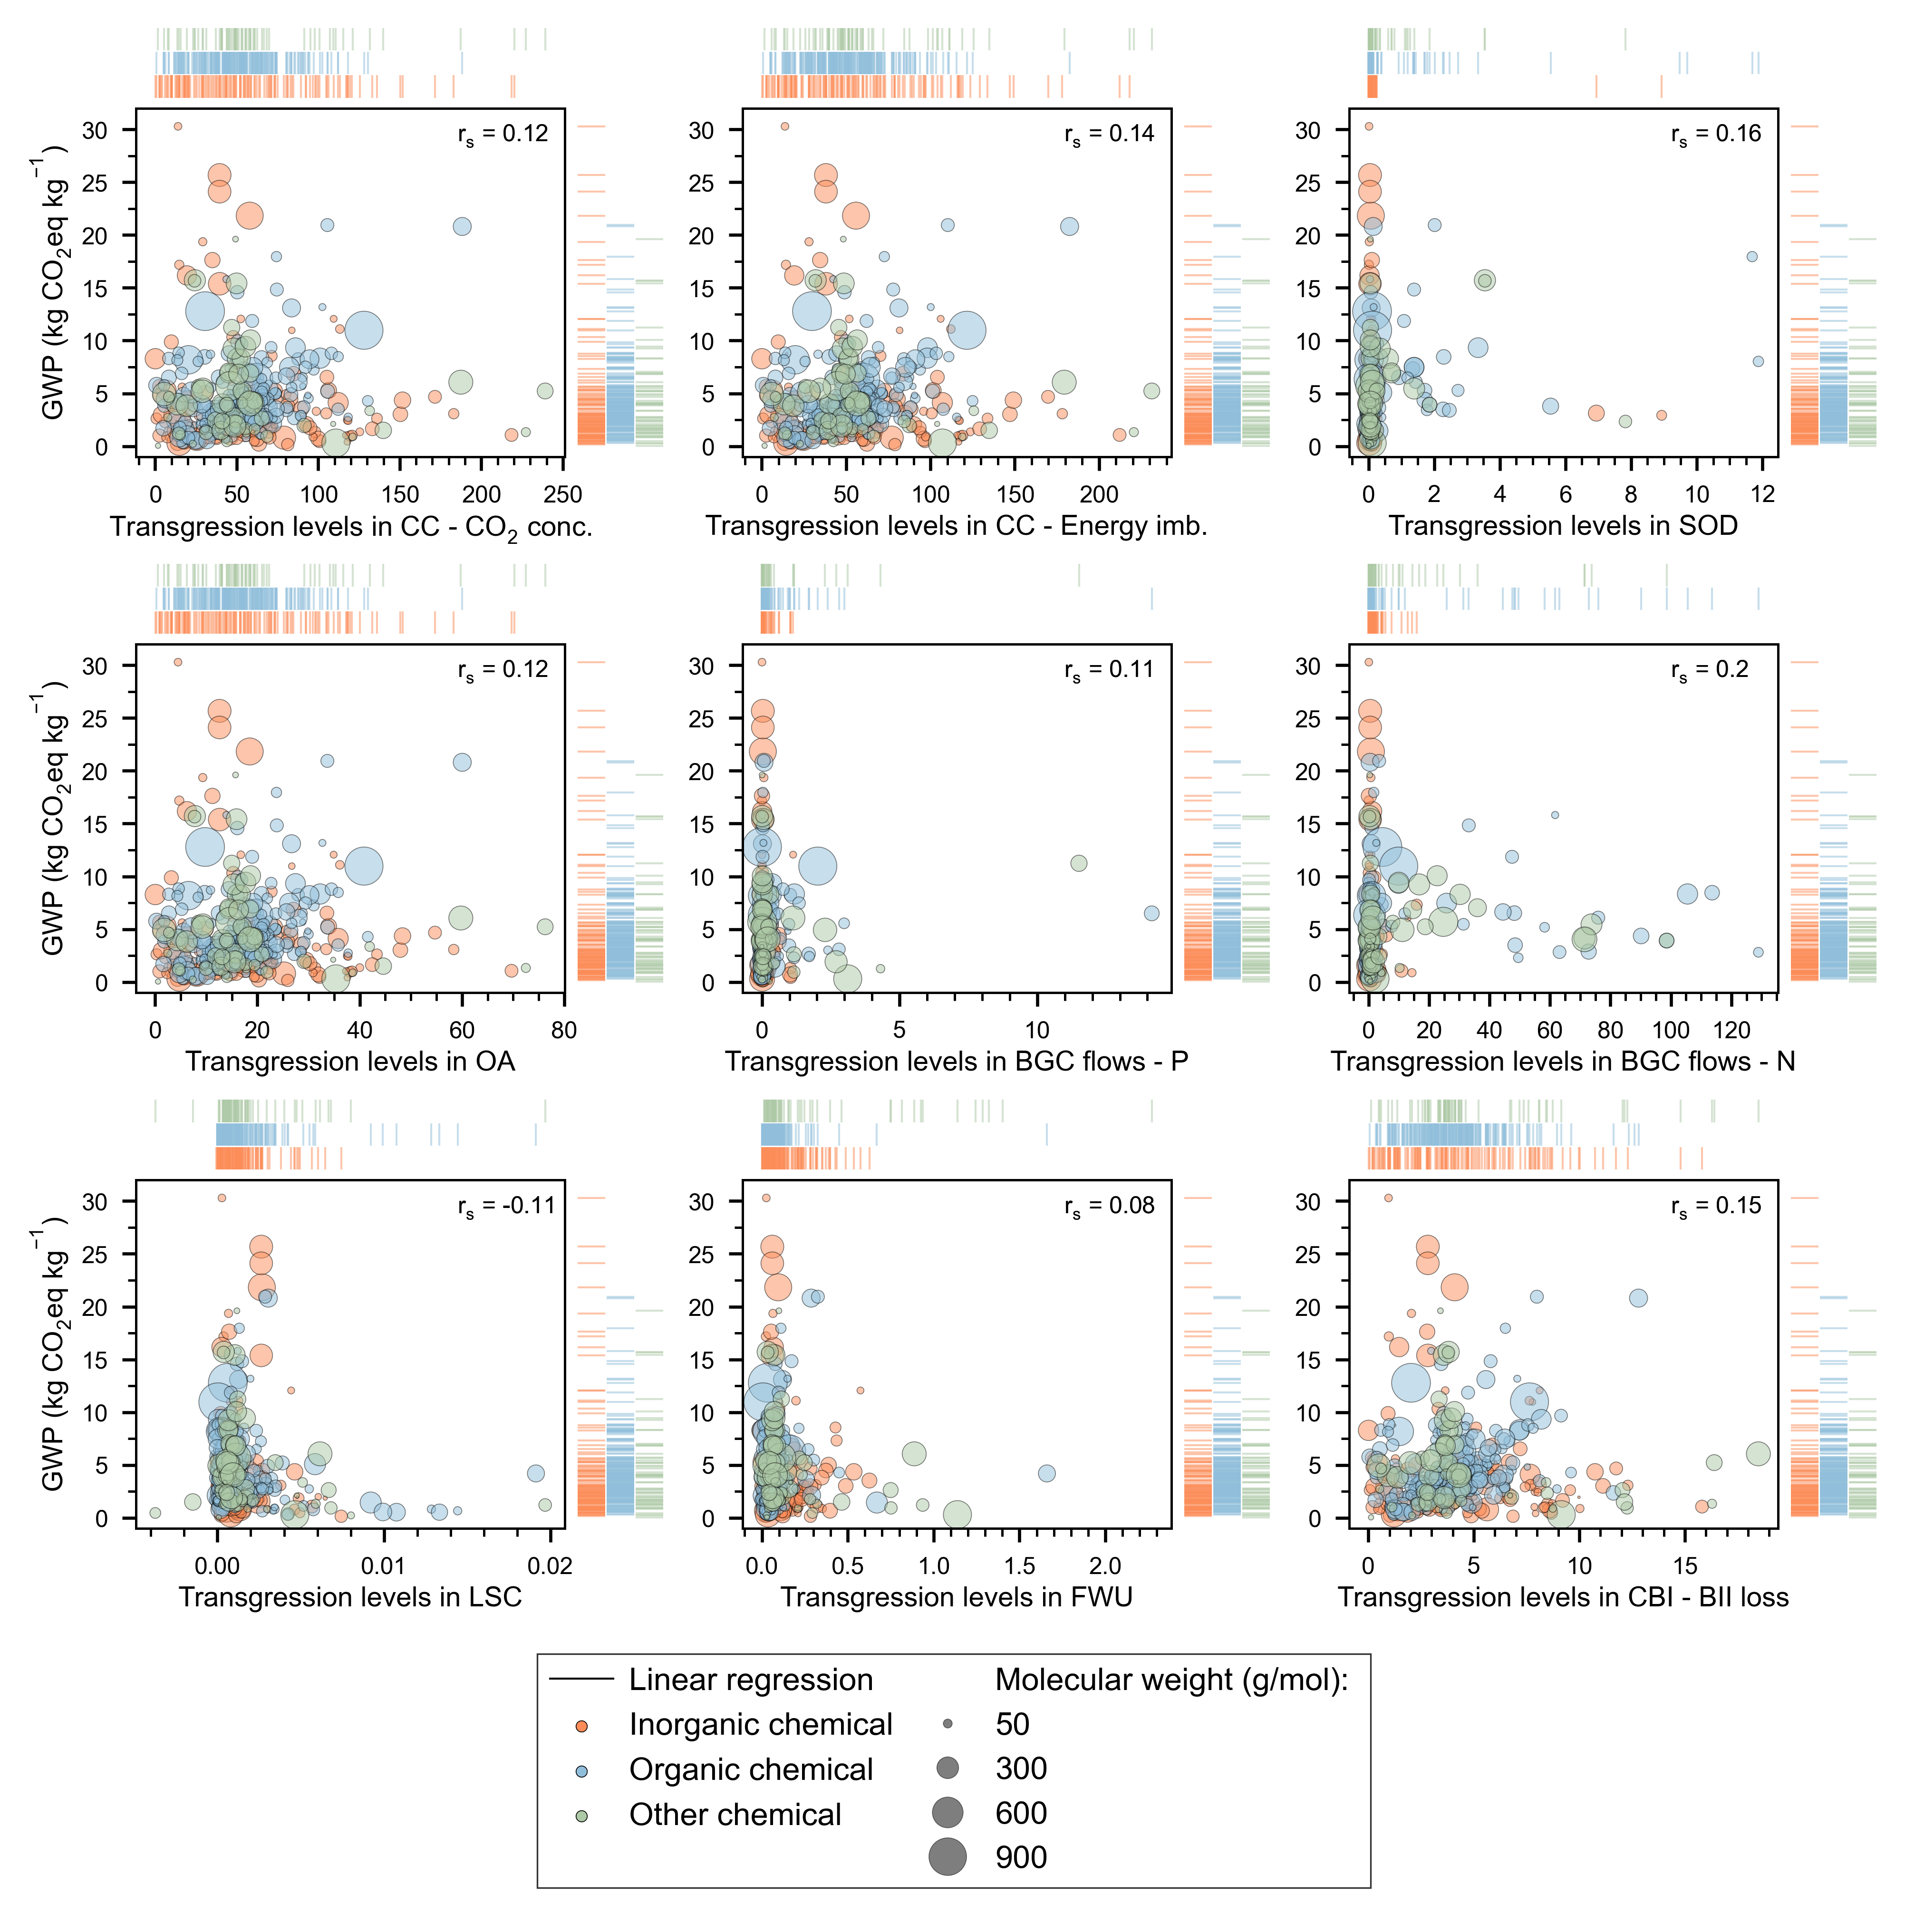

In [114]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS"
loop_methods = lst_methods_TLs

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

######################


size_legend_font = 8

## personalized legend handler adapted from https://stackoverflow.com/a/57697692/14485040
import string

from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text


class TextHandlerB(HandlerBase):
    def create_artists(
        self, legend, text, xdescent, ydescent, width, height, fontsize, trans
    ):
        tx = Text(
            width / 2.0,
            height / 2,
            text,
            fontsize=size_legend_font,
            ha="center",
            va="center",
            fontweight="normal",
        )
        return [tx]


Legend.update_default_handler_map({str: TextHandlerB()})
#######################


fig_width, fig_height = 171, 171
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 14  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 2  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.84, 0.16],
    #     wspace=0.15,
    hspace=0.1,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)


# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=3,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.15,
    hspace=0.25,
)


for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]
    y_raw = df_toplot[lst_methods[0]]
    # Remove Nan values
    mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
    x = x_raw[mask]
    y = y_raw[mask]
#     y = np.log(y_raw[mask])  # !!! CHANGEd DUE TO set_yscale("log")

    # Linear regression
    (X, Y_pred), Rsquare, _ = linear_regr(x, y)
    
    # Spearman's rank correlation coefficient
    # assesses monotonic relationships between variables
    r_spearman = x.corr(y, method='spearman').round(2)
    r_spearman_text = "$r_{s}$ = " + str(r_spearman)

    # Pearson correlation coefficient
    # assesses linear relationships between variables
    r_pearson = x.corr(y, method='pearson').round(2)
    
    print("r_spearman is {}\nr_pearson is {}".format(r_spearman, r_pearson))

    # Grid specification (level:1)
    gs_PB = gs[gsx].subgridspec(
        nrows=2,
        ncols=2,
#         width_ratios=[1.5, 1],
        width_ratios=[1.5, 0.3],
        wspace=0.05,
#         height_ratios=[1, 1.5],
        height_ratios=[0.3, 1.5],
        hspace=0.05,
    )

    # Grid specification (level:2)
    ax_1 = gs_PB[0].subgridspec(
#         nrows=4, ncols=1, height_ratios=[3, 0.5, 0.5, 0.5], hspace=0.05,
        nrows=3, ncols=1, height_ratios=[0.5, 0.5, 0.5], hspace=0.05,        
    )
    ax_4 = gs_PB[3].subgridspec(
#         nrows=1, ncols=4, width_ratios=[0.5, 0.5, 0.5, 3], wspace=0.05,
        nrows=1, ncols=3, width_ratios=[0.5, 0.5, 0.5], wspace=0.05,
    )

    # Subplots ....
    ax_2 = fig.add_subplot(gs_PB[1])  # annotation
    ax_3 = fig.add_subplot(gs_PB[2])  # scatter plot
    # ======
#     ax_1_hist = fig.add_subplot(ax_1[0], sharex=ax_3)  # histogram top
#     ax_4_hist = fig.add_subplot(ax_4[3], sharey=ax_3)  # histogram left

    # ---------- annotation ----------
#     stat_text = calculate_stats(x)
#     #     stat_of_GWP = calculate_stats(y)
#     #     pprint.pprint(stat_of_GWP)
#     ax_2.text(
#         0.15,
#         0.3,
#         stat_text,
#         fontsize=5.5,
#         linespacing=1,
#         va="bottom",
#         ha="left",
#         multialignment="left",
#         bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
#         # frameon=True, # prop=dict(size=6),  #loc="center",
#     )
#     #     ax_2.arrow(0, 0.5, -0.15, 0, head_width=0.005, head_length=0.01, fc='k', ec='k')
#     ax_2.annotate(
#         "",
#         xy=(0.14, 0.7),
#         xycoords="axes fraction",
#         xytext=(-0.1, 0.7),
#         arrowprops=dict(
#             arrowstyle="<|-, head_length=0.3, head_width=0.15",
#             color="k",
#             linewidth=0.3,
#         ),
#     )
    ax_2.axis("off")

    grouped = dict(list(df_toplot.groupby("category_regrouped")))
    tot_keys = len(grouped)

    scplot_list = []  # store PathCollection of each scatter plot
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]
        y_group_raw = group[lst_methods[0]]

        #         size_to_plot = "complexity_norm"
        #         size_to_plot = "MW_norm"
        size_to_plot = "MW"
        if size_to_plot == "complexity_norm":
            s_group_raw = group["complexity_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized compound complexity (%): "
        elif size_to_plot == "MW_norm":
            s_group_raw = group["MW_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized molecular weight (%): "
        elif size_to_plot == "MW":
            s_group_raw = group["MW"] * 0.1  # !!!!!!!!!!!!!!!
            size_label = "Molecular weight (g/mol): "

        # Remove Nan values
        mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
        x_group = x_group_raw[mask_group]
        y_group = y_group_raw[mask_group]
        s_group = s_group_raw[mask_group]  # !!!!!!!!!!!!!!!
        print("min size: {}, max size: {}".format(s_group.min(), s_group.max()))

        # ---------- scatter plot ---------------
        scplot = ax_3.scatter(
            x=x_group,
            y=y_group,
            c=plot_colors[key],
            #             label=key,
            alpha=0.5,
            s=s_group,  # 4, # !!!!!!!!!!!!!!!
            linewidths=0.2,
            ec="k",
        )
        scplot_list.append(scplot)
        # ---------- regression line ---------------
#         ax_3.plot(
#             X, Y_pred, color="black", lw=0.5,
#         )  # label="Linear regression")

        # position of Rsquared label (relative to fraction of the axes)
        ##### replace Rsquare with r_spearman
#         if namedf  == "df_base_full_wCAS_woOutliersRMDk9a5":
#             if gsx == 7:
#                 xposR2 = 0.7
#             else:
#                 xposR2 = 0.55
#         else:
#             xposR2 = 0.6  # 0.02
        xposR2 = 0.75
        yposR2 = 0.92

        ax_3.text(
            xposR2,
            yposR2,
#             Rsquare,
            r_spearman_text,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax_3.transAxes,
            bbox=dict(
                boxstyle="square,pad=.1", facecolor="white", alpha=0.5, ec="white"
            ),
            #             backgroundcolor="white",
            fontsize=6,
        )

        #         ############ !!!!!!!!!!!!!!!!!! plot the highlighted products  # NO highlighted_products
        #         xlim_ax = ax_3.get_xlim()
        #         xaxis_size = xlim_ax[1] - xlim_ax[0]
        #         xoffset = 0.05 * xaxis_size
        #         ylim_ax = ax_3.get_ylim()
        #         yaxis_size = ylim_ax[1] - ylim_ax[0]
        #         yoffset = -0.005 * yaxis_size

        #         for n, prod in enumerate(highlighted_product):
        #             i_prod = [i for i in group.index if prod == group.referenceProduct[i]]
        #             try:
        #                 if i_prod:
        #                     ax_3.scatter(x_group[i_prod], y_group[i_prod],
        #                                  marker="X", c="r", s=8, linewidths=0.2, ec="k", zorder=2.5)

        #                     xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)
        #                     ax_3.annotate(n + 1, xy_coor, fontsize=6, color="k")
        #             except:
        #                 pass
        #         ############ !!!!!!!!!!!!!!!!!!

        # ---------- top rug plots ---------------
#         ax_1_rug = fig.add_subplot(ax_1[tot_keys - i], sharex=ax_3)
        ax_1_rug = fig.add_subplot(ax_1[tot_keys - i-1], sharex=ax_3)
        sns.rugplot(
            x=x_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_1_rug,
        )
        ax_1_rug.spines["top"].set_visible(False)
        ax_1_rug.spines["bottom"].set_visible(False)
        ax_1_rug.spines["left"].set_visible(False)
        ax_1_rug.spines["right"].set_visible(False)
        ax_1_rug.axis("off")
        #         ax_1_rug.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])

        # ---------- right rug plots ---------------
        ax_4_rug = fig.add_subplot(ax_4[i], sharey=ax_3)
        sns.rugplot(
            y=y_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_4_rug,
        )
        ax_4_rug.spines["top"].set_visible(False)
        ax_4_rug.spines["bottom"].set_visible(False)
        ax_4_rug.spines["left"].set_visible(False)
        ax_4_rug.spines["right"].set_visible(False)
        ax_4_rug.axis("off")
    #         ax_4_rug.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])

    # ~######################## ax_3 axes ######  
    #         ax_3.set_ylabel(ylabel="Global Warming Potential (kg $CO_{2-eq}$)")
    ax_3.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=2.3)
#         xlabelname = "\n".join(
#             textwrap.wrap(dict_pbs_plot[cat][0] + " (" + dict_pbs_plot[cat][1] + ")", 50)
#         )
    xlabelname = "\n".join(
        textwrap.wrap("Transgression levels in " + dict_pbs_plot[cat][0], 50)
    )

#         ax_3.set_xlabel(xlabel=xlabelname, labelpad=0.2)
    ax_3.set_xlabel(xlabel=xlabelname, labelpad=2)

    xlim_ax3 = ax_3.get_xlim()
    ylim_ax3 = ax_3.get_ylim()

    if gsx in [1, 2, 4, 5, 7, 8]:
        # ax_3.set_yticks([])
        ax_3.set_ylabel(None)
    #         ax_3.get_yaxis().set_visible(False)
    #     ax_3.grid(True)
#         ax_3.set_yscale('log')
    
    # Y axis limit
    ax_3.set_ylim(top=32)
    ax_3.set_ylim(bottom=-1)
    ax_3.yaxis.set_major_locator(MultipleLocator(5))
    ax_3.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~
    # --- Format the scale of x axis ---
    dict_major_multiplelocators_minorlocators = {0.01: 5, 0.2: 2, 0.5: 5, 1: 5, 2: 4, 5: 5, 10: 5, 20: 4}
    list_of_major_multiplelocators = list(dict_major_multiplelocators_minorlocators.keys())
    axis_range = abs(max(ax_3.get_xticks())- min(ax_3.get_xticks()))
    divs = []
    for i in range(4,11): # roughtly the number of majorlocators should be between 4 and 10
        division = axis_range/i
        divs.append(division)

    closest = {}
    for i_n, n in enumerate(divs):
        for i_m, m in enumerate(list_of_major_multiplelocators):
            close = abs(m - n)
            coordinate = (i_n, i_m)
            closest[coordinate] = close
    coord = [k for k,v in closest.items() if min(closest.values()) == v]
    maj_multlocator = list_of_major_multiplelocators[coord[0][1]]
    min_autominlocator = dict_major_multiplelocators_minorlocators[maj_multlocator]
    
    if max(ax_3.get_xticks()) > 150:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        min_exp = -2  # -1
        max_exp = 3  # 1
        formatter.set_powerlimits((min_exp, max_exp))
        ax_3.xaxis.set_major_formatter(formatter)
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(5))
        # ~~~~ move the formatter inside the axes box
        ## from https://stackoverflow.com/a/59018067/14485040
        ax_3.get_xaxis().get_offset_text().set_visible(
            False
        )  # .set_position((1.1,0)) # only moves on its x-axis
        ax_max = max(ax_3.get_xticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        if exponent_axis <= min_exp or exponent_axis >= max_exp:
            ax_3.annotate(
                r"$\times$10$^{%i}$" % (exponent_axis),
                #             xy=(0.76, 0.02),
                xy=(1.001, -0.08),
                xycoords="axes fraction",
                fontsize=6,
            )
    else:
        ax_3.xaxis.set_major_locator(MultipleLocator(maj_multlocator))
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(min_autominlocator))   
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

#     # ---------- histogram top ---------------
#     ax_1_hist.hist(x, bins=50, color="grey")
#     #     ax_1_hist.set_xticks([])  # next 2 lines do this
#     ax_1_hist.tick_params(labelbottom=False)
#     #     ax_1_hist.tick_params(axis='x', which='both', length=0)
#     ax_1_hist.spines["top"].set_visible(False)
#     #     ax_1_hist.spines['left'].set_visible(False)
#     ax_1_hist.spines["right"].set_visible(False)
#     #     ax_1_hist.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])
#     #     ax_1_hist.yaxis.set_major_locator(MultipleLocator(2))
#     ax_1_hist.yaxis.set_minor_locator(AutoMinorLocator(5))

#     # ---------- histogram right ---------------
#     ax_4_hist.hist(y, bins=50, orientation="horizontal", color="grey")
#     #     ax_4_hist.set_yticks([]) # next 2 lines do this
#     ax_4_hist.tick_params(labelleft=False)
#     #     ax_4_hist.tick_params(axis='y', which='both', length=0)
#     ax_4_hist.xaxis.tick_top()
#     #     ax_4_hist.spines['top'].set_visible(False)
#     ax_4_hist.spines["bottom"].set_visible(False)
#     ax_4_hist.spines["right"].set_visible(False)
#     #     ax_4_hist.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])
#     #     ax_4_hist.xaxis.set_major_locator(MultipleLocator(2))
#     ax_4_hist.xaxis.set_minor_locator(AutoMinorLocator(5))


# Legend
# gs_legend = fig.add_subplot(gs[3, :])
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

# size of the bubbles
# taken from https://stackoverflow.com/a/58485655/14485040
# and here https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

# ####
# getting from the last subplot the category with the largest range size
# ideally the largest range size will contain the exact values
# which I want to show in the legend (the ones in sizes_on_legend) - make sure this is true
range_size_dict = dict()
for p in scplot_list:
    range_size = p.get_sizes().max() - p.get_sizes().min()
    range_size_dict[p] = range_size
max_range_size = max(range_size_dict.values())
scplot = [k for k, v in range_size_dict.items() if v == max_range_size][
    0
]  # getting the PathCollection with the largest range size
# ####
sizes_on_legend = [5, 30, 60, 90]  # they have to be divided by 0.1
handles_size, labels_size = scplot.legend_elements("sizes", num=sizes_on_legend)
labels_size = [int(i / 0.1) for i in sizes_on_legend]

# the other items of the legend
for key, group in grouped.items():
    ax_3.scatter(
        [],
        [],
        color=plot_colors[key],
        label=key,
        marker="o",
        s=8,
        linewidths=0.2,
        ec="k",
    )
ax_3.scatter(
    [], [], color="w", lw=0.0, label=" "
)  # dummy name placeholder to accomodate 2 columns
# ax_3.scatter([], [], marker="X", c="r", s=8, linewidths=0.2, ec="k", label="Highlighted chemical") # NO highlighted_products
ax_3.plot([], [], color="black", lw=0.5, label="Linear regression")
ax_3.scatter(
    [], [], color="w", lw=0.0, label=size_label
)  # dummy name placeholder 1, size_label defined above by "size_to_plot"
handles_other, labels_other = ax_3.get_legend_handles_labels()

# # highlighted_products # NO highlighted_products
# handles_hp, labels_hp = zip(*enumerate(highlighted_product))
# handles_hp = list(string.digits)[1:len(highlighted_product)+1] # [""] + list(string.digits)[1:len(highlighted_product)+1]
# labels_hp = list(labels_hp) # ["Chemicals: "] + list(labels_hp)

# Number of colums in the legend
ncolumns_legend = 2

if ncolumns_legend == 2:
    handles, labels = handles_other + handles_size, labels_other + labels_size
elif ncolumns_legend == 3:
    handles, labels = (
        handles_other + handles_size + handles_hp,
        labels_other + labels_size + labels_hp,
    )
#     extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
elif ncolumns_legend == 5:
    # alternate items of the 2 sublists in order to plot the legend in 2 ROWS!
    handles = [
        item
        for sublist in itertools.zip_longest(handles_other, handles_size)
        for item in sublist
    ]
    handles = [x for x in handles if x is not None]
    handles = [
        handles[0],
        handles[9],
        handles[2],
        handles[1],
        handles[4],
        handles[3],
        handles[6],
        handles[5],
        handles[8],
        handles[7],
    ]

    labels = [
        item
        for sublist in itertools.zip_longest(labels_other, labels_size)
        for item in sublist
    ]
    labels = [x for x in labels if x is not None]
    labels = [
        labels[0],
        labels[9],
        labels[2],
        labels[1],
        labels[4],
        labels[3],
        labels[6],
        labels[5],
        labels[8],
        labels[7],
    ]
else:
    handles, labels = handles_size + handles_other, labels_size + labels_other


leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.47, 0.0),
    ncol=ncolumns_legend,  # see above
    fontsize=size_legend_font,
    fancybox=False,
    handletextpad=0.5,
    columnspacing=0.7,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

### EXPORT FIGURE
# figNamePNG = "Fig3_{}.png".format(namedf)
# figNameSVG = "Fig3_{}.svg".format(namedf)

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

In [115]:
df_toplot.referenceProduct_price.max()

1420.8220988372093

In [116]:
df_toplot

Activity  category_regrouped  \
0     1,1-difluoroethane, HFC-152a {GLO}| market for...    Organic chemical   
1                 1-butanol {GLO}| market for | APOS, S    Organic chemical   
2                1-pentanol {GLO}| market for | APOS, S    Organic chemical   
3                1-propanol {GLO}| market for | APOS, S    Organic chemical   
4     2,4-di-tert-butylphenol {GLO}| market for 2,4-...    Organic chemical   
...                                                 ...                 ...   
1082  Propylene, pipeline system, combined to GLO ma...    Organic chemical   
1083       Uranium hexafluoride, combined to GLO market      Other chemical   
1084  Diethyl ether, without water, in 99.95% soluti...    Organic chemical   
1085      Silicon tetrachloride, combined to GLO market  Inorganic chemical   
1087           Trichloropropane, combined to GLO market    Organic chemical   

                                       activity_comment      type  \
0     Production volume: 7500000 kgIncluded activ...  Products   
1     Production volume: 2594880000 kgIncluded ac...  Products   
2     Production volume: 110400000 kgIncluded act...  Products   
3     Production volume: 347701149.425287 kgInclu...  Products   
4     This dataset represents the supply of 1 kg of ...  Products   
...                                                 ...       ...   
1082                                               None  Products   
1083                                               None  Products   
1084                                               None  Products   
1085                                               None  Products   
1087                                               None  Products   

                                       referenceProduct  \
0                          1,1-difluoroethane, HFC-152a   
1                                             1-butanol   
2                                            1-pentanol   
3                                            1-propanol   
4                               2,4-di-tert-butylphenol   
...                                                 ...   
1082                         Propylene, pipeline system   
1083                               Uranium hexafluoride   
1084  Diethyl ether, without water, in 99.95% soluti...   
1085                              Silicon tetrachloride   
1087                                   Trichloropropane   

                           category  \
0          Chemicals\Organic\Market   
1          Chemicals\Organic\Market   
2          Chemicals\Organic\Market   
3          Chemicals\Organic\Market   
4          Chemicals\Organic\Market   
...                             ...   
1082       Chemicals\Organic\Market   
1083  Fuels\Uranium\Enriched\Market   
1084       Chemicals\Organic\Market   
1085     Chemicals\Inorganic\Market   
1087       Chemicals\Organic\Market   

                                    inline_comment  geo  \
0              Production Volume Amount: 7500000  GLO   
1           Production Volume Amount: 2594880000  GLO   
2            Production Volume Amount: 110400000  GLO   
3     Production Volume Amount: 347701149.425287  GLO   
4             Production Volume Amount: 25000000  GLO   
...                                            ...  ...   
1082                                          None  GLO   
1083                                          None  GLO   
1084                                          None  GLO   
1085                                          None  GLO   
1087                                          None  GLO   

                                  activity_ISICclass activity_ecoSpold01class  \
0                2011:Manufacture of basic chemicals       chemicals/organics   
1                2011:Manufacture of basic chemicals       chemicals/organics   
2                2011:Manufacture of basic chemicals       chemicals/organics   
3                2011:Manufacture of basic chemicals      

In [117]:
# LIST OF CHEMICALS NOT SHOWN ON FIG3 DUE TO HIGH GWP SCORES...
#this list or graphical representation will be shown in ESI?

df_toplot[df_toplot[lst_methods[0]] > 32].sort_values(
    by="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"
)#.shape

Activity  category_regrouped  \
350                 Lithium {GLO}| market for | APOS, S  Inorganic chemical   
568    Silicon, solar grade {GLO}| market for | APOS, S  Inorganic chemical   
1003  Silicon, multi-si, casted, combined to GLO market  Inorganic chemical   
895               Aminopyridine, combined to GLO market    Organic chemical   
559   Silicon, electronics grade {GLO}| market for |...  Inorganic chemical   
16              2-pyridinol {GLO}| market for | APOS, S    Organic chemical   
660     Tetrafluoroethylene {GLO}| market for | APOS, S    Organic chemical   
659   Tetrafluoroethylene film, on glass {GLO}| mark...    Organic chemical   
275   Gallium, semiconductor-grade {GLO}| market for...  Inorganic chemical   
1083       Uranium hexafluoride, combined to GLO market      Other chemical   
1005  Silicon, single crystal, czochralski process, ...      Other chemical   
338        Krypton, gaseous {GLO}| market for | APOS, S      Other chemical   
317                  Indium {GLO}| market for | APOS, S  Inorganic chemical   
652   Tantalum, powder, capacitor-grade {GLO}| marke...  Inorganic chemical   
1004  Silicon, single crystal, czochralski process, ...  Inorganic chemical   
1039             Xenon, gaseous, combined to GLO market  Inorganic chemical   
879   Uranium, enriched 3.0%, in fuel element for li...      Other chemical   
880   Uranium, enriched 3.8%, in fuel element for li...      Other chemical   
881   Uranium, enriched 3.9%, in fuel element for li...      Other chemical   
882   Uranium, enriched 4%, in fuel element for ligh...      Other chemical   
883   Uranium, enriched 4.2%, in fuel element for li...      Other chemical   

                                       activity_comment      type  \
350   Production volume: 1000000 kgIncluded activ...  Products   
568   Production volume: 14399973.9475398 kgInclu...  Products   
1003                                               None  Products   
895                                                None  Products   
559   Production volume: 17600000 kgIncluded acti...  Products   
16    Production volume: 10000000 kgIncluded acti...  Products   
660   This dataset represents the supply of 1 kg of ...  Products   
659   In this market, expert judgement was used to d...  Products   
275   Production volume: 1 kgIncluded activities ...  Products   
1083                                               None  Products   
1005                                               None  Products   
338   This is a constrained market, i.e. it contains...  Products   
317   Production volume: 492500 kgIncluded activi...  Products   
652   Production volume: 1 kgIncluded activities ...  Products   
1004                                               None  Products   
1039                                               None  Products   
879   Production volume: 2895442.35924933 kgInclu...  Products   
880   Production volume: 2033898.30508475 kgInclu...  Products   
881   Production volume: 1956521.73913044 kgInclu...  Products   
882   Production volume: 1888111.88811189 kgInclu...  Products   
883   Production volume: 1764705.88235294 kgInclu...  Products   

                                       referenceProduct  \
350                                             Lithium   
568                                Silicon, solar grade   
1003                          Silicon, multi-si, casted   
895                                       Aminopyridine   
559                          Silicon, electronics grade   
16                                          2-pyridinol   
660                                 Tetrafluoroethylene   
659                  Tetrafluoroethylene film, on glass   
275                        Gallium, semiconductor-grade   
1083                               Uranium hexafluoride   
1005  Silicon, single crystal, czochralski process, ...   
338                                    Krypton, gaseous   
317                   

#### Fig3 ver2

In [118]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS" # TAKES A LOT TO PLOT...
loop_methods = lst_methods[1:]

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

######################
print("Used df: ", namedf)

size_legend_font = 8

## personalized legend handler adapted from https://stackoverflow.com/a/57697692/14485040
import string

from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text


class TextHandlerB(HandlerBase):
    def create_artists(
        self, legend, text, xdescent, ydescent, width, height, fontsize, trans
    ):
        tx = Text(
            width / 2.0,
            height / 2,
            text,
            fontsize=size_legend_font,
            ha="center",
            va="center",
            fontweight="normal",
        )
        return [tx]


Legend.update_default_handler_map({str: TextHandlerB()})
#######################


fig_width, fig_height = 171, 180
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 14  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 2  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.84, 0.16],
    #     wspace=0.15,
    hspace=0.05,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)


# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=3,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.20,
    hspace=0.25,
)

for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]
    y_raw = df_toplot[lst_methods[0]]
    # Remove Nan values
    mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
    x = x_raw[mask]
    y = y_raw[mask]

    # Linear regression
    (X, Y_pred), Rsquare, _ = linear_regr(x, y)

    # Grid specification (level:1)
    gs_PB = gs[gsx].subgridspec(
        nrows=2,
        ncols=2,
        width_ratios=[1.5, 1],
        wspace=0.05,
        height_ratios=[1, 1.5],
        hspace=0.05,
    )

    # Grid specification (level:2)
    ax_1 = gs_PB[0].subgridspec(
        nrows=4, ncols=1, height_ratios=[3, 0.5, 0.5, 0.5], hspace=0.05,
    )
    ax_4 = gs_PB[3].subgridspec(
        nrows=1, ncols=4, width_ratios=[0.5, 0.5, 0.5, 3], wspace=0.05,
    )

    # Subplots ....
    ax_2 = fig.add_subplot(gs_PB[1])  # annotation
    ax_3 = fig.add_subplot(gs_PB[2])  # scatter plot
    # ======
    ax_1_hist = fig.add_subplot(ax_1[0], sharex=ax_3)  # histogram top
    ax_4_hist = fig.add_subplot(ax_4[3], sharey=ax_3)  # histogram left

    # ---------- annotation ----------
    stat_text = calculate_stats(x)
    #     stat_of_GWP = calculate_stats(y)
    #     pprint.pprint(stat_of_GWP)
    ax_2.text(
        0.15,
        0.3,
        stat_text,
        fontsize=5.5,
        linespacing=1,
        va="bottom",
        ha="left",
        multialignment="left",
        bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
        # frameon=True, # prop=dict(size=6),  #loc="center",
    )
    #     ax_2.arrow(0, 0.5, -0.15, 0, head_width=0.005, head_length=0.01, fc='k', ec='k')
    ax_2.annotate(
        "",
        xy=(0.14, 0.7),
        xycoords="axes fraction",
        xytext=(-0.1, 0.7),
        arrowprops=dict(
            arrowstyle="<|-, head_length=0.3, head_width=0.15",
            color="k",
            linewidth=0.3,
        ),
    )
    ax_2.axis("off")

    grouped = dict(list(df_toplot.groupby("category_regrouped")))
    tot_keys = len(grouped)

    scplot_list = []  # store PathCollection of each scatter plot
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]
        y_group_raw = group[lst_methods[0]]

        #         size_to_plot = "complexity_norm"
        #         size_to_plot = "MW_norm"
        size_to_plot = "MW"
        if size_to_plot == "complexity_norm":
            s_group_raw = group["complexity_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized compound complexity (%): "
        elif size_to_plot == "MW_norm":
            s_group_raw = group["MW_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized molecular weight (%): "
        elif size_to_plot == "MW":
            s_group_raw = group["MW"] * 0.1  # !!!!!!!!!!!!!!!
            size_label = "Molecular weight (g/mol): "

        # Remove Nan values
        mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
        x_group = x_group_raw[mask_group]
        y_group = y_group_raw[mask_group]
        s_group = s_group_raw[mask_group]  # !!!!!!!!!!!!!!!
        print("min size: {}, max size: {}".format(s_group.min(), s_group.max()))

        # ---------- scatter plot ---------------
        scplot = ax_3.scatter(
            x=x_group,
            y=y_group,
            c=plot_colors[key],
            #             label=key,
            alpha=0.5,
            s=s_group,  # 4, # !!!!!!!!!!!!!!!
            linewidths=0.2,
            ec="k",
        )
        scplot_list.append(scplot)

        #         ax_3.set_ylabel(ylabel="Global Warming Potential (kg $CO_{2-eq}$)")
        ax_3.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=2.3)

        xlabelname = "\n".join(
            textwrap.wrap(dict_pbs[cat][0] + " (" + dict_pbs[cat][1] + ")", 50)
        )
        ax_3.set_xlabel(xlabel=xlabelname, labelpad=0.2)

        xlim_ax3 = ax_3.get_xlim()
        ylim_ax3 = ax_3.get_ylim()

        if gsx in [1, 2, 4, 5, 7, 8]:
            #             ax_3.set_yticks([])
            ax_3.set_ylabel(None)
        #         ax_3.get_yaxis().set_visible(False)
        #     ax_3.grid(True)

#         ax_3.yaxis.set_major_locator(MultipleLocator(10))
        ax_3.yaxis.set_minor_locator(AutoMinorLocator(5))
        #         ax_3.xaxis.set_major_locator(MultipleLocator(1))
#         ax_3.set_yscale("log") ?????????????
#         ax_3.set_xscale("log") ?????????????
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(2))

        # ---------- regression line ---------------
        ax_3.plot(
            X, Y_pred, color="black", lw=0.5,
        )  # label="Linear regression")

        # position of Rsquared label (relative to fraction of the axes)
        xposR2 = 0.02
        yposR2 = 0.92
#         if gsx in [2]:
#             xposR2 = 0.5       
#         if gsx in [4]:
#             xposR2 = 0.44
#         if gsx in [5, 6]:
#             xposR2 = 0.65           
#         if gsx in [7]:
#             xposR2 = 0.15

        ax_3.text(
            xposR2,
            yposR2,
            Rsquare,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax_3.transAxes,
            bbox=dict(
                boxstyle="square,pad=.1", facecolor="white", alpha=0.5, ec="white"
            ),
            #             backgroundcolor="white",
            fontsize=6,
        )

        #         ############ !!!!!!!!!!!!!!!!!! plot the highlighted products  # NO highlighted_products
        #         xlim_ax = ax_3.get_xlim()
        #         xaxis_size = xlim_ax[1] - xlim_ax[0]
        #         xoffset = 0.05 * xaxis_size
        #         ylim_ax = ax_3.get_ylim()
        #         yaxis_size = ylim_ax[1] - ylim_ax[0]
        #         yoffset = -0.005 * yaxis_size

        #         for n, prod in enumerate(highlighted_product):
        #             i_prod = [i for i in group.index if prod == group.referenceProduct[i]]
        #             try:
        #                 if i_prod:
        #                     ax_3.scatter(x_group[i_prod], y_group[i_prod],
        #                                  marker="X", c="r", s=8, linewidths=0.2, ec="k", zorder=2.5)

        #                     xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)
        #                     ax_3.annotate(n + 1, xy_coor, fontsize=6, color="k")
        #             except:
        #                 pass
        #         ############ !!!!!!!!!!!!!!!!!!

        # ---------- top rug plots ---------------
        ax_1_rug = fig.add_subplot(ax_1[tot_keys - i], sharex=ax_3)
        sns.rugplot(
            x=x_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_1_rug,
        )
        ax_1_rug.spines["top"].set_visible(False)
        ax_1_rug.spines["bottom"].set_visible(False)
        ax_1_rug.spines["left"].set_visible(False)
        ax_1_rug.spines["right"].set_visible(False)
        ax_1_rug.axis("off")
        #         ax_1_rug.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])

        # ---------- right rug plots ---------------
        ax_4_rug = fig.add_subplot(ax_4[i], sharey=ax_3)
        sns.rugplot(
            y=y_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_4_rug,
        )
        ax_4_rug.spines["top"].set_visible(False)
        ax_4_rug.spines["bottom"].set_visible(False)
        ax_4_rug.spines["left"].set_visible(False)
        ax_4_rug.spines["right"].set_visible(False)
        ax_4_rug.axis("off")
    #         ax_4_rug.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])

    # ~~~~~~~~~~~~  ~~~~~~~~~~~~
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    min_exp = -1
    max_exp = 1
    formatter.set_powerlimits((min_exp, max_exp))
    ax_3.xaxis.set_major_formatter(formatter)
    # ~~~~ move the formatter inside the axes box
    ## from https://stackoverflow.com/a/59018067/14485040
    ax_3.get_xaxis().get_offset_text().set_visible(
        False
    )  # .set_position((1.1,0)) # only moves on its x-axis
    ax_max = max(ax_3.get_xticks())
    exponent_axis = np.floor(np.log10(ax_max)).astype(int)
    if exponent_axis <= min_exp or exponent_axis >= max_exp:
        ax_3.annotate(
            r"$\times$10$^{%i}$" % (exponent_axis),
            #             xy=(0.76, 0.02),
            xy=(1.001, -0.08),
            xycoords="axes fraction",
            fontsize=6,
        )
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

    # ---------- histogram top ---------------
    ax_1_hist.hist(x, 
#                    bins="auto", 
                   bins=120,
                   color="grey")
    #     ax_1_hist.set_xticks([])  # next 2 lines do this
    ax_1_hist.tick_params(labelbottom=False)
    #     ax_1_hist.tick_params(axis='x', which='both', length=0)
    ax_1_hist.spines["top"].set_visible(False)
    #     ax_1_hist.spines['left'].set_visible(False)
    ax_1_hist.spines["right"].set_visible(False)
    #     ax_1_hist.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])
    #     ax_1_hist.yaxis.set_major_locator(MultipleLocator(2))
    ax_1_hist.yaxis.set_minor_locator(AutoMinorLocator(5))

    # ---------- histogram right ---------------
    ax_4_hist.hist(y, 
#                    bins="auto", 
                   bins=120,
                   orientation="horizontal", color="grey")
    #     ax_4_hist.set_yticks([]) # next 2 lines do this
    ax_4_hist.tick_params(labelleft=False)
    #     ax_4_hist.tick_params(axis='y', which='both', length=0)
    ax_4_hist.xaxis.tick_top()
    #     ax_4_hist.spines['top'].set_visible(False)
    ax_4_hist.spines["bottom"].set_visible(False)
    ax_4_hist.spines["right"].set_visible(False)
    #     ax_4_hist.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])
    #     ax_4_hist.xaxis.set_major_locator(MultipleLocator(2))
    ax_4_hist.xaxis.set_minor_locator(AutoMinorLocator(5))


# Legend
# gs_legend = fig.add_subplot(gs[3, :])
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

# size of the bubbles
# taken from https://stackoverflow.com/a/58485655/14485040
# and here https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

# ####
# getting from the last subplot the category with the largest range size
# ideally the largest range size will contain the exact values
# which I want to show in the legend (the ones in sizes_on_legend) - make sure this is true
range_size_dict = dict()
for p in scplot_list:
    range_size = p.get_sizes().max() - p.get_sizes().min()
    range_size_dict[p] = range_size
max_range_size = max(range_size_dict.values())
scplot = [k for k, v in range_size_dict.items() if v == max_range_size][
    0
]  # getting the PathCollection with the largest range size
# ####
sizes_on_legend = [5, 30, 60, 90]  # they have to be divided by 0.1
handles_size, labels_size = scplot.legend_elements("sizes", num=sizes_on_legend)
labels_size = [int(i / 0.1) for i in sizes_on_legend]

# the other items of the legend
for key, group in grouped.items():
    ax_3.scatter(
        [],
        [],
        color=plot_colors[key],
        label=key,
        marker="o",
        s=8,
        linewidths=0.2,
        ec="k",
    )
ax_3.scatter(
    [], [], color="w", lw=0.0, label=" "
)  # dummy name placeholder to accomodate 2 columns
# ax_3.scatter([], [], marker="X", c="r", s=8, linewidths=0.2, ec="k", label="Highlighted chemical") # NO highlighted_products
ax_3.plot([], [], color="black", lw=0.5, label="Linear regression")
ax_3.scatter(
    [], [], color="w", lw=0.0, label=size_label
)  # dummy name placeholder 1, size_label defined above by "size_to_plot"
handles_other, labels_other = ax_3.get_legend_handles_labels()

# # highlighted_products # NO highlighted_products
# handles_hp, labels_hp = zip(*enumerate(highlighted_product))
# handles_hp = list(string.digits)[1:len(highlighted_product)+1] # [""] + list(string.digits)[1:len(highlighted_product)+1]
# labels_hp = list(labels_hp) # ["Chemicals: "] + list(labels_hp)

# Number of colums in the legend
ncolumns_legend = 2

if ncolumns_legend == 2:
    handles, labels = handles_other + handles_size, labels_other + labels_size
elif ncolumns_legend == 3:
    handles, labels = (
        handles_other + handles_size + handles_hp,
        labels_other + labels_size + labels_hp,
    )
#     extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
elif ncolumns_legend == 5:
    # alternate items of the 2 sublists in order to plot the legend in 2 ROWS!
    handles = [
        item
        for sublist in itertools.zip_longest(handles_other, handles_size)
        for item in sublist
    ]
    handles = [x for x in handles if x is not None]
    handles = [
        handles[0],
        handles[9],
        handles[2],
        handles[1],
        handles[4],
        handles[3],
        handles[6],
        handles[5],
        handles[8],
        handles[7],
    ]

    labels = [
        item
        for sublist in itertools.zip_longest(labels_other, labels_size)
        for item in sublist
    ]
    labels = [x for x in labels if x is not None]
    labels = [
        labels[0],
        labels[9],
        labels[2],
        labels[1],
        labels[4],
        labels[3],
        labels[6],
        labels[5],
        labels[8],
        labels[7],
    ]
else:
    handles, labels = handles_size + handles_other, labels_size + labels_other


leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.47, 0.0),
    ncol=ncolumns_legend,  # see above
    fontsize=size_legend_font,
    fancybox=False,
    handletextpad=0.5,
    columnspacing=0.7,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

### EXPORT FIGURE
# figNamePNG = "Fig3_GWPvsPBs_{}.png".format(namedf)
# figNameSVG = "Fig3_GWPvsPBs_{}.svg".format(namedf)

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

Used df:  df_base_full_wCAS_woOutliersRMDk9a5
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.110

ValueError: 
1.17\\times 10^{-12}
    ^
Unknown symbol: \, found '\'  (at char 4), (line:1, col:5)

<Figure size 4039.37x4251.97 with 91 Axes>

In [119]:
df_toplot[df_toplot[lst_methods[0]]>20]

Activity  category_regrouped  \
16              2-pyridinol {GLO}| market for | APOS, S    Organic chemical   
77            Anthraquinone {GLO}| market for | APOS, S    Organic chemical   
275   Gallium, semiconductor-grade {GLO}| market for...  Inorganic chemical   
317                  Indium {GLO}| market for | APOS, S  Inorganic chemical   
338        Krypton, gaseous {GLO}| market for | APOS, S      Other chemical   
350                 Lithium {GLO}| market for | APOS, S  Inorganic chemical   
362   Meta-phenylene diamine {GLO}| market for | APO...    Organic chemical   
388              Mischmetal {GLO}| market for | APOS, S  Inorganic chemical   
399         Neodymium oxide {GLO}| market for | APOS, S  Inorganic chemical   
535      Praseodymium oxide {GLO}| market for | APOS, S  Inorganic chemical   
559   Silicon, electronics grade {GLO}| market for |...  Inorganic chemical   
568    Silicon, solar grade {GLO}| market for | APOS, S  Inorganic chemical   
622   Sodium tetrahydridoborate {GLO}| market for | ...  Inorganic chemical   
652   Tantalum, powder, capacitor-grade {GLO}| marke...  Inorganic chemical   
659   Tetrafluoroethylene film, on glass {GLO}| mark...    Organic chemical   
660     Tetrafluoroethylene {GLO}| market for | APOS, S    Organic chemical   
879   Uranium, enriched 3.0%, in fuel element for li...      Other chemical   
880   Uranium, enriched 3.8%, in fuel element for li...      Other chemical   
881   Uranium, enriched 3.9%, in fuel element for li...      Other chemical   
882   Uranium, enriched 4%, in fuel element for ligh...      Other chemical   
883   Uranium, enriched 4.2%, in fuel element for li...      Other chemical   
895               Aminopyridine, combined to GLO market    Organic chemical   
1003  Silicon, multi-si, casted, combined to GLO market  Inorganic chemical   
1004  Silicon, single crystal, czochralski process, ...  Inorganic chemical   
1005  Silicon, single crystal, czochralski process, ...      Other chemical   
1039             Xenon, gaseous, combined to GLO market  Inorganic chemical   
1083       Uranium hexafluoride, combined to GLO market      Other chemical   

                                       activity_comment      type  \
16    Production volume: 10000000 kgIncluded acti...  Products   
77    Production volume: 4 kgIncluded activities ...  Products   
275   Production volume: 1 kgIncluded activities ...  Products   
317   Production volume: 492500 kgIncluded activi...  Products   
338   This is a constrained market, i.e. it contains...  Products   
350   Production volume: 1000000 kgIncluded activ...  Products   
362   Production volume: 46100000 kgIncluded acti...  Products   
388   In this market, expert judgement was used to d...  Products   
399   Production volume: 12413500 kgIncluded acti...  Products   
535   Production volume: 4160200 kgIncluded activ...  Products   
559   Production volume: 17600000 kgIncluded acti...  Products   
568   Production volume: 14399973.9475398 kgInclu...  Products   
622   No transport by ship. The other distances redu...  Products   
652   Production volume: 1 kgIncluded activities ...  Products   
659   In this market, expert judgement was used to d...  Products   
660   This dataset represents the supply of 1 kg of ...  Products   
879   Production volume: 2895442.35924933 kgInclu...  Products   
880   Production volume: 2033898.30508475 kgInclu...  Products   
881   Production volume: 1956521.73913044 kgInclu...  Products   
882   Production volume: 1888111.88811189 kgInclu...  Products   
883   Production volume: 1764705.88235294 kgInclu...  Products   
895                                                None  Products   
1003                                               None  Products   
1004                                               None  Products   
1005                                               None  Products   
1039                                    

#### One by one -- temporal

In [120]:
# Remove Nan values
x_raw = df_TLs[lst_methods[1]]#.to_numpy()
x_raw = x_raw.astype(np.float64)
mask = ~np.isnan(x_raw)
x = x_raw[mask]

fig = create_fig((40,40), dpi=600)
ax = fig.subplots()

ax.hist(x, bins=50, cumulative=False, histtype="bar", color="gray", ec="k", lw=0.1, density=False, alpha=0.5); #, zorder=1);
ax2= ax.twinx()
ax2.hist(x, bins=120, cumulative=True, histtype="step", color="red", lw=0.3, density=True); #, zorder=1);
fix_hist_CDF_drop_line_at_end(ax2)

# --- Format the scale of x axis ---
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax2.yaxis.set_major_locator(MultipleLocator(0.2))
ax2.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim(top=103)
ax2.set_ylim(top=1.03)

ax.axvline(1, color="tab:blue", linestyle="--", linewidth=0.6)

ax.grid(True)
ax.xaxis.grid(True, which="major", ls="-", lw=0.3, zorder=4)
ax.xaxis.grid(True, which="minor", ls=":", lw=0.3, zorder=4)
ax.yaxis.grid(True, which="minor", ls=":", lw=0.3, zorder=4)
ax.yaxis.grid(True, which="major", ls="-", lw=0.3, zorder=4)
ax.set_axisbelow(False)

NameError: name 'df_TLs' is not defined

### fig 4 (NEW heatmap)
<div class="alert alert-block alert-info">
  Heatmap of highlighted chemicals. Show in columns: <br>
    - GWP  <br>
    - Transgression level of PBs <br>
    - Price <br>
</div>

In [121]:
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib.ticker import NullFormatter, StrMethodFormatter, LogLocator, ScalarFormatter

In [122]:
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

#### ** functions

In [123]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """Annotate a heatmap.
    
    Taken from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
#             kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            if data[i, j] < 0.01: # for values almost 0.00
#                 print(data[i, j])
#                 less_decimals = "{x:.0f}"
#                 less_decimals = mpl.ticker.StrMethodFormatter(less_decimals)
#                 value_formatted = less_decimals(data[i, j], None)
                value_formatted = r"$\approx$ 0"
            elif data[i, j] >= 10.00: # for values greater than 10, show 1 decimal
#                 print(data[i, j])
                less_decimals = "{x:.1f}"
                less_decimals = mpl.ticker.StrMethodFormatter(less_decimals)
                value_formatted = less_decimals(data[i, j], None)
            else:
                value_formatted = valfmt(data[i, j], None)
            text = im.axes.text(j, i, value_formatted, **kw)
            texts.append(text)

    return texts

In [124]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """Create a heatmap from a numpy array and two lists of labels.
    
    Modified from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

#     # Create colorbar
#     cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
#     cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks... ---> ticks must be created to be able to plot the data
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im#, cbar

In [126]:
def make_sequential_color_palette(min_value_hue: str, max_value_hue: str, N: 256 = int):
    """Make color palettes from two HEX colors which should be provided as extremes.
    
    Colors can be taken from: 
        1. Inkscape, 
        2. https://learnui.design/tools/data-color-picker.html
        3. https://vis4.net/palettes/#/8|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1
    
    Parameters
    ----------
    min_value_hue
        Color value in HEX format, e.g. #003f5c    
    max_value_hue
        Color value in HEX format, e.g. #003f5c
    N
        Number of colors
    """
    color_min = mpl.colors.to_rgba(min_value_hue)
    color_max = mpl.colors.to_rgba(max_value_hue)

    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(color_min[0], color_max[0], N)
    vals[:, 1] = np.linspace(color_min[1], color_max[1], N)
    vals[:, 2] = np.linspace(color_min[2], color_max[2], N)
    cmap = mpl.colors.ListedColormap(vals)

    # Visualize the same pallete with less colors
    n = 16
    vals_visual = np.ones((n, 4))
    vals_visual[:, 0] = np.linspace(color_min[0], color_max[0], n)
    vals_visual[:, 1] = np.linspace(color_min[1], color_max[1], n)
    vals_visual[:, 2] = np.linspace(color_min[2], color_max[2], n)
    palette_plot = sns.palplot(vals_visual)
    #     print("Visualization of the full sequential palette, for {} colors:\n".format(n))

    return cmap


def make_diverging_color_palette(
    min_value_hue: str, max_value_hue: str, lowest_min_value_hue="#ffffff", lowest_max_value_hue="#ffffff", N: 256 = int
):
    """
    default mid_valye_hue = "#ffffff" -> white
    
    """

    min_hue = min_value_hue
    l_min_hue = lowest_min_value_hue
    l_max_hue = lowest_max_value_hue
#     mid_hue = mid_value_hue
    max_hue = max_value_hue

    left_palette = make_sequential_color_palette(min_hue, l_min_hue, N=N)
    right_palette = make_sequential_color_palette(l_max_hue, max_hue, N=N)

    vals = np.vstack(
        (
            left_palette(np.linspace(0, 1, int(N / 2))),
            right_palette(np.linspace(0, 1, int(N / 2))),
        )
    )
    cmap = mpl.colors.ListedColormap(vals)

    # Visualize the same pallete with less colors
    n = 8
    vals_visual = np.vstack(
        (left_palette(np.linspace(0, 1, n)), right_palette(np.linspace(0, 1, n)))
    )
    palette_plot = sns.palplot(vals_visual)

    print(
        "Visualization of the parts of the palette and full palette, for {} colors:\n".format(
            n*2
        )
    )
    print("1. Left half\n2. Right half\n3. Full diverging palette\n")

    return cmap

#### pretreatment

##### Generate colors for heatmap

Visualization of the parts of the palette and full palette, for 16 colors:

1. Left half
2. Right half
3. Full diverging palette



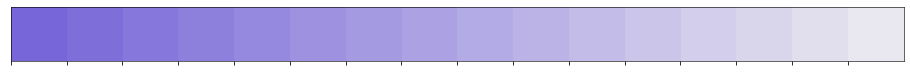

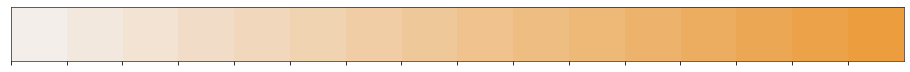

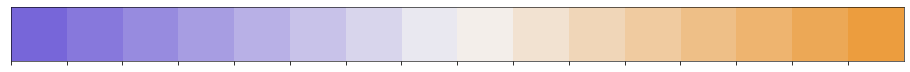

In [127]:
cmap_left = make_diverging_color_palette(
    min_value_hue="#7766d9ff",# "#7861a4", 
    max_value_hue="#ec9d3e", # "#6c7d37ff",
    lowest_min_value_hue="#e9e8f0ff",
    lowest_max_value_hue="#f3eeea", # "#e7ebdaff",
    N=256,
)

Visualization of the parts of the palette and full palette, for 16 colors:

1. Left half
2. Right half
3. Full diverging palette



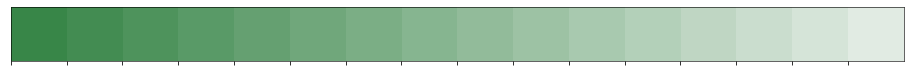

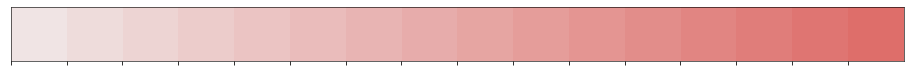

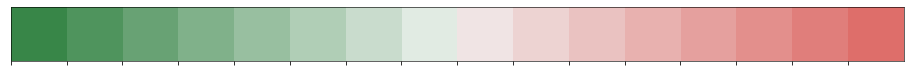

In [128]:
# cmap_center = make_diverging_color_palette(min_value_hue="#398649ff", max_value_hue="#d73e39ff", mid_value_hue="#ece7e4ff", N=256)
cmap_center = make_diverging_color_palette(
    min_value_hue="#388648ff",
    max_value_hue="#de6e6aff", # "#d73e39ff",
    lowest_min_value_hue="#e1ebe3ff",
    lowest_max_value_hue="#f0e4e4ff",
    N=256,
)

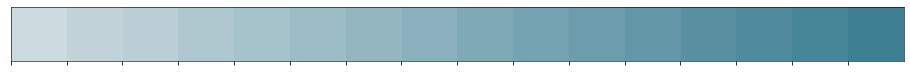

In [129]:
cmap_right = make_sequential_color_palette(
    min_value_hue="#ccdbe0ff", 
    max_value_hue="#3e7f93ff", 
    N=256
)

##### create df to plot

In [130]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5" # the same as df_base_full_wCAS_woOutliersMDk20a5
# namedf = "df_base_full_wCAS"

# pd.eval(namedf).sort_values(
#     by="TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"
# )["TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"].max()

# highlighted_product
df_heatmap_raw = pd.eval(namedf)[
    pd.eval(namedf).referenceProduct.isin(highlighted_product)
][
    [
        "referenceProduct",
        "referenceProduct_price",
        "referenceProduct_priceUnit",
        "referenceProduct_priceComment",
    ]
    + lst_methods
    + lst_methods_TLs
]

num_outliers_on_heatmap = len(highlighted_product) - df_heatmap_raw.shape[0]
print(
    "The list of selected products has {} items, the heatmap will show {}."
    "\n\t{} items are outliers (should go in gray, postproduction)".format(
        len(highlighted_product),
        df_heatmap_raw.shape[0],
        num_outliers_on_heatmap,
    )
)

df_heatmap_raw.head(2)

The list of selected products has 34 items, the heatmap will show 32.
	2 items are outliers (should go in gray, postproduction)


referenceProduct  referenceProduct_price referenceProduct_priceUnit  \
3        1-propanol                1.191194                    USD2018   
23     Acetaldehyde                1.162491                    USD2018   

                        referenceProduct_priceComment  \
3   Calculated value based on data from United Nat...   
23                 Assumed to be equal to RER prices.   

    ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
3                                            4.525119            
23                                           1.845922            

    ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
3                                        1.092401e-10                            
23                                       4.244220e-11                            

    ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
3                                        1.469075e-12                            
23                                       5.700416e-13                            

    ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
3                                        1.681898e-14                      
23                                       3.948910e-15                      

    ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
3                                        3.338089e-13                      
23                                       1.296921e-13                      

    ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')  \
3                                        1.208436e-15                   
23                                       4.537303e-16                   

    ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')  \
3                                        2.615136e-13                   
23                                       9.525698e-14                   

    ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')  \
3                                        9.806755e-16                   
23                                       1.041575e-16                   

    ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')  \
3                                        8.069268e-12                 
23                                       3.748669e-12                 

    ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')  \
3                                        1.095162e-12                                         
23                                       4.262741e-13                                         

    TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
3                                           93.998992                                  
23                                          37.422453                                  

    TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
3                                           91.015966                                  
23                                          36.188733                                  

    TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
3                                            0.071863                            
23                                           0.017289                            

    TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
3                                           29.972474                            
23                                          11.932494                            

    TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')  \
3                                            0.007562                         
23                                           0.002910                         

    TL in ('PBs-LCIA (baseline) V0.

In [131]:
# convert prices from EUR2005 to USD2018 (IT HAS BEEN IMPLEMENTED AT df_base_full LEVEL)
# using this unit the TLs were calculated !!!
if all(df_heatmap_raw.referenceProduct_priceUnit == "EUR2005"):
    PPI_2018 = 104.5 # Producer Price Index from Eurostat
    PPI_2005 = 86.0  # Producer Price Index from Eurostat
    USD_per_EUR_2018 = 1.1811 # average exchange rate EUR to USD in 2018

    df_heatmap_raw.referenceProduct_price = (df_heatmap_raw.referenceProduct_price * PPI_2018 / PPI_2005) * USD_per_EUR_2018
    df_heatmap_raw.referenceProduct_priceUnit = "USD2018"
    df_heatmap_raw.head(2)

In [132]:
# Update names of PBs and GWP
rename_methods = {
    "('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')": "Carbon footprint",
    "('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')": "Climate change - CO2 concentration",
    "('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')": "Climate change - Energy imbalance",
    "('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')": "Stratospheric ozone depletion",
    "('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')": "Ocean acidification",
    "('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')": "Biogeochemical flows - Phosphorus",
    "('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')": "Biogeochemical flows - Nitrogen",
    "('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')": "Land-system change",
    "('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')": "Freshwater use",
    "('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')": "Biosphere integrity",

    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')": "TL in Climate change - CO2 concentration",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')": "TL in Climate change - Energy imbalance",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')": "TL in Stratospheric ozone depletion",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')": "TL in Ocean acidification",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')": "TL in Biogeochemical flows - Phosphorus",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')": "TL in Biogeochemical flows - Nitrogen",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')": "TL in Land-system change",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')": "TL in Freshwater use",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')": "TL in Biosphere integrity",
    
    "referenceProduct_price": "Price",
}

df_heatmap_raw = df_heatmap_raw.rename(columns=rename_methods)
# df_heatmap_raw

In [344]:
# read the price comments

# for i in df_heatmap_raw.index:
#     if df_heatmap_raw.referenceProduct_priceComment[i] != None:
#         print(
#             "\n\t",
#             df_heatmap_raw.referenceProduct[i],
#             "\n",
#             df_heatmap_raw.referenceProduct_priceComment[i],
#         )

In [133]:
# Create df to plot and sort by values in speficied column

df_plot = df_heatmap_raw.set_index("referenceProduct").sort_values(
#     by="Carbon footprint"
    by="TL in Climate change - Energy imbalance"
#     by="Climate change - Energy imbalance"
#     by="Climate change - CO2 concentration"
)
# df_plot

In [346]:
# df_plot.index

In [134]:
# update column names to show subindices if any
dict_updated_colnames = {}
for colname in df_plot.columns: 
    if "CO2" in colname:
        newname = colname.replace("CO2", "$CO_2$" )
        dict_updated_colnames[colname] = newname
    else:
        dict_updated_colnames[colname] = colname
dict_updated_colnames
df_plot = df_plot.rename(columns=dict_updated_colnames)

# update index names to make them shorter
dict_updated_idxnames = {}
for idxname in df_plot.index: 
    if idxname == "Acetic acid, without water, in 98% solution state":
        newname = "Acetic acid, w/o water"
        dict_updated_idxnames[idxname] = newname
    else:
        dict_updated_idxnames[idxname] = idxname
dict_updated_idxnames
df_plot = df_plot.rename(index=dict_updated_idxnames)
df_plot = df_plot.loc[:,~df_plot.columns.duplicated()]
df_plot.index

Index(['Hydrogen, liquid', 'Pyridine', 'Xylene', 'Petrol, low-sulfur',
       'Diesel, low-sulfur', 'Ethylene, average',
       'Polyvinylchloride, bulk polymerised', 'Propylene', 'Kerosene',
       'Acetaldehyde', 'Ethylene oxide', 'Liquefied petroleum gas', 'Methanol',
       'Polyethylene, high density, granulate', 'Polypropylene, granulate',
       'Glyphosate', 'Toluene, liquid', 'Chlorotoluron', 'Benzene',
       'Fluorine, liquid', 'Acetic acid, w/o water', 'Para-phenylene diamine',
       'Formaldehyde', 'Methylene diphenyl diisocyanate', 'Acrylonitrile',
       'Sulfuric acid', 'Acetylene', '1-propanol', 'Nylon 6-6',
       'Ammonia, liquid', 'Chlorine, liquid', 'Urea, as N'],
      dtype='object', name='referenceProduct')

In [244]:
# remove extremely transgressed chemical ?
# df_plot = df_plot[df_plot.index != "Ammonium nitrate, as N"]

In [135]:
shorter_methods = {
    "Carbon footprint": "GWP",
    "TL in Climate change - $CO_2$ concentration": "CC - $CO_2$ conc.",
    "TL in Climate change - Energy imbalance": "CC - Energy imb.",
    "TL in Stratospheric ozone depletion": "SOD",
    "TL in Ocean acidification": "OA",
    "TL in Biogeochemical flows - Phosphorus": "BGC flows - P",
    "TL in Biogeochemical flows - Nitrogen": "BGC flows - N",
    "TL in Land-system change": "LSC",
    "TL in Freshwater use": "FWU",
    "TL in Biosphere integrity": "CBI - BII loss",
    "referenceProduct_price": "Price",
}

df_plot = df_plot.rename(columns=shorter_methods)

#### plotting

Used df:  df_base_full_wCAS_woOutliersRMDk9a5
Size of the figure:
Specified height is 208 mm 
Calculated width is 135.0 mm


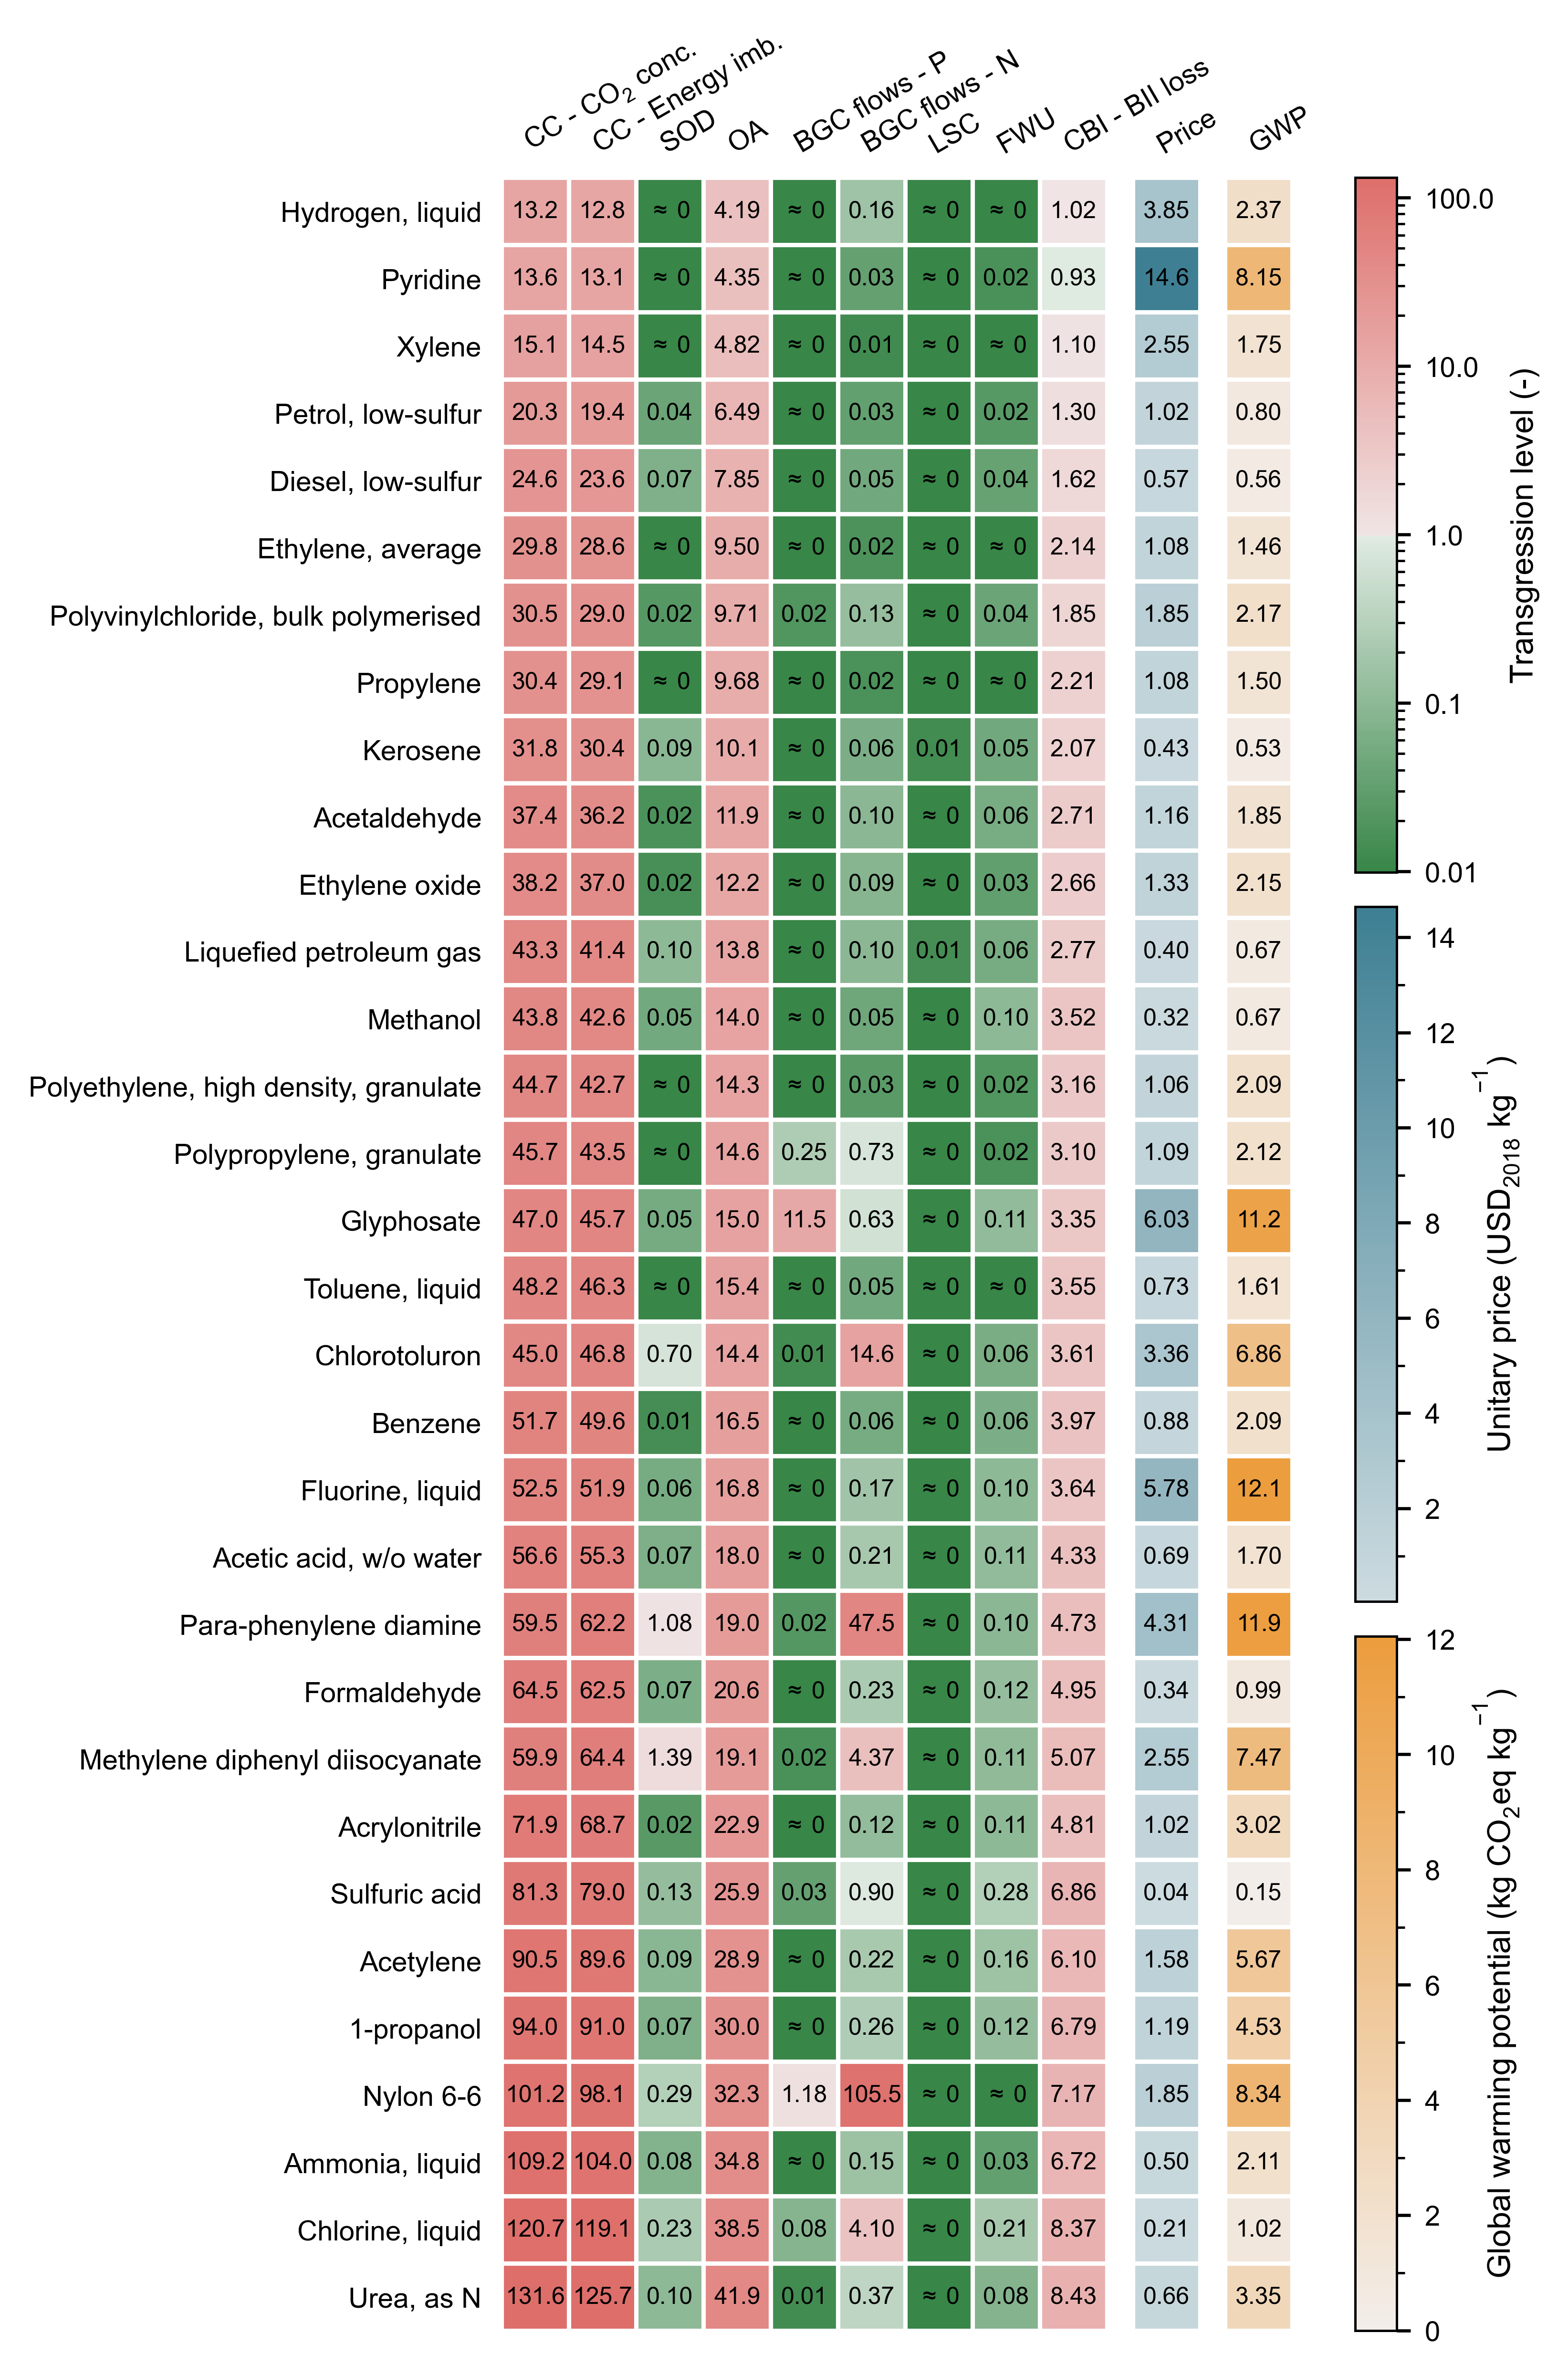

In [136]:
print("Used df: ", namedf)

# Plot

df_prices = df_plot.iloc[:,:1] # prices
df_GWP = df_plot.iloc[:, 3:4] # carbon footprint
df_TLonPBs = df_plot.iloc[:, 13:] # TL on PBs

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 43  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 16.5 - 4  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 15  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Figure specifications (fonts, sizes, figsize, etc.)
size_legend_font = 8
size_tick_font = 7
size_label_font = 8
mpl.rc("xtick", labelsize=size_tick_font)
mpl.rc("ytick", labelsize=size_tick_font)
mpl.rc("axes", labelsize=size_label_font, linewidth=0.6)
mpl.rc("font", family="Arial")
mpl.rc("mathtext", default="regular")

# Size of the figure
# fig_width = 150  # DEPENDS ON fig_height
fig_height = 220 - num_outliers_on_heatmap*6 # added the outliers manually

#### data for gridspec of the heatmap only, ADD MANUALLY !
numrows_hm = 1
numcols_hm = 3
ratio_of_widths_hm = [9, 1, 1]
w_space_hm = 0.1  # amount of space between subplots, fraction of the average axis width
# --------
numrows_fig = 1
numcols_fig = 2
ratio_of_widths_fig = [0.95, 0.05]
w_space_fig = 0.15

# ############## Specific calculations for this heatmap only:
# length of a cell (they are squares by default)
cell_length = (fig_height - from_top - from_bottom) / df_plot.index.size
cells_width = cell_length * np.asarray(ratio_of_widths_hm)
space_length = np.mean(cells_width) * w_space_hm
spacing = (numcols_hm - 1) * space_length
heatmap_width = sum(cells_width, spacing)
# ------------
fig_spacing = heatmap_width * 0.5 / ratio_of_widths_fig[0] * w_space_fig
cbar_width = heatmap_width * ratio_of_widths_fig[1] / ratio_of_widths_fig[0]

fig_width = np.ceil(from_left + from_right + heatmap_width + fig_spacing + cbar_width)
print(
    "Size of the figure:\nSpecified height is {} mm \nCalculated width is {} mm".format(
        fig_height, fig_width
    )
)
# ##########################################

size_in_mm = (fig_width, fig_height)  # input the desired size in mm (width, height)

fig = plt.figure(
    figsize=[x / 25.4 for x in size_in_mm],
    dpi=600,
    #  tight_layout = {'pad': 0}
)
# specs of the higher level grid
gs = fig.add_gridspec(
    nrows=numrows_fig,
    ncols=numcols_fig,
    width_ratios=ratio_of_widths_fig,
    wspace=w_space_fig,
    top=1 - from_top / size_in_mm[1],
    bottom=from_bottom / size_in_mm[1],
    left=from_left / size_in_mm[0],
    right=1 - from_right / size_in_mm[0],
)

# specs of the heatmap area grid
gs_heatmap = gs[0].subgridspec(
    nrows=numrows_hm,
    ncols=numcols_hm,
    width_ratios=ratio_of_widths_hm,
    wspace=w_space_hm,
)

# specs of the colorbar are grid
gs_cbar = gs[1].subgridspec(nrows=3, ncols=1, hspace=0.05)

ax1 = fig.add_subplot(gs_heatmap[0])
ax2 = fig.add_subplot(gs_heatmap[1], sharey=ax1,)
ax3 = fig.add_subplot(gs_heatmap[2], sharey=ax1,)
ax4 = fig.add_subplot(gs_cbar[0])
ax5 = fig.add_subplot(gs_cbar[1])
ax6 = fig.add_subplot(gs_cbar[2])


# --------------------------- LEFT and its COLORBAR ---------------------------
Z = df_TLonPBs.to_numpy()
Z[Z<=0.0099] = 0.0099


im1 = heatmap(
    df_TLonPBs.to_numpy(),
    df_TLonPBs.index.values,
    df_TLonPBs.columns.values,
    ax=ax1,
#     norm=TwoSlopeNorm(vcenter=1),
    norm=MidPointLogNorm(vmin=Z.min(), vmax=Z.max(), midpoint=1),
    cmap=cmap_center,
)

ax1.tick_params(axis="both", which="both", length=0.001, pad=5)
plt.setp(ax1.get_xticklabels(), rotation=30, ha="left", rotation_mode="anchor")

ax1.grid(which="minor", color="w", linestyle="-", linewidth=1.1)
annotate_heatmap(im=im1, color="k", fontsize=6)  # Annotate heatmap

# colorbar
cbarlabel = "\n".join(
    textwrap.wrap("Transgression level (-)", 60)
)
cbar1 = ax1.figure.colorbar(im1, cax=ax4, ax=None)
cbar1.ax.set_ylabel(cbarlabel, rotation=90, va="bottom")
cbar1.ax.yaxis.set_label_position("right")
# cbar1.ax.invert_yaxis()
cbar1.ax.minorticks_on()
cbar1.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar1.ax.yaxis.set_major_formatter(StrMethodFormatter("{x}")) # ScalarFormatter()) # StrMethodFormatter('{x:.0f}'))
cbar1.ax.yaxis.set_minor_formatter(NullFormatter())
# cbar1.ax.yaxis.set_minor_locator(MultipleLocator(5))


# --------------------------- CENTER and its COLORBAR ---------------------------
im2 = heatmap(
    df_prices.to_numpy(),
    df_prices.index.values,
    df_prices.columns.values,
    ax=ax2,
    cmap=cmap_right,
)

ax2.tick_params(axis="both", which="both", length=0.001, pad=5)
plt.setp(ax2.get_xticklabels(), rotation=30, ha="left", rotation_mode="anchor")

ax2.grid(which="minor", color="w", linestyle="-", linewidth=1.1)
annotate_heatmap(im=im2, color="k", fontsize=6)  # Annotate heatmap

# colorbar
cbarlabel = "\n".join(
    textwrap.wrap(r"Unitary price ($USD_{2018}$ $kg^{-1}$)", 40)
)
cbar2 = ax2.figure.colorbar(im2, cax=ax5, ax=None)
cbar2.ax.set_ylabel(cbarlabel, rotation=90, va="bottom")
cbar2.ax.yaxis.set_label_position("right")
# cbar2.ax.invert_yaxis()
cbar2.ax.minorticks_on()
cbar2.ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.setp(ax2.get_yticklabels(), visible=False)  # remove yticklabels

# --------------------------- RIGHT and its COLORBAR ---------------------------
im3 = heatmap(
    df_GWP.to_numpy(),
    df_GWP.index.values,
    df_GWP.columns.values,
    ax=ax3,
    norm=TwoSlopeNorm(vcenter=0),
    cmap=cmap_left,
)

ax3.tick_params(axis="both", which="both", length=0.001, pad=5)
plt.setp(ax3.get_xticklabels(), rotation=30, ha="left", rotation_mode="anchor")

ax3.grid(which="minor", color="w", linestyle="-", linewidth=1.1)
annotate_heatmap(im=im3, color="k", fontsize=6)  # Annotate heatmap

# colorbar
cbarlabel = "\n".join(textwrap.wrap(r"Global warming potential (kg $CO_{2}$eq $kg^{-1}$)", 70))
cbar3 = ax3.figure.colorbar(im3, cax=ax6, ax=None)
cbar3.ax.set_ylabel(cbarlabel, rotation=90, va="bottom")
cbar3.ax.yaxis.set_label_position("right")
# cbar1.ax.invert_yaxis()
cbar3.ax.minorticks_on()
cbar3.ax.yaxis.set_minor_locator(MultipleLocator(1))
# cbar3.ax.yaxis.set_major_locator(MultipleLocator(5))

plt.setp(ax3.get_yticklabels(), visible=False)  # remove yticklabels

## EXPORT FIGURE
# figNamePNG = "Fig4_{}.png".format(namedf) # "Fig4_sortedCCEngImb.png"
# figNameSVG = "Fig4_{}.svg".format(namedf) #"Fig4_sortedCCEngImb.svg"

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg
plt.show()

#### additional steps

In [287]:
# df_plot.iloc[:, 14:15]

In [137]:
df2.loc[89]

NameError: name 'df2' is not defined

In [138]:
df_base_CPC33to35[df_base_CPC33to35.referenceProduct == 
#                   "Nylon 6-6" # no match
#                   "Adipic acid" # outlier?
                  "Ammonium nitrate, as N" # outlier?
                 ]

NameError: name 'df_base_CPC33to35' is not defined

In [139]:
maxval = df_plot.iloc[:, 14:15].max()[0]
minval = df_plot.iloc[:, 14:15].min()[0]
print("max: ", maxval)
print("min: ", minval)
df_plot[
    df_plot["TL in Climate change - Energy imbalance"].isin([maxval, minval])
]

max:  125.73596422932062
min:  12.794606401568299


KeyError: 'TL in Climate change - Energy imbalance'

In [366]:
# df_to_detect_outl.iloc[:, 40:41]

In [367]:
maxval = df_to_detect_outl.iloc[:, 40:41].max()[0]
minval = df_to_detect_outl.iloc[:, 40:41].min()[0]
df_to_detect_outl[
    df_to_detect_outl[
        "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"
    ].isin([maxval, minval])
]

Activity  category_regrouped  \
884      Trimesoyl chloride {GLO}| market for | APOS, S  Inorganic chemical   
1128  Sulfur hexafluoride, liquid, combined to GLO m...  Inorganic chemical   

                                       activity_comment      type  \
884   Production volume: 4 kgIncluded activities ...  Products   
1128                                               None  Products   

                 referenceProduct                  category  \
884            Trimesoyl chloride  Chemicals\Organic\Market   
1128  Sulfur hexafluoride, liquid    Chemicals\Gases\Market   

                     inline_comment  geo                   activity_ISICclass  \
884   Production Volume Amount: 4  GLO  2011:Manufacture of basic chemicals   
1128                           None  GLO  2011:Manufacture of basic chemicals   

     activity_ecoSpold01class  technologyLevel  referenceProductAmount  \
884        chemicals/organics              0.0                       1   
1128                      NaN              NaN                       1   

     referenceProductUnit  referenceProduct_prodVolume  \
884                    kg                          4.0   
1128                   kg                          4.0   

     referenceProduct_prodVolumeComment  referenceProduct_price  \
884                                 NaN                  990.00   
1128                               None                    3.39   

     referenceProduct_priceUnit  \
884                     EUR2005   
1128                    EUR2005   

                          referenceProduct_priceComment  \
884   Estimated based on purchaser prices available ...   
1128                                               None   

     referenceProduct_casNumber              referenceProduct_CPCclass  \
884                   4422-95-1  342: Basic inorganic chemicals n.e.c.   
1128                002551-62-4  342: Basic inorganic chemicals n.e.c.   

                                activity_generalComment  \
884                                                 NaN   
1128  Combined activity, mass allocated from RER, Ro...   

                                         sourceFilename pubchem_match  \
884   23442_5a2c7eef-c5cb-4f96-b3ca-95abd11a17b2_4c4...        by CAS   
1128                                               None       by NAME   

      num_matches         MF      MW                               iupac  \
884             1  C9H3Cl3O3  265.50  benzene-1,3,5-tricarbonyl chloride   
1128            1        F6S  146.06          hexafluoro-lambda6-sulfane   

      complexity                                           synonyms  \
884        243.0  ['Trimesoyl chloride', '4422-95-1', '1,3,5-Ben...   
1128        62.7  ['SULFUR HEXAFLUORIDE', 'Sulphur hexafluoride'...   

      ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
884                                            8.283052            
1128                                         127.060714            

      ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
884                                        1.729510e-10                            
1128                                       2.349601e-10                            

      ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
884                                        2.447114e-12                            
1128                                       3.387234e-10                            

      ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
884                                        6.543358e-13                      
1128                                       5.101999e-14                      

      ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
884                                        5.284927e-13                      
1128                                       7.179779e-13                      

      ('PBs-LCIA (baseline) V0.72', 'B

### fig ESI
<div class="alert alert-block alert-info">
  Bivariate analysis: Price of chemicals vs categories of PBs method <br>
    - scatter plots  <br>
</div>

In [85]:
# lst_methods_fig3 = lst_methods[1:]+[lst_methods[0]]
# lst_methods_fig3

In [140]:
df_base_full_wCAS_woOutliersRMDk9a5[
    df_base_full_wCAS_woOutliersRMDk9a5.referenceProduct_price > 900
]  # .referenceProduct_price

Activity  category_regrouped  \
317              Indium {GLO}| market for | APOS, S  Inorganic chemical   
684  Trimesoyl chloride {GLO}| market for | APOS, S  Inorganic chemical   

                                      activity_comment      type  \
317  Production volume: 492500 kgIncluded activi...  Products   
684  Production volume: 4 kgIncluded activities ...  Products   

       referenceProduct                  category  \
317              Indium   Metals\Non ferro\Market   
684  Trimesoyl chloride  Chemicals\Organic\Market   

                         inline_comment  geo  \
317  Production Volume Amount: 492500  GLO   
684       Production Volume Amount: 4  GLO   

                      activity_ISICclass activity_ecoSpold01class  \
317  2011:Manufacture of basic chemicals        metals/extraction   
684  2011:Manufacture of basic chemicals       chemicals/organics   

     technologyLevel  referenceProductAmount referenceProductUnit  \
317              0.0                       1                   kg   
684              0.0                       1                   kg   

     referenceProduct_prodVolume referenceProduct_prodVolumeComment  \
317                     492500.0                                NaN   
684                          4.0                                NaN   

     referenceProduct_price referenceProduct_priceUnit  \
317             1227.073631                    USD2018   
684             1420.822099                    USD2018   

                         referenceProduct_priceComment  \
317  Calculated based on inputs: The price of the p...   
684  Estimated based on purchaser prices available ...   

    referenceProduct_casNumber  \
317                007440-74-6   
684                  4422-95-1   

                             referenceProduct_CPCclass  \
317  34231: Chemical elements n.e.c.; inorganic aci...   
684              342: Basic inorganic chemicals n.e.c.   

    activity_generalComment  \
317                     NaN   
684                     NaN   

                                        sourceFilename pubchem_match  \
317  22063_ac8780ab-bb0d-49db-8cd6-c11aa132c365_5f5...       by NAME   
684  23442_5a2c7eef-c5cb-4f96-b3ca-95abd11a17b2_4c4...        by CAS   

     num_matches         MF      MW                               iupac  \
317            1         In  114.82                              indium   
684            1  C9H3Cl3O3  265.50  benzene-1,3,5-tricarbonyl chloride   

     complexity                                           synonyms  \
317         0.0  ['7440-74-6', 'In', 'Indium', 'Indium, element...   
684       243.0  ['Trimesoyl chloride', '4422-95-1', '1,3,5-Ben...   

     ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
317                                         215.666280            
684                                           8.283052            

     ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
317                                       5.238128e-09                            
684                                       1.729510e-10                            

     ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
317                                       7.193715e-11                            
684                                       2.447114e-12                            

     ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
317                                       1.630583e-12                      
684                                       6.543358e-13                      

     ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
317                                       1.600640e-11                      
684                                       5.284927e-13                      

     ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')  \
317                                       3.522170e-14       

In [141]:
dict_labels_PBs = dict_pbs.copy()
dict_labels_PBs[lst_methods[0]] = ['GWP', 'kg $CO_{2}eq\ kg^{-1}$']
# dict_labels_PBs

In [142]:
dict_labels_TLs = dict_pbs_plot.copy()
dict_labels_TLs[lst_methods[0]] = ['GWP', 'kg $CO_{2}eq\ kg^{-1}$']
# dict_labels_TLs

Used df:  df_base_full_wCAS_woOutliersRMDk9a5


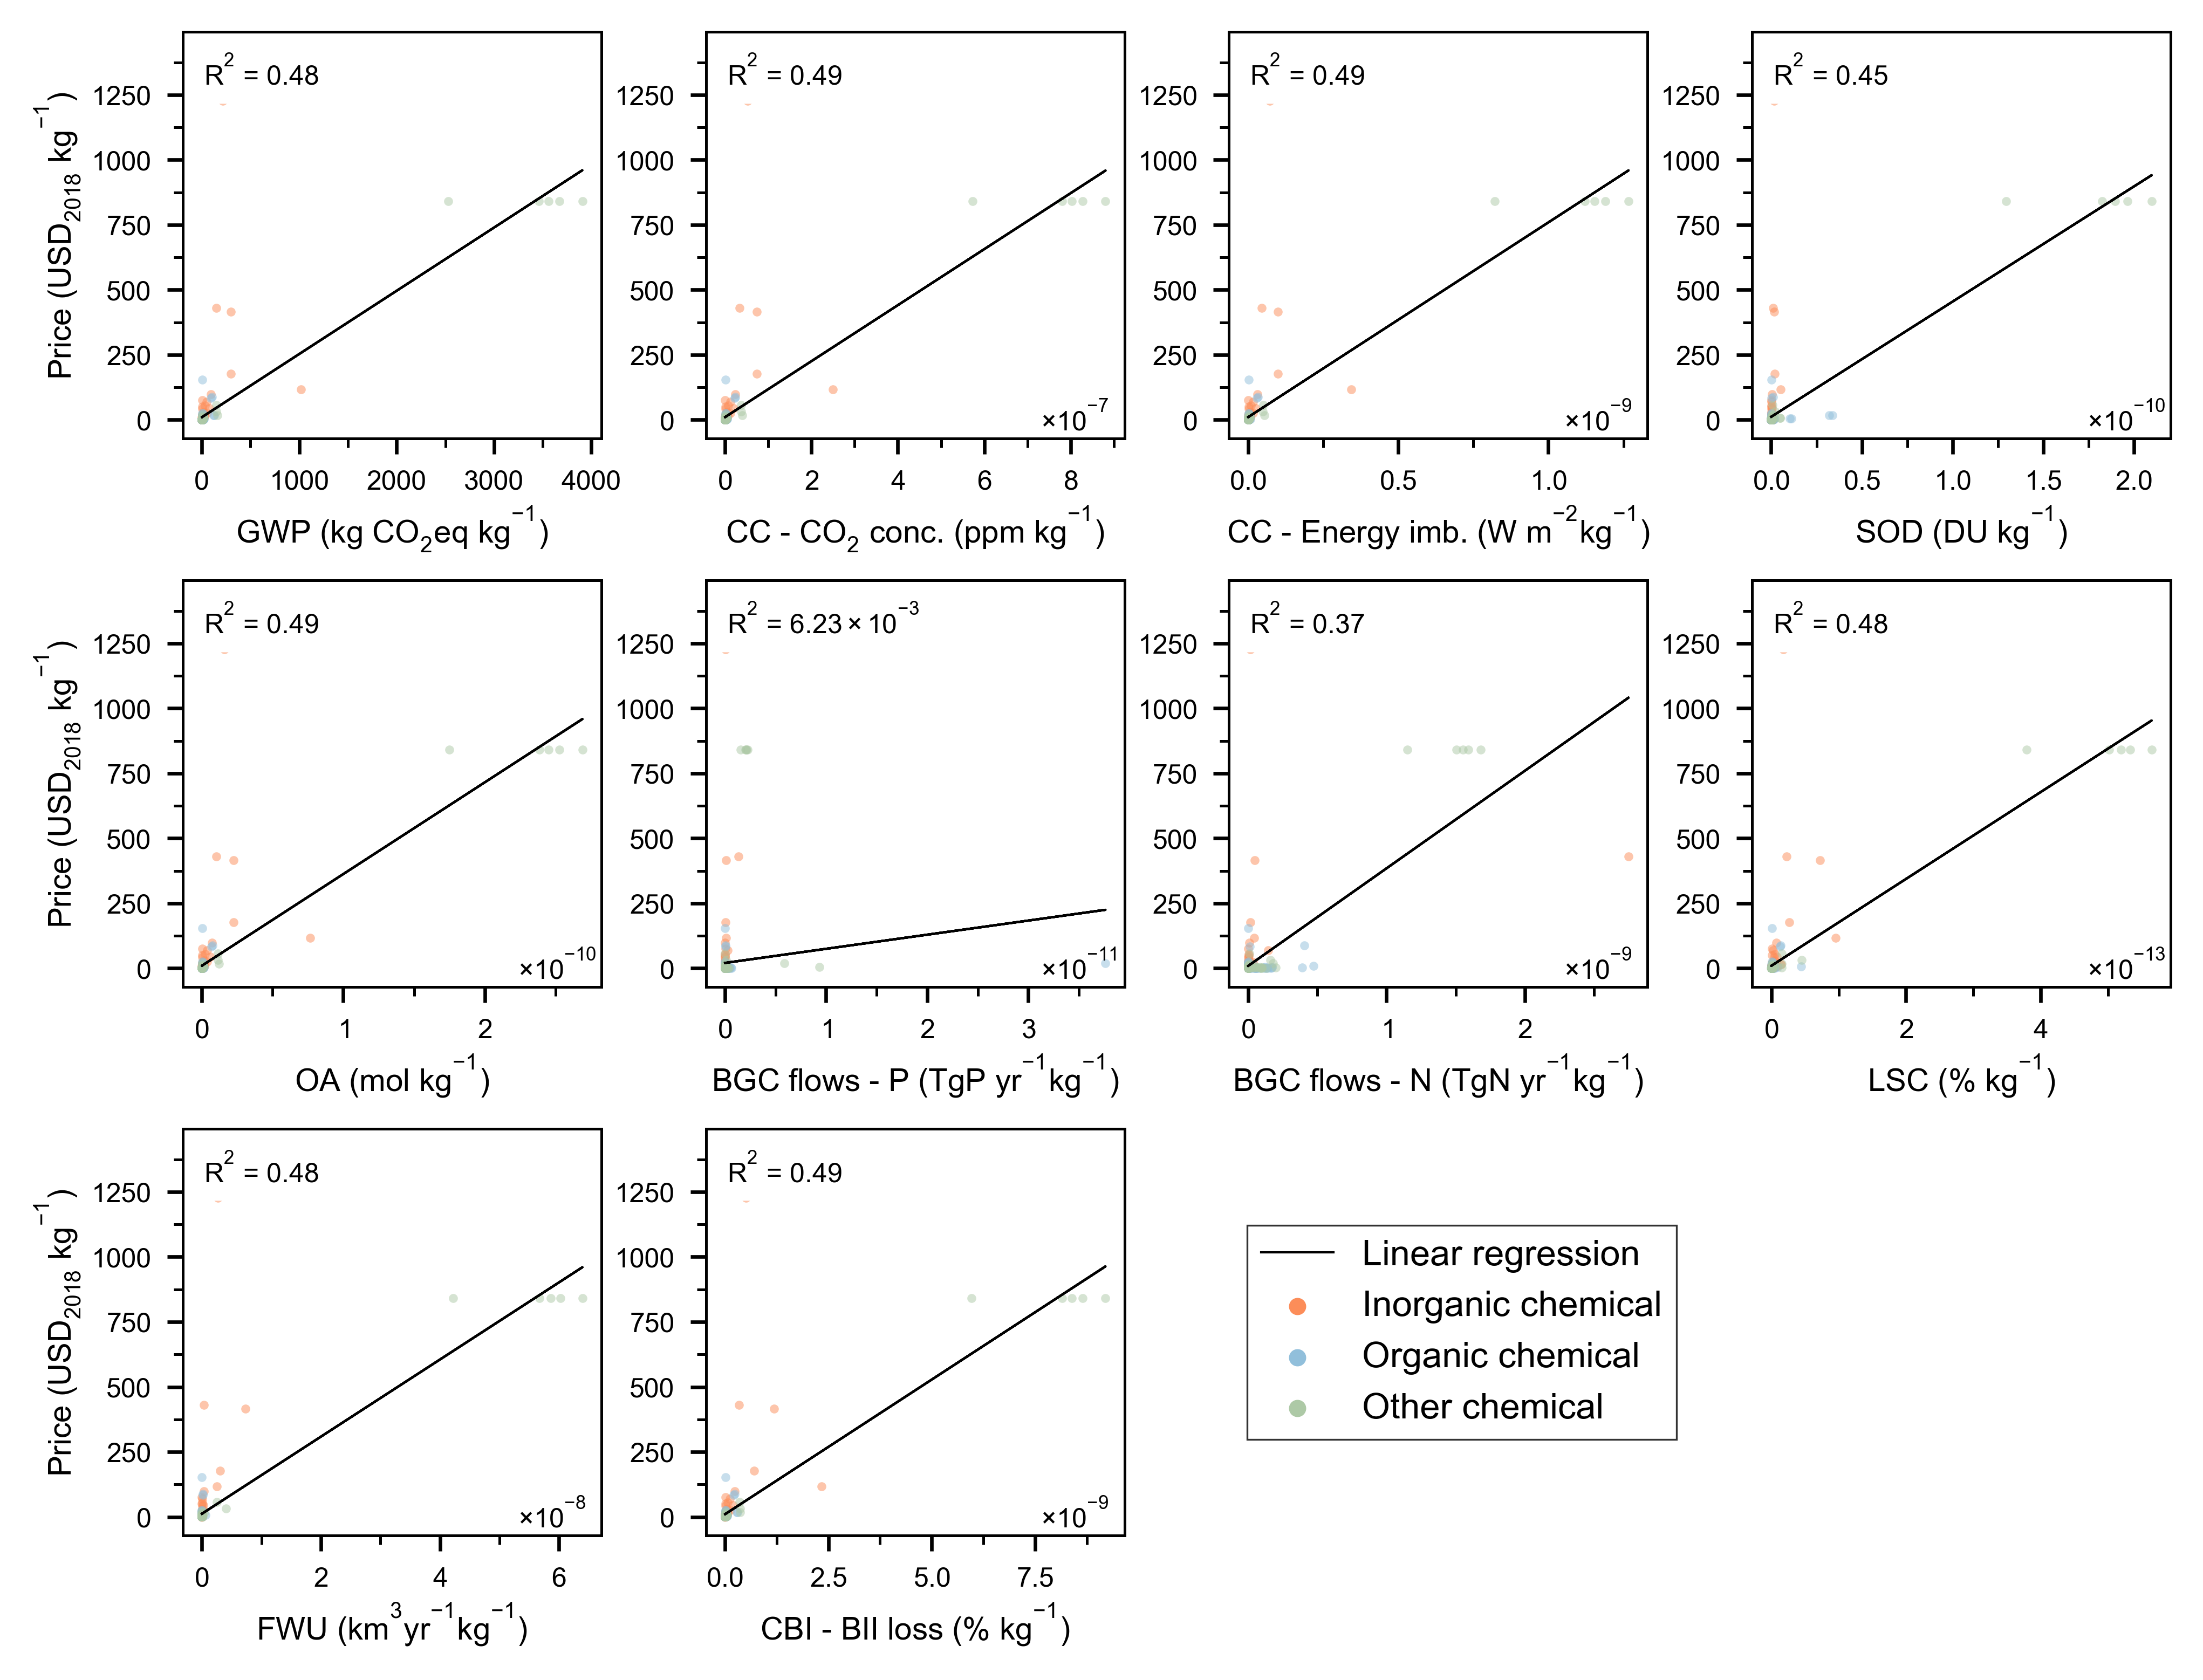

In [143]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS"
# loop_methods = lst_methods_TLs
# dict_labels = dict_labels_TLs
loop_methods = lst_methods
dict_labels = dict_labels_PBs

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

######################
print("Used df: ", namedf)
size_legend_font = 8

fig_width, fig_height = 171, 130
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 13  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 10  # in mm
from_top = 2  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:0)
gs = fig.add_gridspec(
    nrows=3,
    ncols=4,
    width_ratios=[1, 1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.25,
    hspace=0.35,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)

for gsx, cat in enumerate(loop_methods):

    x_raw = df_toplot[cat]
    y_raw = df_toplot.referenceProduct_price
    
    # Remove Nan values
    x_raw = x_raw.astype(np.float64)
    y_raw = y_raw.astype(np.float64)
    mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
    x = x_raw[mask]
    y = y_raw[mask]
    
    # Linear regression
    (X, Y_pred), Rsquare, _ = linear_regr(x, y)

    # Subplots ....
    ax = fig.add_subplot(gs[gsx])

    grouped = dict(list(df_toplot.groupby("category_regrouped")))
    tot_keys = len(grouped)
    for i, (key, group) in enumerate(grouped.items()):
        
        x_group_raw = group[cat]
        y_group_raw = group.referenceProduct_price
        
        # Remove Nan values
        x_group_raw = x_group_raw.astype(np.float64)
        y_group_raw = y_group_raw.astype(np.float64)
        mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
        x_group = x_group_raw[mask_group]
        y_group = y_group_raw[mask_group]
        
        # ---------- scatter plot ---------------
        ax.scatter(
            x=x_group,
            y=y_group,
            c=plot_colors[key],
            #             label=key,
            alpha=0.5,
            s=4,
            linewidths=0,
        )
        ax.set_ylabel(ylabel="Price ($USD_{2018}\ kg^{-1}$)", labelpad=2)

        xlabelname = "\n".join(
            textwrap.wrap(dict_labels[cat][0] + " (" + dict_labels[cat][1] + ")", 50)
        )
        ax.set_xlabel(xlabel=xlabelname, labelpad=2)

#         xlim_ax = ax.get_xlim()
#         ylim_ax = ax.get_ylim()

        if gsx in [1, 2, 3, 5, 6, 7, 9]:
            #             ax.set_yticks([])
            ax.set_ylabel(None)
        #         ax.get_yaxis().set_visible(False)
        #     ax.grid(True)
            
        # ~~~~~~~~~~~~  ~~~~~~~~~~~~
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#         else:
#             ax.xaxis.set_major_locator(MultipleLocator(2))
#             ax.xaxis.set_minor_locator(AutoMinorLocator(4))
#         ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))      

        # ---------- regression line ---------------
        ax.plot(
            X, Y_pred, color="black", lw=0.5,
        )  # label="Linear regression")
        ax.text(
            0.05,
            0.9,
            Rsquare,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            backgroundcolor="white",
            fontsize=6,
        )

    if max(ax.get_xticks()) < 1:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        min_exp = -1
        max_exp = 1
        formatter.set_powerlimits((min_exp, max_exp))
        ax.xaxis.set_major_formatter(formatter)
        # ~~~~ move the formatter inside the axes box
        ## from https://stackoverflow.com/a/59018067/14485040
        ax.get_xaxis().get_offset_text().set_visible(
            False
        )  # .set_position((1.1,0)) # only moves on its x-axis
        ax_max = max(ax.get_xticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        if exponent_axis <= min_exp or exponent_axis >= max_exp:
            ax.annotate(
                r"$\times$10$^{%i}$" % (exponent_axis),
                xy=(0.8, 0.02),
                xycoords="axes fraction",
                fontsize=6,
            )
        
# Legend
gs_legend = fig.add_subplot(gs[2, 2:])
gs_legend.axis("off")

for key, group in grouped.items():
    ax.scatter([], [], color=plot_colors[key], label=key, marker="o", s=8)
ax.plot([], [], color="black", lw=0.5, label="Linear regression")
handles, labels = ax.get_legend_handles_labels()

leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="center left",
    bbox_to_anchor=(0.0, 0.5),
    ncol=1,
    fontsize=size_legend_font,
    fancybox=False,
    #     labelspacing=0.5,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

## EXPORT FIGURE
# figNamePNG = "ESI-Fig-prices_{}.png".format(namedf)
# figNameSVG = "ESI-Fig-prices_{}.svg".format(namedf)

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

### fig (sustainable chemicals!)

In [109]:
# dict_pbs

In [124]:
TLs_base = calculate_TL_PBs(
    df_base, method_labels=list(dict_pbs.keys()), correctGVA="purchases"
)
# TLs_base

df_TLs_base = pd.concat(
    [
        df_base.loc[TLs_base.index][lst_metadata],
        df_base["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"],
        TLs_base,
    ],
    axis=1,
)
df_TLs_base.sample(2)

Activity   category_regrouped  \
154   Cadmium telluride, semiconductor-grade {GLO}| ...  34: Basic chemicals   
1085  Pitch despergents, in paper production, combin...  34: Basic chemicals   

                                       activity_comment      type  \
154   Production volume: 10094.5772307692 kgInclu...  Products   
1085                                               None  Products   

                            referenceProduct                    category  \
154   Cadmium telluride, semiconductor-grade  Chemicals\Inorganic\Market   
1085  Pitch despergents, in paper production     Chemicals\Others\Market   

                                    inline_comment  geo  \
154   Production Volume Amount: 10094.5772307692  GLO   
1085                                          None  GLO   

                       activity_ISICclass activity_ecoSpold01class  \
154   2011:Manufacture of basic chemicals        metals/extraction   
1085  2011:Manufacture of basic chemicals                      NaN   

      technologyLevel  referenceProductAmount referenceProductUnit  \
154               0.0                       1                   kg   
1085              NaN                       1                   kg   

      referenceProduct_prodVolume referenceProduct_prodVolumeComment  \
154                  10094.577231                                NaN   
1085                     4.000000                               None   

      referenceProduct_price referenceProduct_priceUnit  \
154                    14.60                    EUR2005   
1085                    0.86                    EUR2005   

                          referenceProduct_priceComment  \
154   Calculated based on inputs: The price of the p...   
1085                                               None   

     referenceProduct_casNumber              referenceProduct_CPCclass  \
154                   1306-25-8  342: Basic inorganic chemicals n.e.c.   
1085                        NaN                    34: Basic chemicals   

                                activity_generalComment  \
154                                                 NaN   
1085  Combined activity, mass allocated from RER, Ro...   

                                         sourceFilename pubchem_match  \
154   20843_e18cd1f7-73a7-45b6-a439-d4808b39ec60_7ef...        by CAS   
1085                                               None      No match   

      num_matches    MF     MW                 iupac  complexity  \
154             1  CdTe  240.0  tellanylidenecadmium         2.0   
1085            0   NaN    NaN                   NaN         NaN   

                                               synonyms  \
154   ['Cadmium telluride', '1306-25-8', 'Cadmium te...   
1085                                                NaN   

      ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
154                                           16.171057            
1085                                           1.225988            

      ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
154                                            7.019480                            
1085                                           9.024679                            

      ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
154                                            6.938388                            
1085                                           8.626686                            

      ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
154                                            0.011108                      
1085                                           0.002578                      

      ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
154                                            2.238233                      
1085                                           2.877618                      

      ('PBs

In [111]:
# df_TLs_base.columns

(-1.0, 2.0)

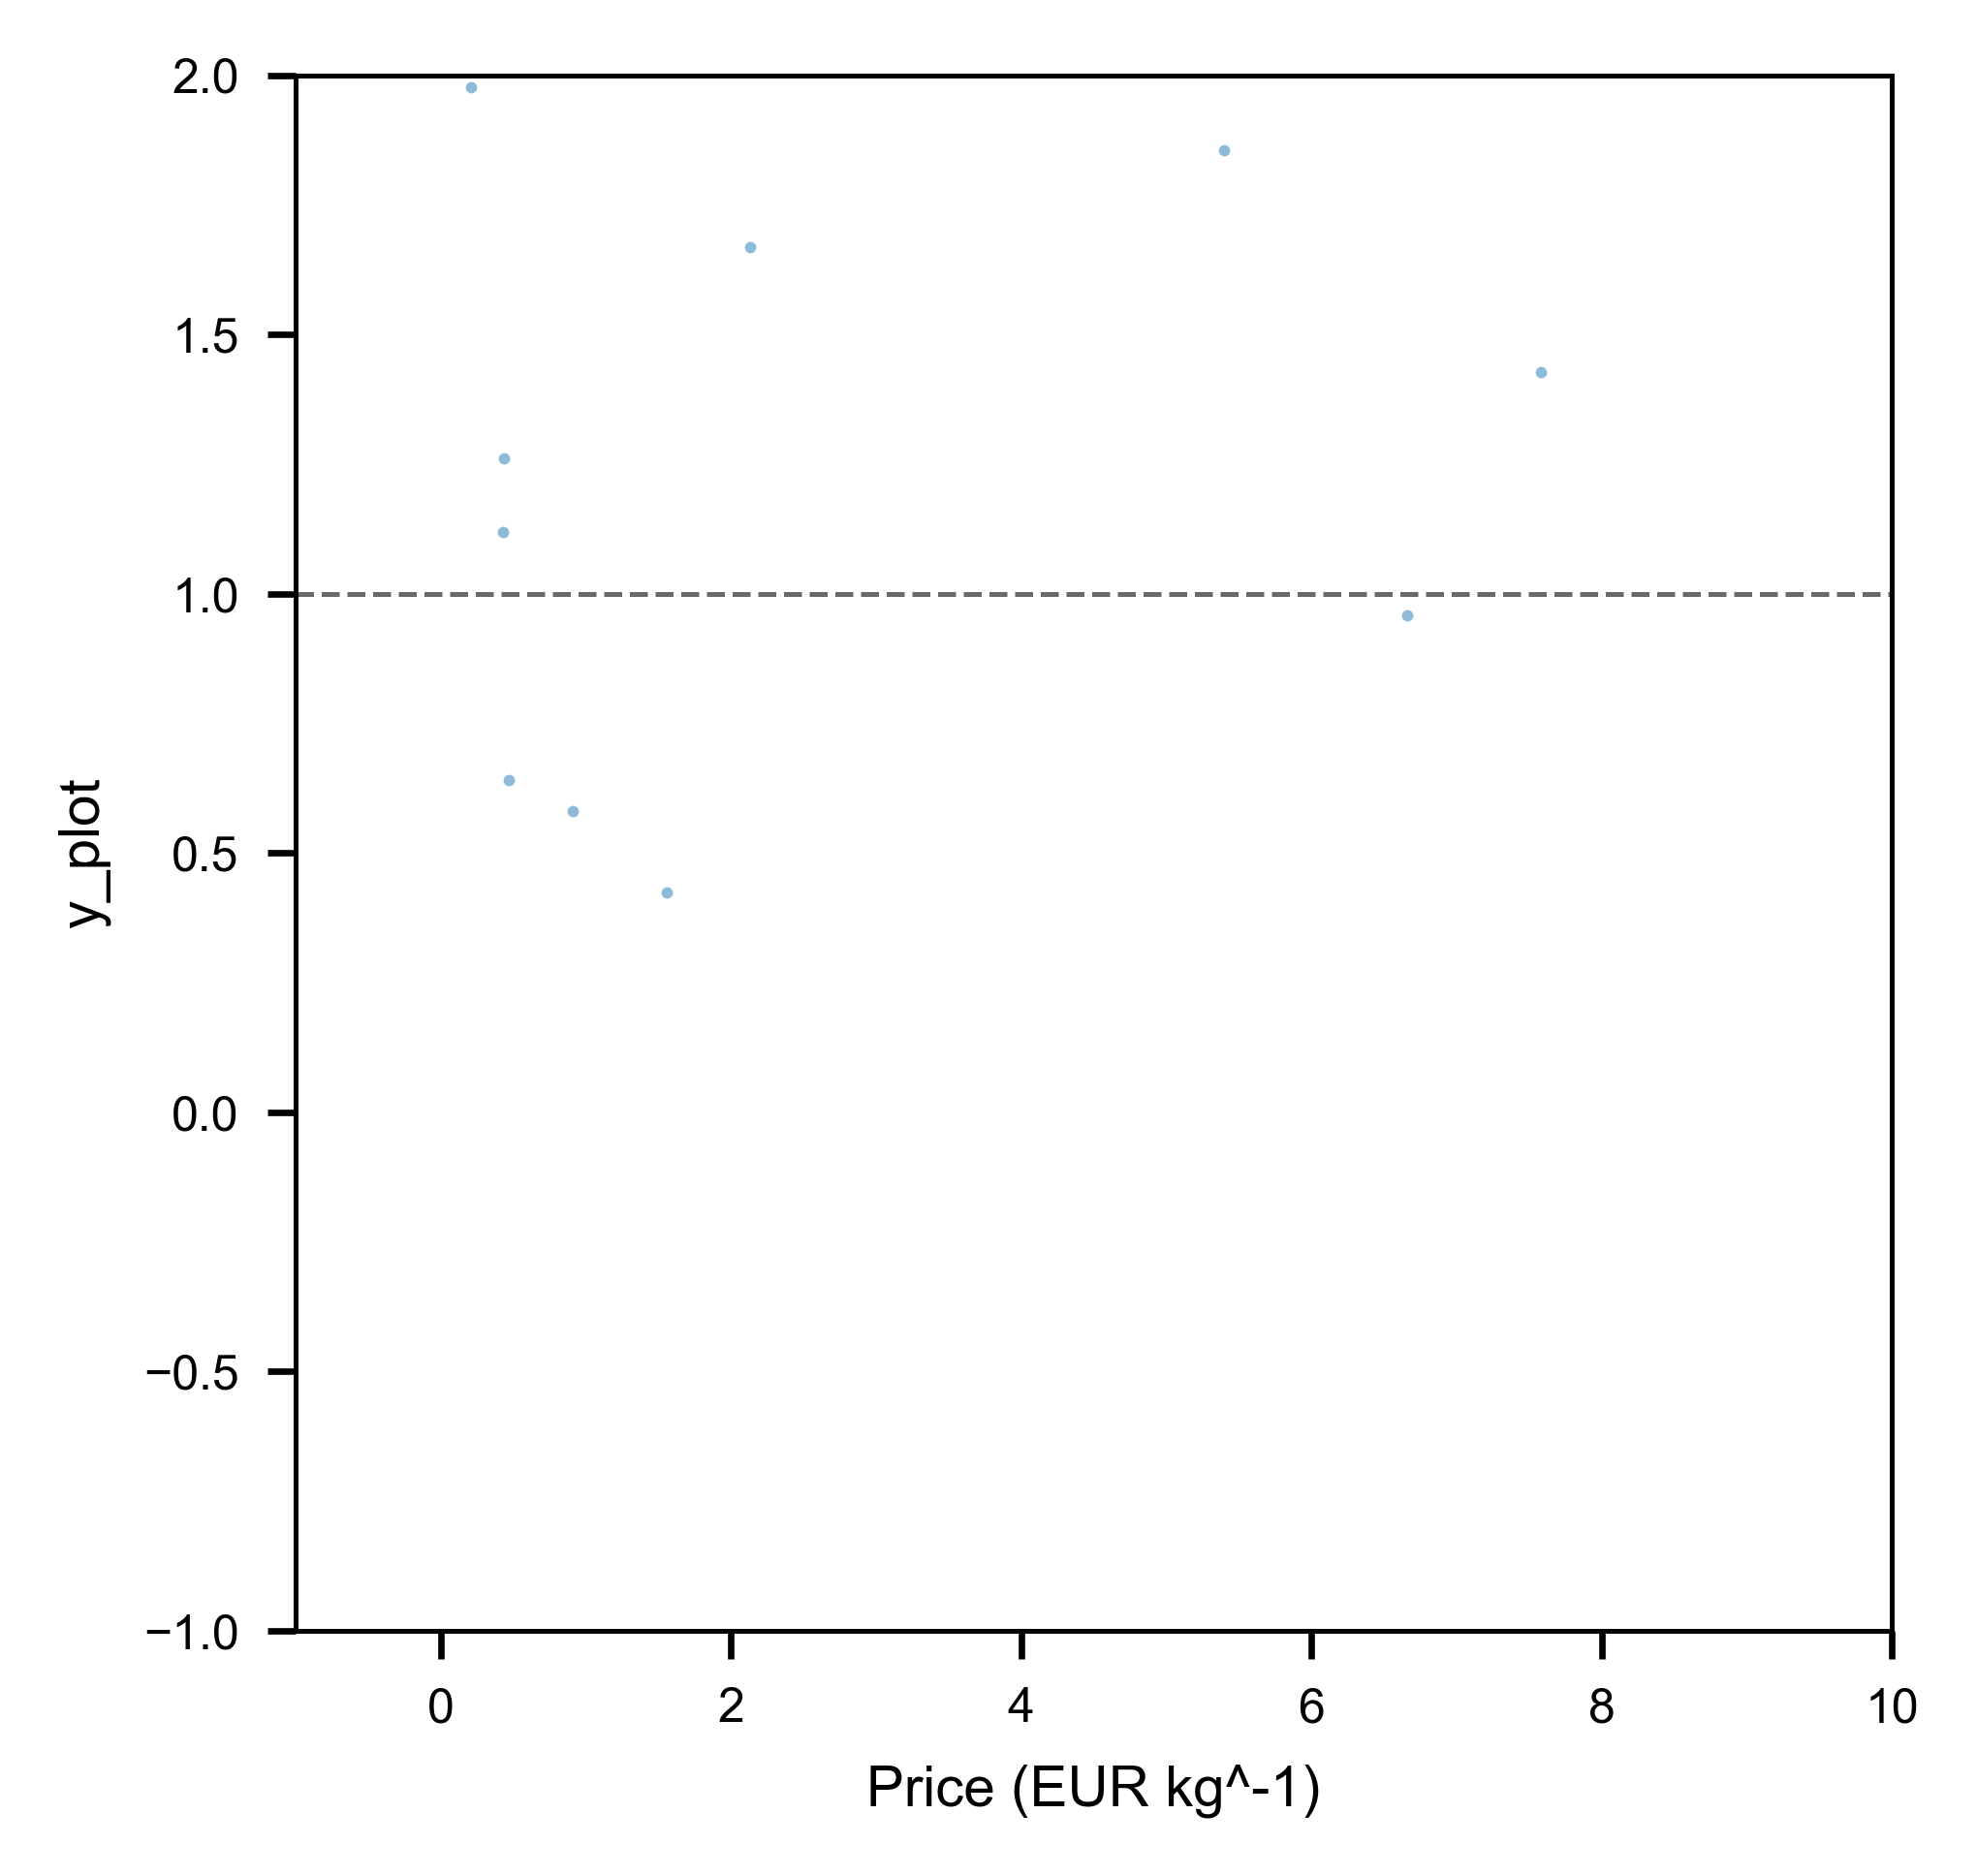

In [125]:
x_plot = df_TLs_base.referenceProduct_price
# y_plot = df_TLs_base["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"]
y_plot = df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')"]
# y_plot = df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')"]


fig = create_fig((90,90))

ax = fig.subplots()
ax.scatter(x=x_plot,y=y_plot, s=2, alpha=0.5, lw=0)
ax.set_xlabel("Price (EUR kg^-1)")
ax.set_ylabel("y_plot")
ax.axhline(1, color="dimgray", linestyle="--", linewidth=0.6,)
ax.set_xlim(left=-1, right=10)
ax.set_ylim(bottom=-1, top=2)

In [95]:
# cat = "('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')"
# df_TLs_base[(df_TLs_base.amount_price < 10) & (df_TLs_base[cat] < 1)]

In [126]:
# Find chemicals with absolute sustainability

c0 = df_TLs_base.referenceProduct_price < 10
c1 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')"]<= 1)
c2 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"]<= 1)
c3 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')"]<= 1)
c4 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')"]<= 1)
c5 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')"] <= 1)
c6 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')"] <= 1)
c7 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')"] <= 1)
c8 = df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')"] <= 1
c9 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"]<= 1 )

df_TLs_base[conjunction(
#     c0, 
    c1, 
    c2, 
    c3, 
    c4, 
    c5, 
    c6, 
    c7, 
    c8, 
    c9
)]

NameError: name 'conjunction' is not defined

### fig ESI (heatmaps correlations)

In [144]:
def calc_Pearson_Spearman_Plot (df_data, methods_1, methods_2,
                                annotations=True, 
#                                 pairplot=False, 
#                                 pp_xvars=data.columns.values.tolist(), 
#                                 pp_yvars=data.columns.values.tolist(),
                               ):
    """Calculate Pearson product moment correlation and Spearman rank-order correlation,
        Plot the correlations on a heatmap and optionally, plot a pairplot of the data
        
        Pearson coefficient: measure of linear correlation between two sets of data
                            https://www.wikiwand.com/en/Pearson_correlation_coefficient
        Spearman coefficient: a nonparametric measure of rank correlation 
                            (statistical dependence between the rankings of two variables). 
                            It assesses how well the relationship between two variables 
                            can be described using a monotonic function.    
                            https://www.wikiwand.com/en/Spearman%27s_rank_correlation_coefficient
        
        
        """
    
    size_in_mm = (150,150) # size of the plots
    
    col_label_name_1 = methods_1
    col_label_name_2 = methods_2
    
    data_1 = df_data[col_label_name_1]
    data_2 = df_data[col_label_name_2]
    data = pd.concat([data_1, data_2], axis=1)
    
#     data_1 = df_data[method_1][np.array(categories_1)]
#     data_2 = df_data[method_2][np.array(categories_2)]
#     data = pd.concat([data_1, data_2], axis=1)
    
    fig = create_fig((200, 200), 150)
    ax1 = fig.subplots(1,1)
#     if pairplot == True:
#         sns.pairplot(data, 
#                      x_vars=pp_xvars,
#                      y_vars=pp_yvars,
# #                      corner=True # triangulize
#                     );
#         pairplot_of_data = sns.pairplot(data);
#     else:
#         pairplot_of_data = 'Pairplot not plotted.'
    # ---------------------------------------
    
    # Pearson correlation:
    pearson_corr = data.corr(method='pearson')
    
    # Spearman correlation:
    spearman_corr = data.corr(method='spearman')
    
    # Plot the whole heatmap:
#     fig, axes = plt.subplots(nrows=1, ncols=1, 
#                            figsize=[x/25.4 for x in size_in_mm],
#                            dpi=75, sharey=False,
#                             )
#     axes = sns.heatmap(pearson_corr,
#                        annot=annotations,
#                        linewidths=0.05,
#                        center=1,
#                        cmap='YlGnBu'
#                       )

    # Triangulize the heatmap, show anly lower part:
    mask1 = np.zeros_like(pearson_corr)
    mask1[np.triu_indices_from(mask1)] = True
    with sns.axes_style("white"):
#         fig, axes = plt.subplots(nrows=1, ncols=1,
#                                  figsize=[x/25.4 for x in size_in_mm],
#                                  dpi=75, sharey=False,
#                                 )
#         axes1 = 
        axes = sns.heatmap(pearson_corr,
                           mask=mask1,
                           square=True, 
                           annot=annotations,
                           annot_kws={"size":6}, 
                           linewidths=0.05, 
                           center=1,
                           cmap='YlGnBu',
#                             ax=ax1
                          )
#     axes1.set_title('Pearson correlation', fontsize=15)       
    # ---------------------------------------

    
    # Plot the whole heatmap:    
#     fig, axes = plt.subplots(nrows=1, ncols=1, 
#                              figsize=[x/25.4 for x in size_in_mm],
#                              dpi=75, sharey=False,
#                             )
#     axes = sns.heatmap(spearman_corr,
#                        annot=annotations,
#                        linewidths=0.05,
#                        center=1,
#                        cmap='YlOrRd'
#                       )

    # Triangulize the heatmap, show anly UPPER part:
    mask2 = np.zeros_like(spearman_corr)
    mask2[np.tril_indices_from(mask2)] = True
    with sns.axes_style("white"):
#         fig, axes = plt.subplots(nrows=1, ncols=2,
#                                  figsize=[x/25.4 for x in size_in_mm],
#                                  dpi=75, sharey=False,
#                                 )
#         axes2 = 
        axes = sns.heatmap(spearman_corr,
                           mask=mask2,
                           square=True, 
                           annot=annotations, 
                           annot_kws={"size":6}, 
                           linewidths=0.05, 
                           center=1,
                           cmap='YlOrRd',
#                             ax=ax1
                          )
#     axes2.set_title('Spearman correlation', fontsize=15)
    axes.set_title('Correlations: LTM - Pearson/ UTM - Spearman', fontsize=9)
    
#     return pairplot_of_data

In [98]:
# df_clean.columns

In [262]:
# df_base_full_wCAS_woOutliers[lst_methods[0:1] + lst_methods_TLs].corr(method='pearson')

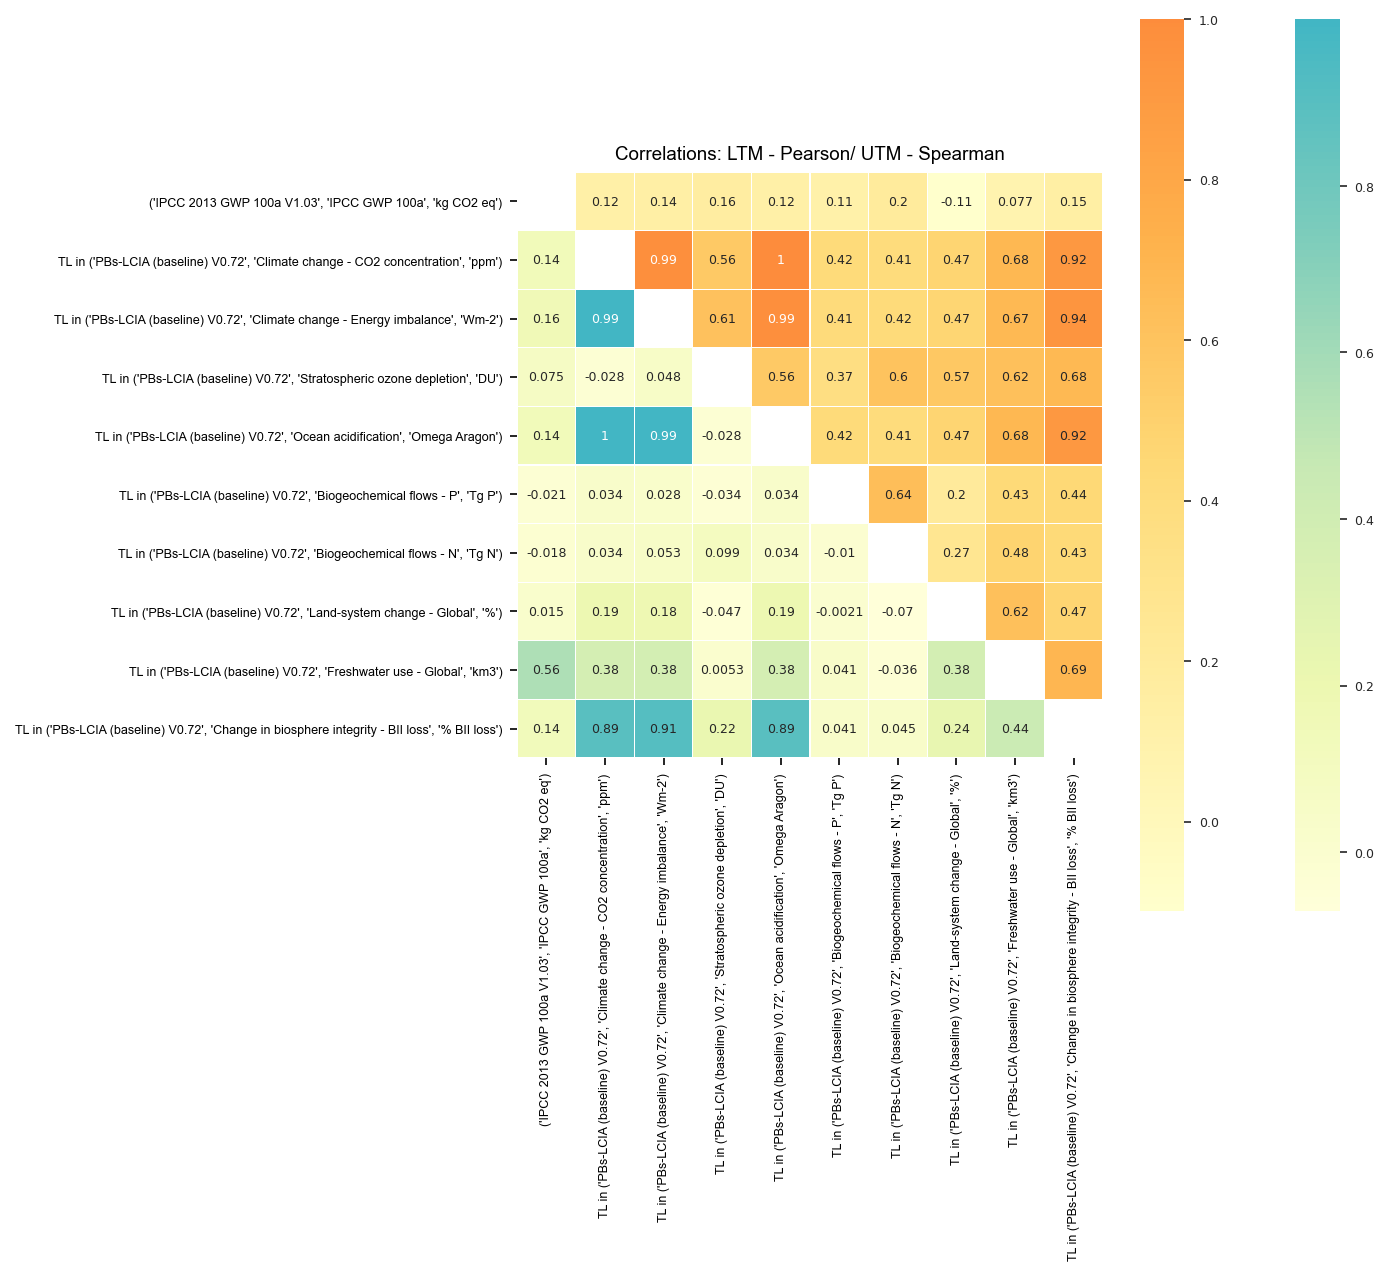

In [145]:
# calc_Pearson_Spearman_Plot(df_clean, lst_methods, [], annotations=False)
# calc_Pearson_Spearman_Plot(df_clean, lst_methods, ["complexity"])
calc_Pearson_Spearman_Plot(
    df_base_full_wCAS_woOutliersRMDk9a5,
#     df_base_full_wCAS_woOutliersMDk20a5,
    lst_methods[0:1], 
#     lst_methods[1:] ,
    lst_methods_TLs,
#     ["referenceProduct_price", "referenceProduct_prodVolume"] +lst_methods ,
#     ["complexity", "MW"], 
    annotations=True
)

In [146]:
dict_per_chemical = dict(list(df_clean.groupby(by="category_regrouped")))

for key in dict_per_chemical:
    calc_Pearson_Spearman_Plot(
        dict_per_chemical[key],
        ["referenceProduct_price", "referenceProduct_prodVolume"] +lst_methods ,
        ["complexity", "MW"], 
        annotations=True
    )
    print(key)

NameError: name 'df_clean' is not defined

# Not used

## Trash?

In [ ]:
# # This df_GLO_markets refers to the old set of original GLO markets (mass allocated markets are not included)

# df_GLO_markets = dict_groupby_geo["GLO"]
# df_GLO_markets.shape

### inactive: Normalize? Log?

In [ ]:
for k, v in dict_groupby_geo.items():
    print(f"{k}".rjust(10), f"{len(v)}".ljust(5))

### 💥 Widgets histogram (working partially, but inactive)

### 💥 Widgets heatmap (inactive)

### 💥 Widgets scatter+histograms (inactive)

## working (temporals)

### 🔅 function: plot histogram THIS FUNCTION HAS TO GO TO INITIALIZE FILE!

In [ ]:
dict_fullMethods.keys()

In [ ]:
def fix_hist_CDF_drop_line_at_end(ax):
    """
    This function removes the vertical line at the end of a CDF plotted with plot_histogram
    adapted from: https://stackoverflow.com/a/52921726/14485040
    """
    axpolygons = [
        poly for poly in ax.get_children() if isinstance(poly, mpl.patches.Polygon)
    ]
    for poly in axpolygons:
        poly.set_xy(poly.get_xy()[:-1])


# Function to plot histogram and KDE ????
def plot_histogram(
    #     df: pd.DataFrame,                                               # this should be active
    lcia_categories: list,
    df=dict_groupby_category[
        "Chemicals\\Organic\\Market"
    ],  # this should be out, TEMPORAL!
    fig_size_in_mm=(175, 200),  # (width, height)
    show_stats=True,
    show_mean=True,
    show_TL_1=False,
    cols_plot=1,
    y_label=None,
    **hist_params,
):
    """
    FIX LATER : add proper description!

        This function plots a histogram
        # input the desired size in mm (width, height)
        shows statistic data !
    """
    # Prepare data for plotting
    lst_categories = []
    for category in lcia_categories:
        lst_categories.append(category)
    data = np.array(df[lst_categories])

    num_cols_data = data.shape[1]  # number of columns in the data

    # Default hist_params --------------
    if "bins" in hist_params:
        bins = hist_params["bins"]
    else:
        bins = "auto"
    if "color" in hist_params:
        color = hist_params["color"]
    else:
        color = "gray"
    if "edgecolor" in hist_params:
        edgecolor = hist_params["edgecolor"]
    else:
        edgecolor = "white"
    if "linewidth" in hist_params:
        linewidth = hist_params["linewidth"]
    else:
        linewidth = 0.4
    if "cumulative" in hist_params:
        cumulative = hist_params["cumulative"]
    else:
        cumulative = False

    hist_kwargs_pass_on = {
        k: v
        for k, v in hist_params.items()
        if k not in ["bins", "color", "edgecolor", "linewidth", "cumulative"]
    }
    # --------------

    # Split lst_categories in 4 groups: full label, method name, LCIA category name, units
    labelRegex = re.compile(r"\(\'(.*)\', \'(.*)\', \'(.*)\'\)")

    # Figure specifications (fonts, sizes, figsize, etc.)
    size_legend_font = 8
    size_tick_font = 6
    size_label_font = 7
    mpl.rc("xtick", labelsize=size_tick_font)
    mpl.rc("ytick", labelsize=size_tick_font)
    mpl.rc("axes", labelsize=size_label_font, linewidth=0.6)
    mpl.rc("font", family="Arial")
    mpl.rc("mathtext", default="regular")

    # === Decide how many rows should a figure have depending on number of subplots ===
    if 0 < cols_plot <= num_cols_data:
        if num_cols_data == 1:
            num_cols, num_rows = 1, 1
        else:
            if (num_cols_data % cols_plot) == 0:
                num_rows = int(num_cols_data / cols_plot)
            else:
                num_rows = math.ceil(num_cols_data / cols_plot)
    else:
        raise ValueError(
            f"Not enough data to plot on a {cols_plot}-columns subplot. Change cols_plot value or number of lcia_categories."
        )
    # === === === ===

    fig, axs = plt.subplots(
        nrows=num_rows,
        ncols=cols_plot,
        figsize=[x / 25.4 for x in fig_size_in_mm],
        dpi=300,
        sharey=True,
        constrained_layout=True,
    )
    if num_cols_data == 1:
        axs_list = [axs]
    else:
        axs_list = axs.flat

    mean_vals = []
    for num, ax_hist in enumerate(axs_list):
        if (
            num_cols_data != 1
            and (num_cols_data % cols_plot) != 0
            and num >= len(axs_list) - (cols_plot - num_cols_data % cols_plot)
        ):
            ax_hist.axis("off")
        else:

            # Calculate statistical data ----------------
            stat_data = stats.describe(data[:, num], axis=0, nan_policy="omit")

            # https://www.wikiwand.com/en/Skewness
            # https://www.wikiwand.com/en/Kurtosis
            # https://www.wikiwand.com/en/Variance
            # https://www.wikiwand.com/en/Coefficient_of_variation

            observations = stat_data.nobs
            min_vals = stat_data.minmax[0]
            max_vals = stat_data.minmax[1]
            mean_val = stat_data.mean  # mu
            var_val = stat_data.variance  # sigma squared
            std_val = np.sqrt(var_val)  # sigma
            cv_val = std_val / mean_val
            skew_val = stat_data.skewness
            kurt_val = stat_data.kurtosis

            mean_vals.append(mean_val)
            # -------------------------------------------

            if show_stats:
                # --- Show stat data on figure ---
                stat_text = (
                    "Samples: {}\n---------"
                    "\nMin: {:.2e}"
                    "\nMean: {:.2e}"
                    "\nMax: {:.2e}"
                    #                              '\nVariance: {:.2e}'
                    "\nSD: {:.2e}"
                    "\nCV: {:.2f}"
                    "\nSkewness: {:.2f}"
                    "\nKurtosis: {:.2f}"
                ).format(
                    observations,
                    min_vals,
                    mean_val,
                    max_vals,
                    #                                                           var_val,
                    std_val,
                    cv_val,
                    skew_val,
                    kurt_val,
                )

                at = AnchoredText(
                    stat_text,
                    prop=dict(size=6),
                    frameon=True,
                    loc="upper right",
                )
                at.patch.set_linewidth(0.5)
                at.patch.set_edgecolor("dimgray")
                at.patch.set_facecolor("white")
                ax_hist.add_artist(at)
                # --- --- --- --- --- ---
            data_no_nans = data[:, num][
                ~np.isnan(data[:, num])
            ]  # drop any NaN if exists
            ax_hist.hist(
                data_no_nans,
                bins=bins,
                color=color,
                edgecolor=edgecolor,
                linewidth=linewidth,
                cumulative=cumulative,
                **hist_kwargs_pass_on,
            )

            # if cumulative distribution function is plotted, the vertical line is removed
            # (avoid dropping the probability of the last item to 0 in the end)
            try:
                if cumulative:
                    fix_hist_CDF_drop_line_at_end(ax_hist)
            except:
                pass

            # --- Format x axis label and plot title ---
            mo = labelRegex.match(lst_categories[num])  # match object
            subtitle = mo.group(1)
            #             #THIS WILL WORK ONLY IS ONE CATEGORY IS PLOTTED!
            #             subtitle = mo.group(1) + ' of ' + df.category.unique()[0]
            if show_TL_1:
                x_label = "\n".join(
                    textwrap.wrap(
                        "Transgression level of " + mo.group(2),
                        round(fig_size_in_mm[0] / cols_plot) - 25,
                    )
                )
            else:
                x_label = "\n".join(
                    textwrap.wrap(
                        mo.group(2) + " (" + mo.group(3) + ")",
                        round(fig_size_in_mm[0] / cols_plot) - 25,
                    )
                )  # wrapping formula is an approx.

            # --- Format the scale of x axis ---
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-1, 2))
            ax_hist.xaxis.set_major_formatter(formatter)

            ax_hist.set_xlabel(x_label, wrap=True)  # , fontsize=7, fontweight='bold')

            # Set y labels only for subplots on the left
            if num % cols_plot == 0:
                ax_hist.set_ylabel(
                    y_label, labelpad=5
                )  # , fontsize=7, fontweight='bold')

            # Activate grid
            ax_hist.grid(True)
            ax_hist.xaxis.grid(True, ls=":", lw=0.3)
            ax_hist.yaxis.grid(True, which="major", ls=":", lw=0.3)
            ax_hist.set_axisbelow(True)
            #             ax_hist.yaxis.grid(True, which='minor', ls=':', lw=0.3)
            #             ax_hist.tick_params(labelsize=6)

            # ---- Plot additional info:
            # the mean of the data ---
            if show_mean:
                ax_hist.axvline(
                    mean_vals[num], color="k", linestyle="-.", linewidth=0.6
                )

            # the transgression level (TL) = 1
            if show_TL_1:
                ax_hist.axvline(1, color="tab:blue", linestyle="--", linewidth=0.6)

            # plot other data? SD? Median?

    plt.suptitle(subtitle, fontsize=10)


#     fig.tight_layout() # disabled because trying constrained_layout, see details below:
#### https://matplotlib.org/tutorials/intermediate/constrainedlayout_guide.html?highlight=tight%20layout%20guide

# FIX LATER: add legend, show the mean, other data? median?
# ADD THE GROUPING TO THE TITLE OF THE PLOT!!

In [ ]:
plot_histogram(
    lcia_categories=dict_fullMethods["PBs-LCIA (baseline) V0.72"][:],
    df=df_GLO_markets,
    y_label="Frequency",
    fig_size_in_mm=(175, 120),
    show_stats=True,
    show_mean=False,
    cols_plot=3,
    bins=150,
    color="darkorange",
    edgecolor="white",
    linewidth=0.3,
)

In [ ]:
mets = (
    dict_fullMethods["Cumulative Energy Demand V1.11 / Cumulative energy demand"][:]
    + dict_fullMethods["IPCC 2013 GWP 100a V1.03"][:]
)


plot_histogram(
    #     lcia_categories=dict_fullMethods['ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A'][:],
    lcia_categories=mets,
    df=df_GLO_markets,
    y_label="Frequency",
    fig_size_in_mm=(175, 120),
    show_stats=True,
    show_mean=False,
    cols_plot=3,
    bins=100,
    color="darkorange",
    edgecolor="white",
    linewidth=0.3,
)

In [ ]:
plot_histogram(
    lcia_categories=dict_fullMethods["ReCiPe 2016 Midpoint (H) V1.03 / World (2010) H"][
        :
    ],
    df=df_GLO_markets,
    y_label="Frequency",
    fig_size_in_mm=(175, 230),
    show_stats=True,
    cols_plot=3,
    bins=150,
    color="dimgray",
    edgecolor="red",
    linewidth=0.3,
)

In [ ]:
# treat outliers --------------
df_no_outliers, df_outl_GLO = treat_outliers_in_bulk(
    df_GLO_markets[
        dict_fullMethods["ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A"]
    ],
    #                                            action='replace_with_median',
    action="drop",
)
df_treated = df_GLO_markets.assign(**df_no_outliers.to_dict(orient="series"))
# --------------------------

plot_histogram(
    lcia_categories=dict_fullMethods[
        "ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A"
    ][:],
    df=df_treated,
    y_label="Frequency",
    fig_size_in_mm=(175, 45),
    show_stats=True,
    cols_plot=3,
    bins=100,
    color="lightsteelblue",
    edgecolor="white",
    linewidth=0.3,
)

In [ ]:
# grouped by geography!
# THE TITLE IS WRONG!! SHOULD CAPTURE THE DICT_GROUPBY_XXX text!!!

# treat outliers --------------
df_no_outliers, df_outl_GLO = treat_outliers_in_bulk(
    df_GLO_markets[dict_fullMethods["PBs-LCIA (baseline) V0.72"]],
    #                                            action='replace_with_median',
    action="drop",
)
df_treated = df_GLO_markets.assign(**df_no_outliers.to_dict(orient="series"))
# --------------------------

plot_histogram(
    df=df_treated,
    # df=dict_groupby_geo['GLO'],
    #                df=dict_groupby_category_GLO['Chemicals\\Inorganic\\Market'],
    #                dict_groupby_category['Chemicals\\Organic\\Market'],
    lcia_categories=dict_fullMethods["PBs-LCIA (baseline) V0.72"][0:9],
    y_label="Frequency",
    fig_size_in_mm=(175, 120),
    show_stats=True,
    show_mean=True,
    cols_plot=3,
    bins=100,
    color="lightsteelblue",
    edgecolor="white",
    linewidth=0.3,
)

In [ ]:
# See outliers for any LCIA category:
dict_outliers = {}
for col in df_outl_GLO.columns:
    act = df_analysis_extended.loc[df_outl_GLO[col].dropna(how="any").index].Activity
    dict_outliers[col] = act
# list(dict_outliers["('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')"])

In [ ]:
# These activities are outliers for all PBs at the same time.
df_analysis_extended.loc[df_outl_GLO.dropna(how="any").index].Activity

In [ ]:
# df_analysis.corr()

In [ ]:
dict_groupby_category.keys()
dict_fullMethods.keys()

In [ ]:
calc_Pearson_Spearman_Plot(
    #                             df_treated, # this is not correct I guess, the outliers for one, are not the same as for other
    df_GLO_markets,
    #                            df_analysis,
    #                            dict_groupby_category['Chemicals\\Organic\\Market'],
    dict_fullMethods["PBs-LCIA (baseline) V0.72"],
    #                            dict_fullMethods['Cumulative Energy Demand V1.11 / Cumulative energy demand'],
    dict_fullMethods["IPCC 2013 GWP 100a V1.03"],
    dict_fullMethods["ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A"],
    annotations=True,
)

In [ ]:
dict_fullMethods["ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A"]

# 'Climate change - CO2 concentration'
# 'Climate change - Energy imbalance'
# 'Stratospheric ozone depletion'
# 'Ocean acidification'
# 'Biogeochemical flows - P'
# 'Biogeochemical flows - N'
# 'Land-system change - Global'
# 'Freshwater use - Global'
# 'Change in biosphere integrity - BII loss'
# 'IPCC GWP 100a'
# 'Human health'
#  'Ecosystems'
#  'Resources'

In [ ]:
dict_fullMethods.keys()

In [ ]:
dflev = calculate_TL_PBs(
    df_treated,
    #     dict_groupby_geo['GLO'],
    #                         dict_groupby_category['Chemicals\\Organic\\Market'],
    profit=0.1,
    method_labels=dict_fullMethods["PBs-LCIA (baseline) V0.72"],
)

# see chemicals
# dict_groupby_category['Chemicals\\Organic\\Market'].loc[dflev.index, 'Activity']

# see tl
dflev.head(2)

In [ ]:
plot_histogram(
    df=dflev,  # transgression level!!!
    lcia_categories=dict_fullMethods["PBs-LCIA (baseline) V0.72"][0:9],
    y_label="Frequency",
    fig_size_in_mm=(175, 120),
    show_stats=True,
    show_mean=True,
    show_TL_1=True,
    cols_plot=3,
    bins=120,
    cumulative=False,
    histtype="bar",
    edgecolor="red",
    density=False,
)

In [ ]:
calculate_stats(dflev)

### from here

In [ ]:
# df_base

In [ ]:
# df_base.columns
"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"  # GWP
"('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')"  # CCC
"('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"  # CCE
"('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')"  # SOD
"('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')"  # OA
"('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')"  # BFP
"('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')"  # BFN
"('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')"  # LSC
"('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')"  # FWU
"('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"  # CBI

In [ ]:
def _temp_scatter(x, y, x_label="", y_label="", **kwargs):
    fig, ax = plt.subplots()
    ax.scatter(x, y, **kwargs)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    
    return ax
#     ax.set_xlim(left=-10, right=200)

In [ ]:
# df_base[df_base["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"] >350]

#### GWP vs PBs with Linear regression (1 plot per figure) -- df_base

In [ ]:
GWP = df_base["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"].to_numpy()
X = GWP.reshape(-1,1)

for cat in dict_fullMethods['PBs-LCIA (baseline) V0.72']:
    y = df_base[cat].to_numpy()
#     print(y)
    Y = y.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(X, Y)
    Y_pred = lr.predict(X)

    Rsqr = lr.fit(X, Y).score(X,Y)
    slope = lr.fit(X, Y).coef_
    intercept = lr.fit(X, Y).intercept_
    Rsquare = "R^2 = "+ str("{:.2e}".format(Rsqr))
#     print(dict_pbs[cat][0], "-->", Rsquare)
    ax = _temp_scatter(
        GWP,
        y,
        x_label="IPCC GWP 100a (kg CO2 eq)",
        y_label=dict_pbs[cat][0]+" ("+dict_pbs[cat][1]+")", 
    #     y_label="Stratospheric ozone depletion (DU)",
        alpha=0.5,
        edgecolors="none",
        #     color="blue",
    )
    plt.plot(X, Y_pred, color="red", lw=0.3)
    plt.text(
        0.9,
        0.9,
        Rsquare,
        horizontalalignment="right",
        verticalalignment="center",
        transform=ax.transAxes,
        backgroundcolor="white"
    );

#### Price vs GWP with Linear regression (1 plot, 1 figure) -- df_base

In [ ]:
price = df_base.amount_price.to_numpy()

X = GWP.reshape(-1,1)
Y = price.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)

Rsqr = lr.fit(X, Y).score(X,Y)
slope = lr.fit(X, Y).coef_
intercept = lr.fit(X, Y).intercept_
Rsquare = "R^2 = "+ str("{:.2e}".format(Rsqr))
# print(Rsquare)

ax = _temp_scatter(
    GWP,
    price,
    x_label="IPCC GWP 100a (kg CO2 eq)",
    y_label="Price (EUR2005 kg^-1)",
    alpha=0.5,
    edgecolors="none",
    color="grey",
)

plt.plot(X, Y_pred, color="red", lw=0.5)
plt.text(
    0.9,
    0.9,
    Rsquare,
    horizontalalignment="right",
    verticalalignment="center",
    transform=ax.transAxes,
    backgroundcolor="white"
);

# ax.set_xlim(left=-10, right=50)
# ax.set_ylim(bottom=-10, top=50)

#### Price vs PBs with Linear regression (1 plot per figure) -- df_base

In [ ]:
price = df_base.amount_price.to_numpy()
X = price.reshape(-1,1)

for cat in dict_fullMethods['PBs-LCIA (baseline) V0.72']:
    y = df_base[cat].to_numpy()
#     print(y)
    Y = y.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(X, Y)
    Y_pred = lr.predict(X)

    Rsqr = lr.fit(X, Y).score(X,Y)
    slope = lr.fit(X, Y).coef_
    intercept = lr.fit(X, Y).intercept_
    Rsquare = "R^2 = "+ str("{:.2e}".format(Rsqr))
#     print(dict_pbs[cat][0], "-->", Rsquare)
    ax = _temp_scatter(
        price,
        y,
        x_label="Price (EUR2005 kg^-1)",
        y_label=dict_pbs[cat][0]+" ("+dict_pbs[cat][1]+")", 
        alpha=0.5,
        edgecolors="none",
        color="red",
    )
    plt.plot(X, Y_pred, color="k", lw=0.3)
    plt.text(
        0.9,
        0.9,
        Rsquare,
        horizontalalignment="right",
        verticalalignment="center",
        transform=ax.transAxes,
        backgroundcolor="white"
    );

## Remove outliers (bivariate) --- clean

### trials

In [ ]:
lst_cols = dict_fullMethods["PBs-LCIA (baseline) V0.72"].copy()
lst_cols.insert(0, "('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')")
# lst_cols.insert(0, "category")
len(lst_cols)
lst_cols

## no outliers?

In [ ]:
# Generate random colors

import random
import matplotlib.pyplot as plt

number_of_colors = df_base.category.nunique()

color = [
    "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])
    for i in range(number_of_colors)
]
    
colors = {}

for i, k in enumerate(df_base.category.unique()):
    colors[k] = color[i]
    print('<b style="background-color: '+color[i]+'">'+k+'</b>  ')

# colors

<b style="background-color: #A31A6A">Chemicals\Organic\Market</b>  
<b style="background-color: #FBE93D">Chemicals\Pesticides\Market</b>  
<b style="background-color: #1FFFFC">Chemicals\Acids (organic)\Market</b>  
<b style="background-color: #635A92">Chemicals\Inorganic\Market</b>  
<b style="background-color: #C35612">Chemicals\Washing agents\Tensides\Market</b>  
<b style="background-color: #C8FEA2">Chemicals\Fertilisers (inorganic)\Market</b>  
<b style="background-color: #1CC9C1">Chemicals\Gases\Liquified\Market</b>  
<b style="background-color: #341D11">Chemicals\Acids (inorganic)\Market</b>  
<b style="background-color: #30CD2B">Chemicals\Washing agents\Auxiliaries\Market</b>  
<b style="background-color: #3133F2">Chemicals\Others\Market</b>  
<b style="background-color: #E8CF67">Chemicals\Gases\Market</b>  
<b style="background-color: #D587AE">Chemicals\Fertilisers (organic)\Market</b>  
<b style="background-color: #6EB729">Chemicals\Washing agents\Builders\Market</b>  
<b style="background-color: #CF35DE">Chemicals\Silicons\Market</b>  
<b style="background-color: #101BF8">Chemicals\Washing agents\Bleaches\Market</b>  

In [ ]:
clean, outliers = treat_outliers_in_bulk(df_base[lst_cols], action="drop")
len(outliers)


In [ ]:
outliers.sample(2)

In [ ]:
# clean[~np.isnan(clean)]
df_new= clean#.dropna(axis=0, how="any")
df_new.sample(2)

In [ ]:
GWP = df_new["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"].to_numpy()

for cat in dict_fullMethods["PBs-LCIA (baseline) V0.72"]:
    y = df_new[cat].to_numpy()
    #     print(y)
    # new....
    mask = ~np.isnan(GWP) & ~np.isnan(y)
    # .......
    X = GWP[mask].reshape(-1, 1)
    Y = y[mask].reshape(-1, 1)

    lr = LinearRegression()
    lr.fit(X, Y)
    Y_pred = lr.predict(X)

    Rsqr = lr.fit(X, Y).score(X, Y)
    slope = lr.fit(X, Y).coef_
    intercept = lr.fit(X, Y).intercept_
    Rsquare = "R^2 = " + str("{:.2e}".format(Rsqr))
    #     print(dict_pbs[cat][0], "-->", Rsquare)
    #     ax = _temp_scatter(
    #         GWP,
    #         y,
    #         x_label="IPCC GWP 100a (kg CO2 eq)",
    #         y_label=dict_pbs[cat][0] + " (" + dict_pbs[cat][1] + ")",
    #         #     y_label="Stratospheric ozone depletion (DU)",
    #         alpha=0.5,
    #         edgecolors="none",
    #         #     color="blue",
    #     )
    fig = plt.figure()
    gs = fig.add_gridspec(
        nrows=2,
        ncols=2,
        width_ratios=[0.83, 0.17],
        wspace=0.05,
        height_ratios=[0.2, 0.8],
        hspace=0.05,
    )
    ax_1 = fig.add_subplot(gs[0])
    # ax_2 = fig.add_subplot(gs[1])
    ax_3 = fig.add_subplot(gs[2])
    ax_4 = fig.add_subplot(gs[3])
    #     , axs = plt.subplots(2, 2)
    ax_3.scatter(
        y, GWP, alpha=0.5,
    )
    ax_3.set_ylabel(ylabel="IPCC GWP 100a (kg CO2 eq)")
    ax_3.set_xlabel(xlabel=dict_pbs[cat][0] + " (" + dict_pbs[cat][1] + ")")
    ax_3.grid(True)

    ax_3.plot(Y_pred, X, color="red", lw=0.3)
    ax_3.text(
        0.1,
        0.6,
        Rsquare,
        horizontalalignment="left",
        verticalalignment="center",
        transform=ax.transAxes,
        backgroundcolor="white",
    )

    ax_1.hist(y, bins=50, color="grey")
    ax_1.set_xticks([])
    ax_4.hist(GWP,bins=50, orientation="horizontal", color="grey")
    ax_4.set_yticks([])

In [ ]:
# df_new.index.values

In [ ]:
df_new['category'] = df_base.loc[df_new.index.values].category
# df_new

In [ ]:
df_new.category.unique()

In [ ]:
# new_cat = []
# for item in df_new.index:
#     if "Organic" in df_new.category[item]:
#         new_cat.append("Organic chemical")
#     elif "Inorganic" in df_new.category[item]:
#         new_cat.append("Inorganic chemical")
#     else:
#         new_cat.append("Others")
# # new_cat

In [ ]:
new_cat = []
for item in df_new.index:
    if "Organic" in df_new.category[item]:
        new_cat.append("Organic chemical")
    elif "Inorganic" in df_new.category[item]:
        new_cat.append("Inorganic chemical")
    else:
        new_cat.append("Others")
# new_cat
# df_new = df_new.drop("category", axis=1)
df_new.insert(0, "category1", new_cat)

In [ ]:
df_new.sample(3)

In [ ]:
_plot_categories(df_new, groupby="category1", fontsize=12)

In [ ]:
new_colors = {"Inorganic chemical":"#fc8d59", "Organic chemical":"#91bfdb", "Others": "#99d594"}

In [ ]:
dict_fullMethods["PBs-LCIA (baseline) V0.72"][6]

## uno por uno

In [ ]:
del(x, y, X, Y, Y_pred, new_colors)

In [ ]:
new_colors = {
    "Inorganic chemical": "#fc8d59",
    "Organic chemical": "#91bfdb",
    "Others": "#99d594",
}

x = df_new["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"].to_numpy()
# X = x.reshape(-1, 1)
y = df_new[dict_fullMethods["PBs-LCIA (baseline) V0.72"][6]].to_numpy()

mask = ~np.isnan(x) & ~np.isnan(y)
X = x[mask].reshape(-1, 1)
Y = y[mask].reshape(-1, 1)

# Y = y.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)

Rsqr = lr.fit(X, Y).score(X, Y)
slope = lr.fit(X, Y).coef_
intercept = lr.fit(X, Y).intercept_
Rsquare = "R^2 = " + str("{:.2e}".format(Rsqr))


fig, ax = plt.subplots(figsize=(6, 6))

grouped = dict(list(df_new.groupby("category1")))
for key, group in grouped.items():
    #     group.plot(
    #         ax=ax,
    #         kind="scatter",
    #         x="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')",
    #         y=dict_fullMethods["PBs-LCIA (baseline) V0.72"][0],
    #         label=key,
    #         color = colors[key]
    #     )
    ax.scatter(
        x=group["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"],
        y=group[dict_fullMethods["PBs-LCIA (baseline) V0.72"][6]],
        #         c=colors[key],
        c=new_colors[key],
        alpha=0.5,
        label=key,
    )
    ax.set_xlabel("IPCC GWP 100a (kg CO2 eq)")
    ax.set_ylabel("Land-system change - Global (%)")
#     ax.legend()
#     ax.set_xlim(left=-10, right=50)
#     ax.set_ylim(top=0.5e-8)

#     ax.plot(
#         [-0.4] * len(y),
#         y,
#         "-",
#         c=new_colors[key],
#     )

    sns.rugplot(
        x=group["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"],
        y=group[dict_fullMethods["PBs-LCIA (baseline) V0.72"][6]],
        c=new_colors[key],
#             clip_on=True,
#             height=0.5,
        ax=ax)

ax.set_xlim(-1,12)
ax.set_ylim(-0.5e-15,2.5e-15)

# handles, labels = ax.get_legend_handles_labels()
ax.legend()
#     handles,
#     labels,
#     frameon=True,
#     loc="upper left",
#     bbox_to_anchor=(0.585, 0.175),
#     ncol=1,
#     fontsize=size_legend_font,
# )

    
plt.plot(X, Y_pred, color="k", lw=0.5)
plt.text(
    0.95,
    0.7,
    Rsquare,
    horizontalalignment="right",
    verticalalignment="center",
    transform=ax.transAxes,
    backgroundcolor="white",
)

In [ ]:
list(new_colors.keys())

In [ ]:
density = stats.kde.gaussian_kde(df_new["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"])

In [ ]:
sns.relplot(x=group["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"],
        y=group[dict_fullMethods["PBs-LCIA (baseline) V0.72"][6]],)

In [ ]:
df_base
lst_cols

In [ ]:
# One-by-one outliers

for cat in lst_cols:
    treated, dropped = treat_outliers(df_base[cat], action="drop")
    print(cat, " --> clean dataset: ", treated.shape[0], ", dropped: ", dropped.shape[0], "items.")
#     treated.hist()

In [ ]:
# Two-by-two
gwp = lst_cols[0]
for cat in lst_cols[1:]:
    treated, dropped = treat_outliers_in_bulk(df_base[[gwp, cat]], action="drop")
    treated.dropna(axis=0, how="any", inplace=True)
#     treated.hist()
    print(cat, " --> clean dataset: ", treated.shape[0], ", dropped: ", dropped.shape[0], "items.")
#     treated.hist()

df_base for final figure

## old

## More trials

## funcs temp...